In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import scienceplots
import cupy as cp
import seaborn as sns

plt.style.use(['science', 'ieee'])
pd.set_option("display.precision", 10)

In [3]:
def bootstrap_confidence_intervals_df(df, param_cols, fitness_col='fitness', n_bootstrap=1000, alpha=0.05):
    """
    Calcula intervalos de confianza para:
    - la media de los parámetros
    - los parámetros del mejor individuo (fitness mínimo)
    Además imprime las medias bootstrapped.
    """

    # Convertimos a cupy
    poblacion_params = cp.asarray(df[param_cols].values)
    poblacion_fitness = cp.asarray(df[fitness_col].values)

    N, d = poblacion_params.shape
    mean_params_samples = cp.zeros((n_bootstrap, d))
    best_params_samples = cp.zeros((n_bootstrap, d))

    rng = cp.random.default_rng()

    for i in range(n_bootstrap):
        idx = rng.integers(0, N, size=N)
        sample_params = poblacion_params[idx]
        sample_fitness = poblacion_fitness[idx]

        # media de parámetros
        mean_params_samples[i] = sample_params.mean(axis=0)

        # mejores parámetros
        best_idx = cp.argmin(sample_fitness)
        best_params_samples[i] = sample_params[best_idx]

    low_q = 100 * (alpha/2)
    high_q = 100 * (1 - alpha/2)

    mean_params_CI = cp.percentile(mean_params_samples, [low_q, high_q], axis=0)
    best_params_CI = cp.percentile(best_params_samples, [low_q, high_q], axis=0)

    # >>> NUEVO: medias bootstrapped
    mean_params_boot_mean = mean_params_samples.mean(axis=0).get()
    best_params_boot_mean = best_params_samples.mean(axis=0).get()

    mean_df = pd.DataFrame({
        "param": param_cols,
        "low": mean_params_CI[0].get(),
        "high": mean_params_CI[1].get(),
        "boot_mean": mean_params_boot_mean
    })

    best_df = pd.DataFrame({
        "param": param_cols,
        "low": best_params_CI[0].get(),
        "high": best_params_CI[1].get(),
        "boot_mean": best_params_boot_mean
    })

    return {"mean_params_CI": mean_df, "best_params_CI": best_df}

# Experimento 1

In [22]:
# Ruta a la carpeta que contiene los CSVs
carpeta = "resultados_fuerza_bruta/Resultados_exp1"

# Lista todos los archivos CSV en la carpeta
csv_files = glob.glob(os.path.join(carpeta, "*.csv"))

# Cargá todos los CSVs en una lista de DataFrames
dataframes = [pd.read_csv(f) for f in csv_files]

# Opcional: combiná todos los DataFrames en uno solo
df_completo = pd.concat(dataframes, ignore_index=True)

In [4]:
print("Número total de filas en el DataFrame combinado:", len(df_completo))
print(df_completo.head())

Número total de filas en el DataFrame combinado: 1000000
               D             A               B      x      y       fitness
0  47.5505752563  0.0002602235   30.7474880219  393.0  571.0  0.8010990959
1  75.4447174072  0.0003933876  100.0762329102  418.0  525.0  1.5633752881
2  74.5189285278  0.0001117790    1.6823580265  433.0  536.0  1.6565325297
3  34.8136672974  0.0003051351    6.1932921410  369.0  629.0  0.9462861195
4  22.8671035767  0.0003596585   44.8205108643  410.0  518.0  1.4711044141


In [23]:
df_ordenado = df_completo.sort_values(by='fitness')
# mejores_10000 = df_ordenado.head(10000)
# Seleccionamos los que tengan fitness menor a 0.1
mejores_10000 = df_ordenado[df_ordenado['fitness'] < 0.3]
print("Número de individuos con fitness menor a 0.1:", len(mejores_10000))
print(mejores_10000)

Número de individuos con fitness menor a 0.1: 11353
                     D             A              B      x      y  \
1007924  10.7868928909  0.0000920663  13.5312194824  399.0  599.0   
740570    8.6518182755  0.0001012397  12.5401992798  399.0  600.0   
730518   10.3221397400  0.0001110636  18.9657268524  400.0  599.0   
238916   12.7455329895  0.0001829350  19.9822463989  394.0  609.0   
1029887  14.7441196442  0.0001595764  21.1063270569  398.0  609.0   
...                ...           ...            ...    ...    ...   
453647    5.8280854225  0.0003627892  74.5050582886  408.0  631.0   
116172   10.3078107834  0.0001689373  57.8902130127  432.0  627.0   
199456   17.4921054840  0.0001521331  18.2312030792  388.0  621.0   
860336   34.3535385132  0.0004397154  82.0432010519  386.0  642.0   
697913   10.5022954941  0.0004077594  53.4338302612  359.0  609.0   

              fitness  
1007924  0.0219819181  
740570   0.0538911541  
730518   0.0561957100  
238916   0.0686048573  

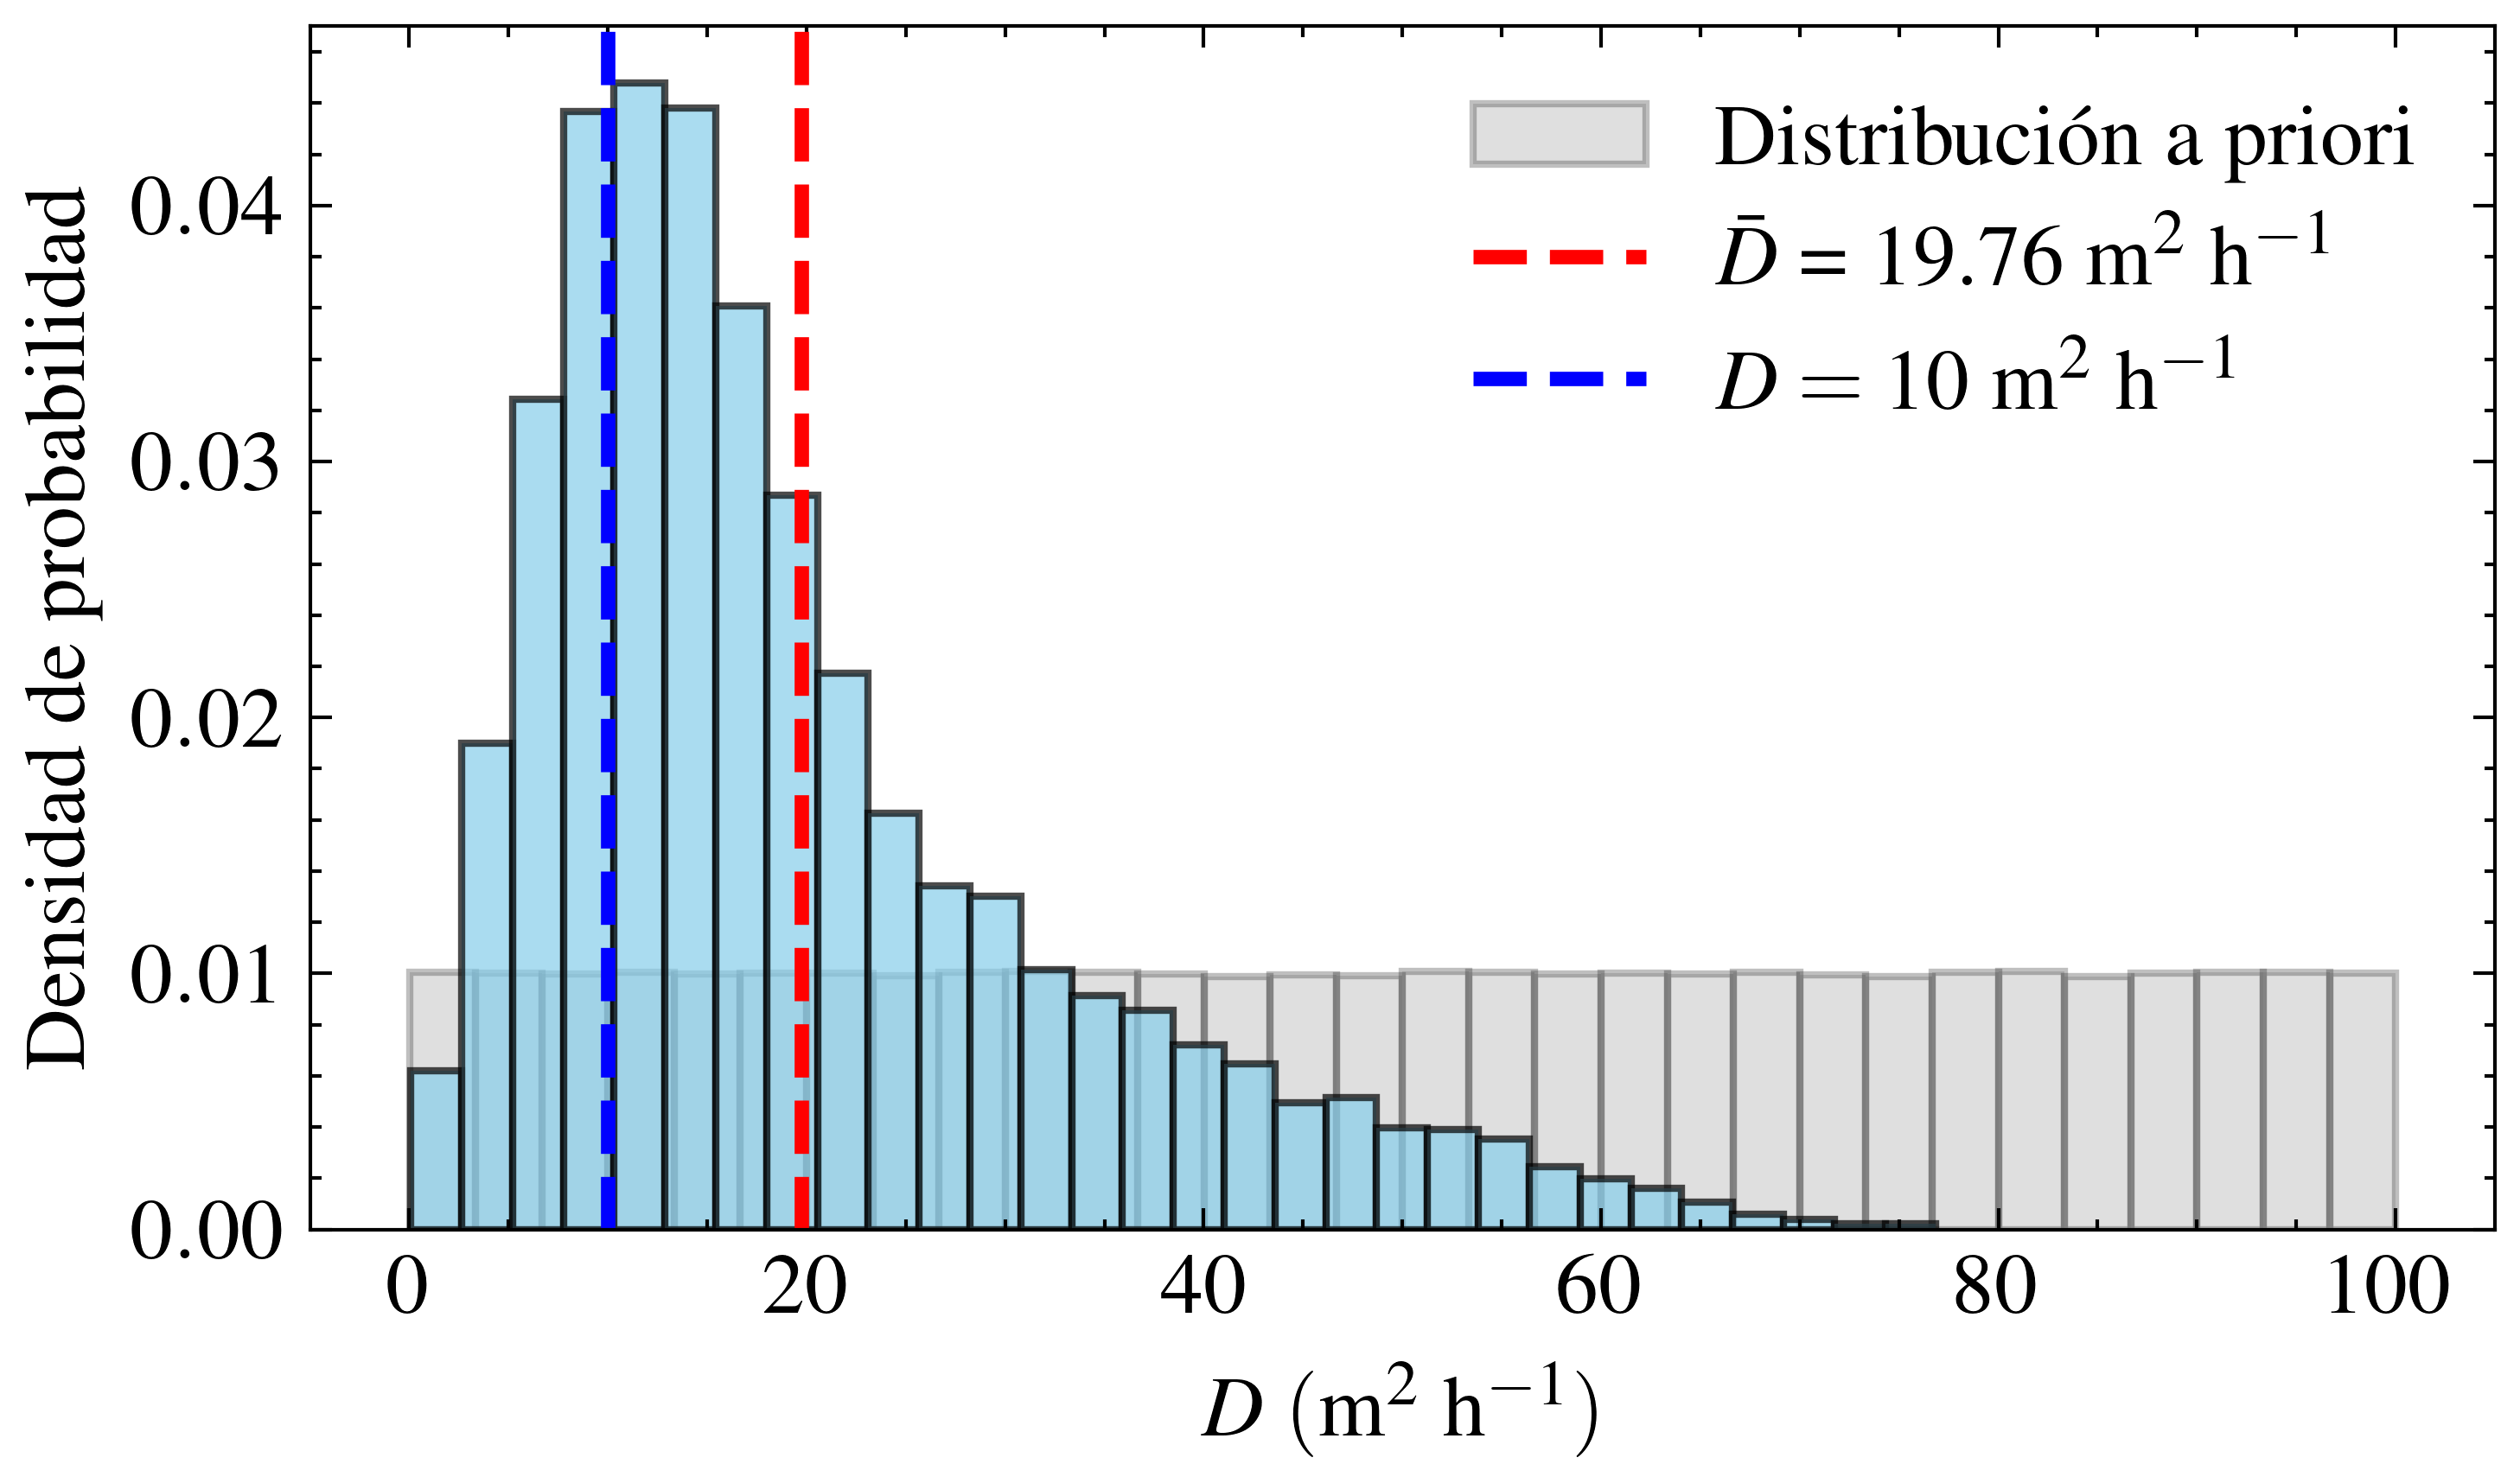

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.hist(df_completo['D'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000['D'], bins=30, alpha=0.7, density=True, edgecolor='black', color='skyblue')
ax.axvline(mejores_10000['D'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{D}}$ = {mejores_10000["D"].mean():.2f} $\\mathrm{{m^2~h^{{-1}}}}$')
ax.axvline(10, color='blue', linestyle='dashed', linewidth=2, label='$D = 10~\\mathrm{m^2~h^{-1}}$')
ax.set_xlabel('$D~(\\mathrm{m^2~h^{-1}})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_D_exp1_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

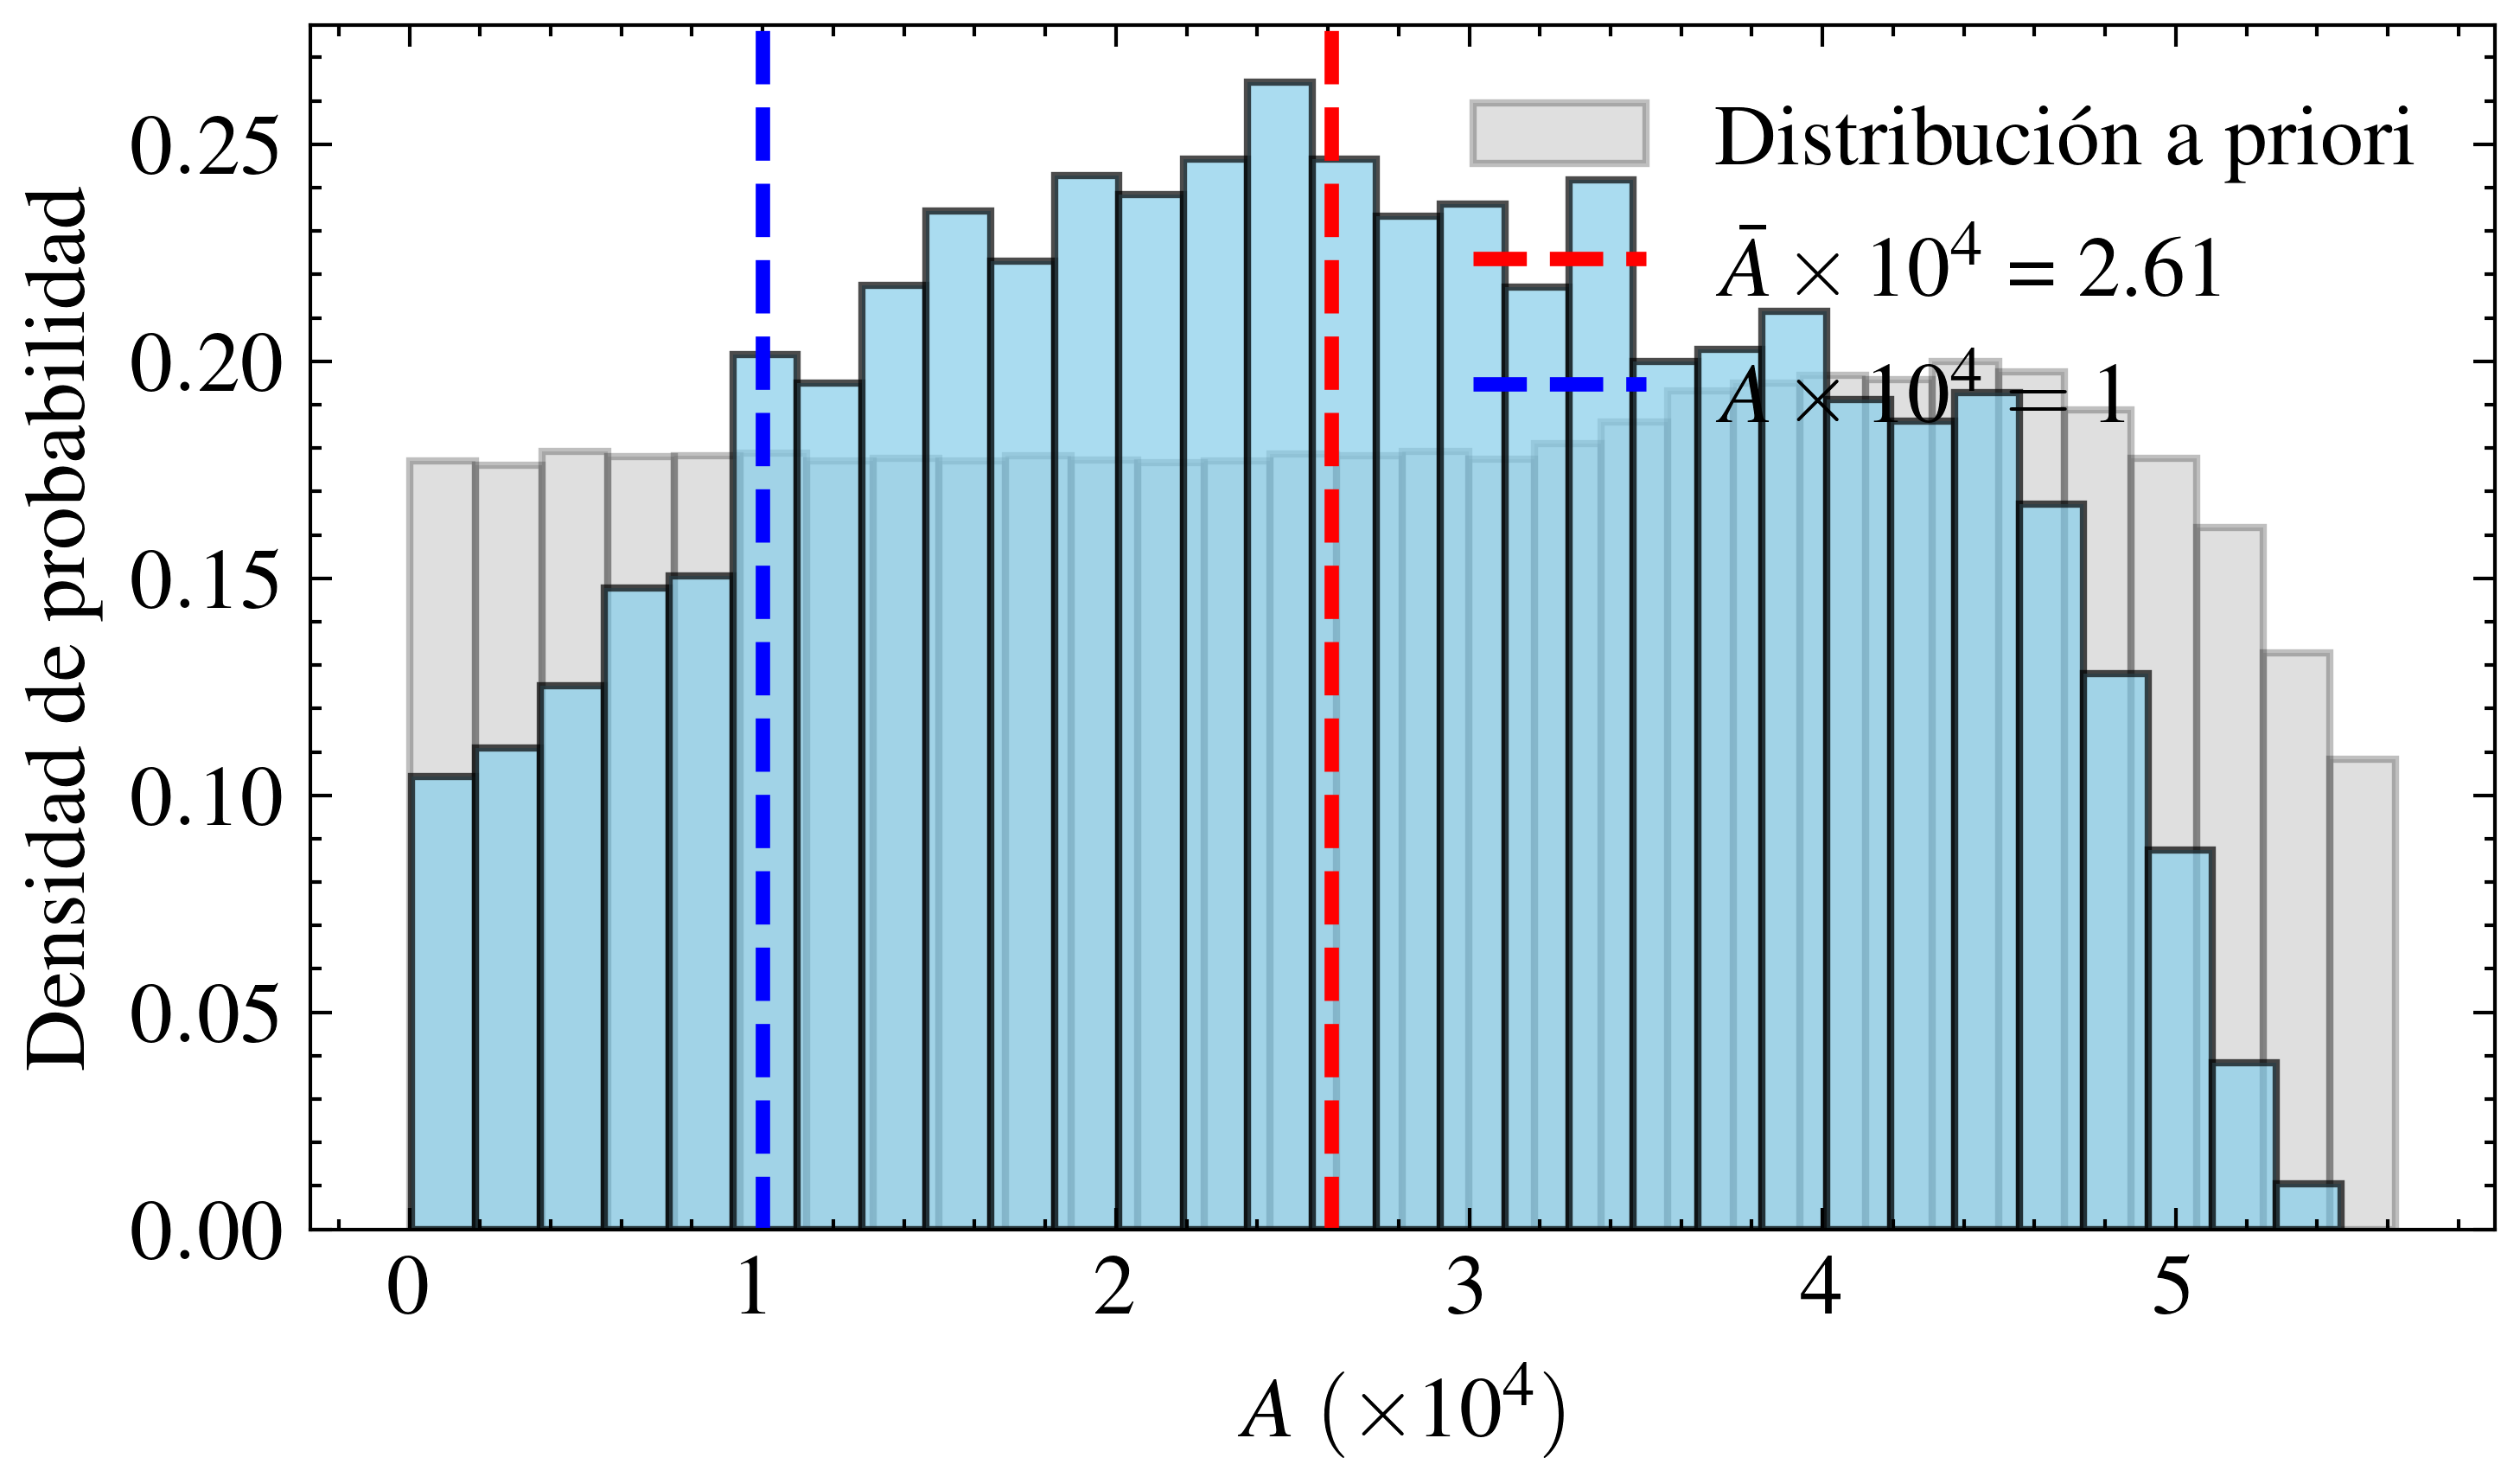

In [84]:
fig, ax = plt.subplots(figsize=(5, 3))

# Histograma original (atrás)
ax.hist(df_completo['A'] * 1e4, bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000['A'] * 1e4, bins=30, alpha=0.7, density=True, edgecolor='black', color='skyblue')
ax.axvline(mejores_10000['A'].mean() * 1e4, color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{A}} \\times 10^{4}$ = {mejores_10000["A"].mean() * 1e4:.2f}')
ax.axvline(0.0001 * 1e4, color='blue', linestyle='dashed', linewidth=2, label='$A \\times 10^{4} = 1$')
ax.set_xlabel('$A~(\\times 10^{4})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_A_exp1_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

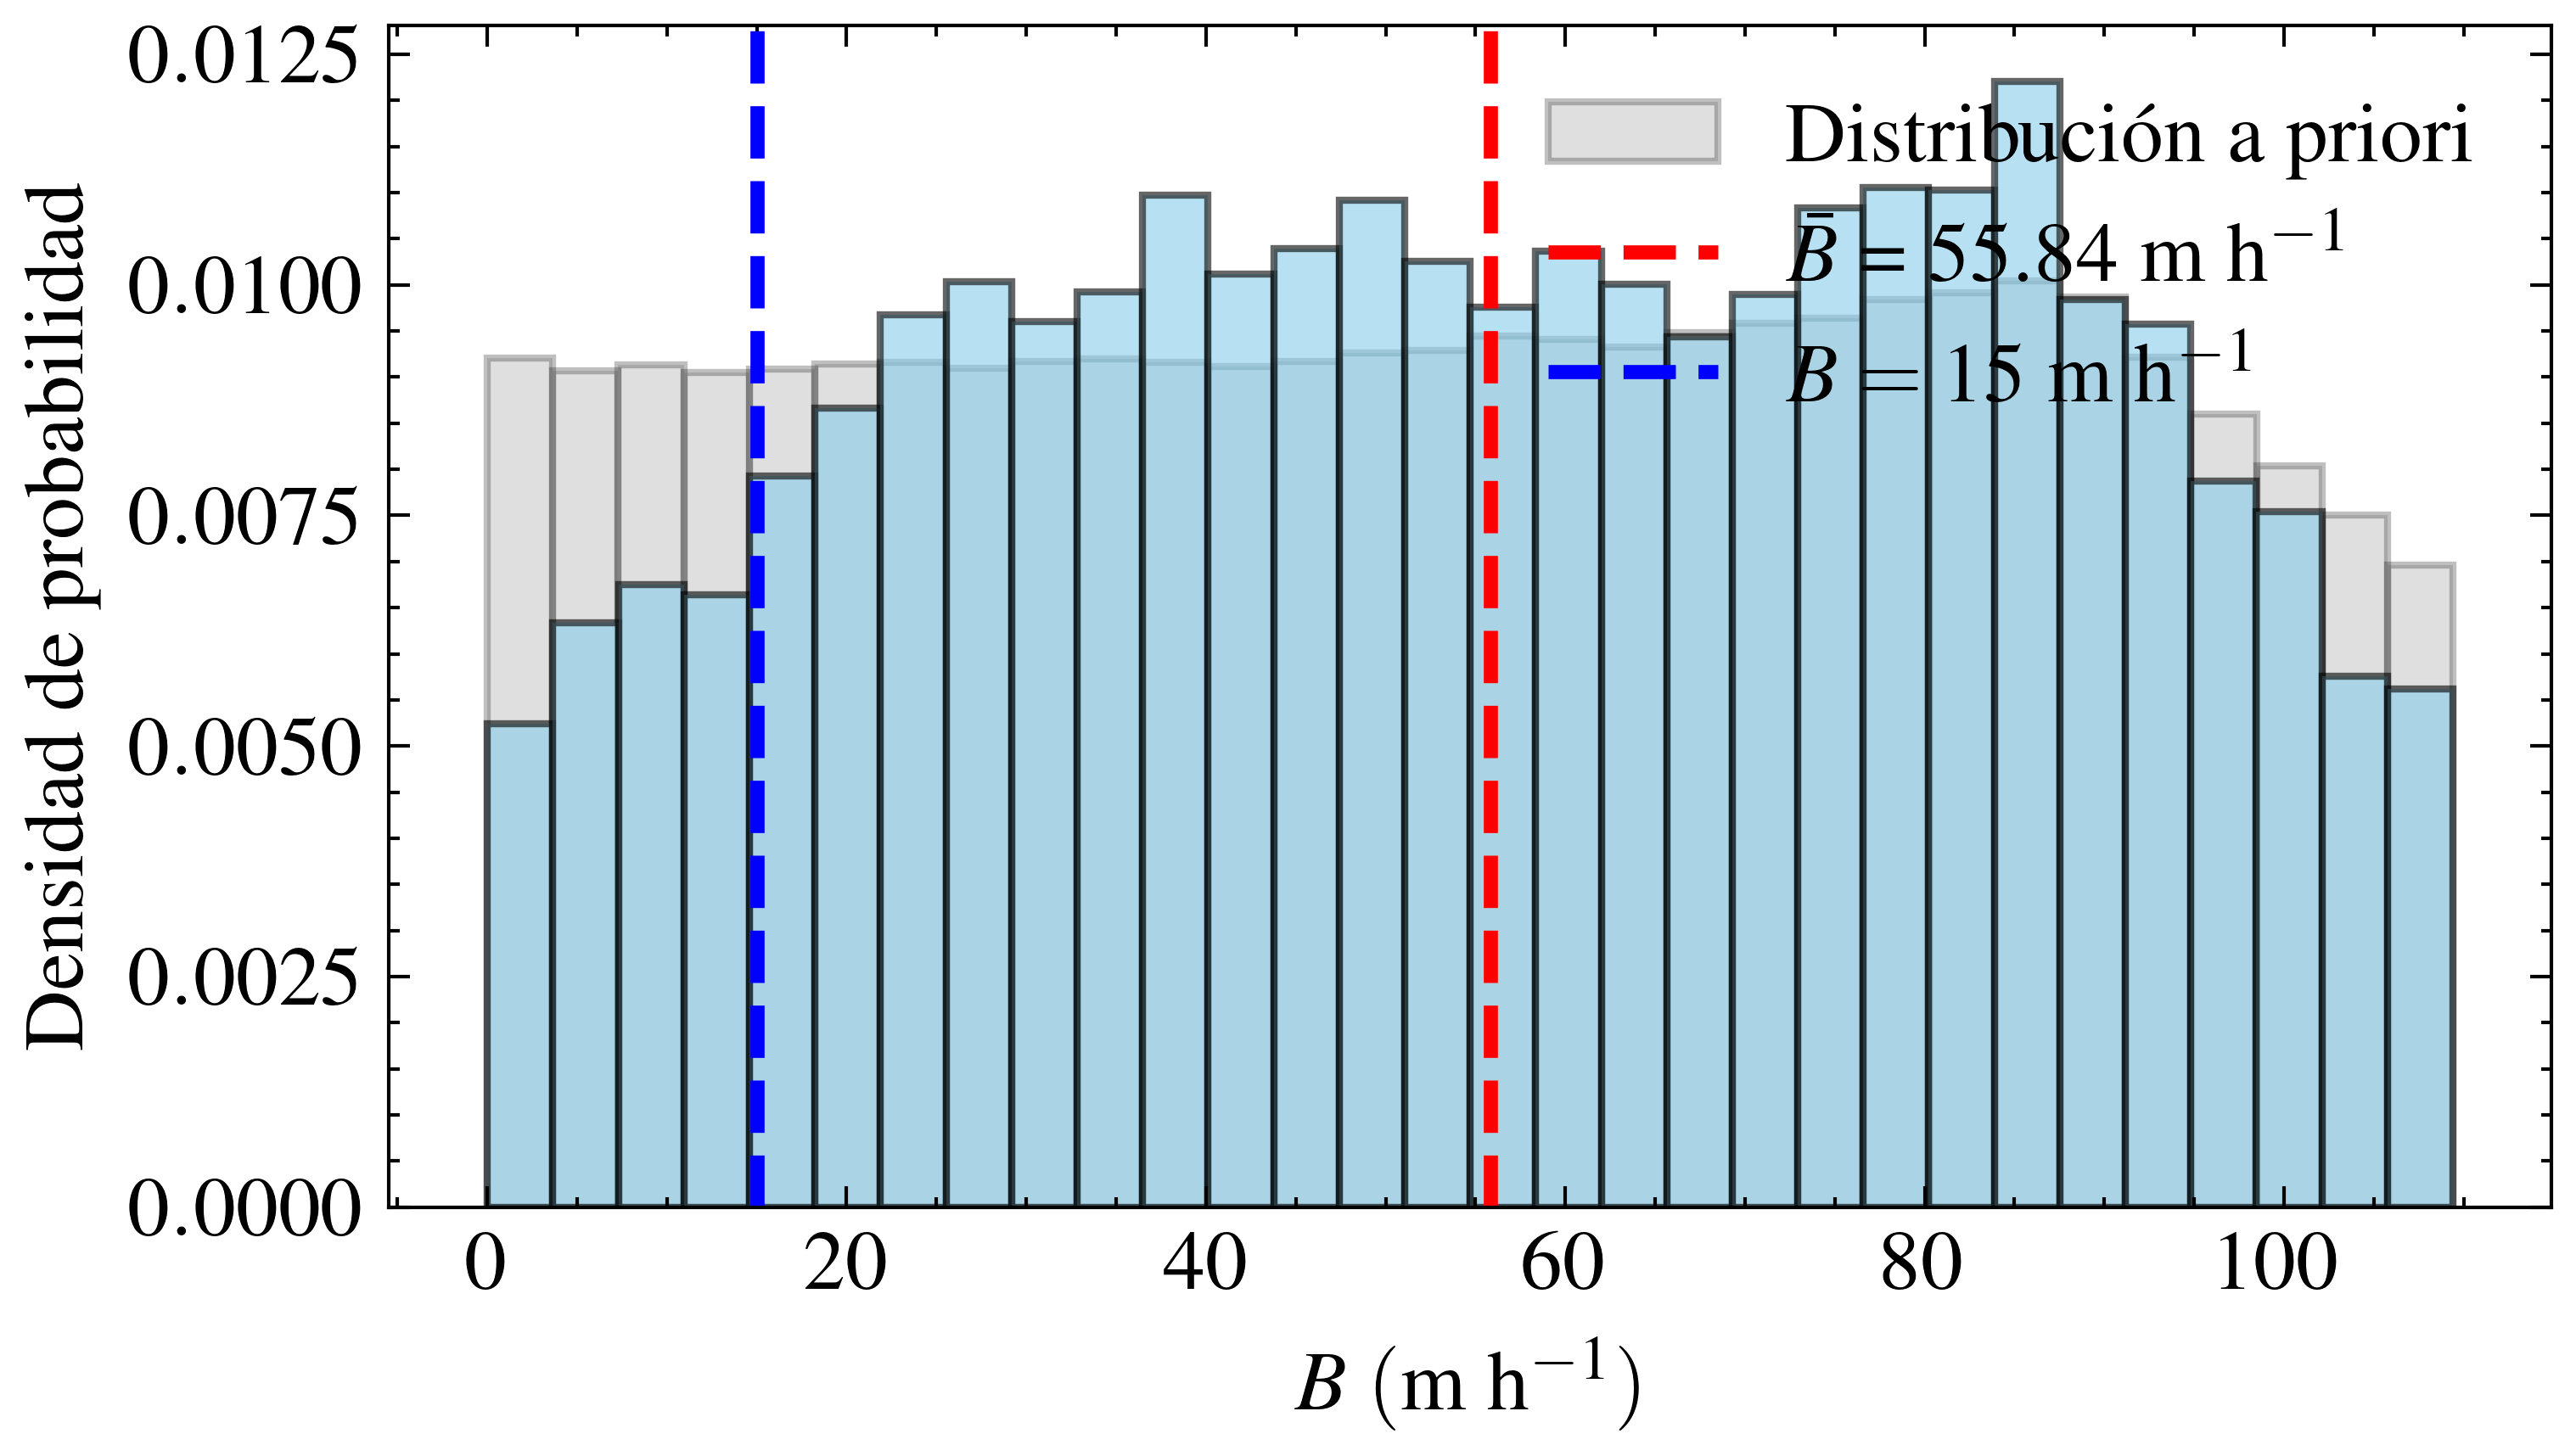

In [89]:
fig, ax = plt.subplots(figsize=(5.2, 3))

ax.hist(df_completo['B'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000['B'], bins=30, alpha=0.6, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000['B'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{B}}$ = {mejores_10000["B"].mean():.2f} $\\mathrm{{m~h^{{-1}}}}$')
ax.axvline(15, color='blue', linestyle='dashed', linewidth=2, label='$B = 15~\\mathrm{m~h^{-1}}$')
ax.set_xlabel('$B~(\\mathrm{m~h^{-1}})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig('hist_B_exp1_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

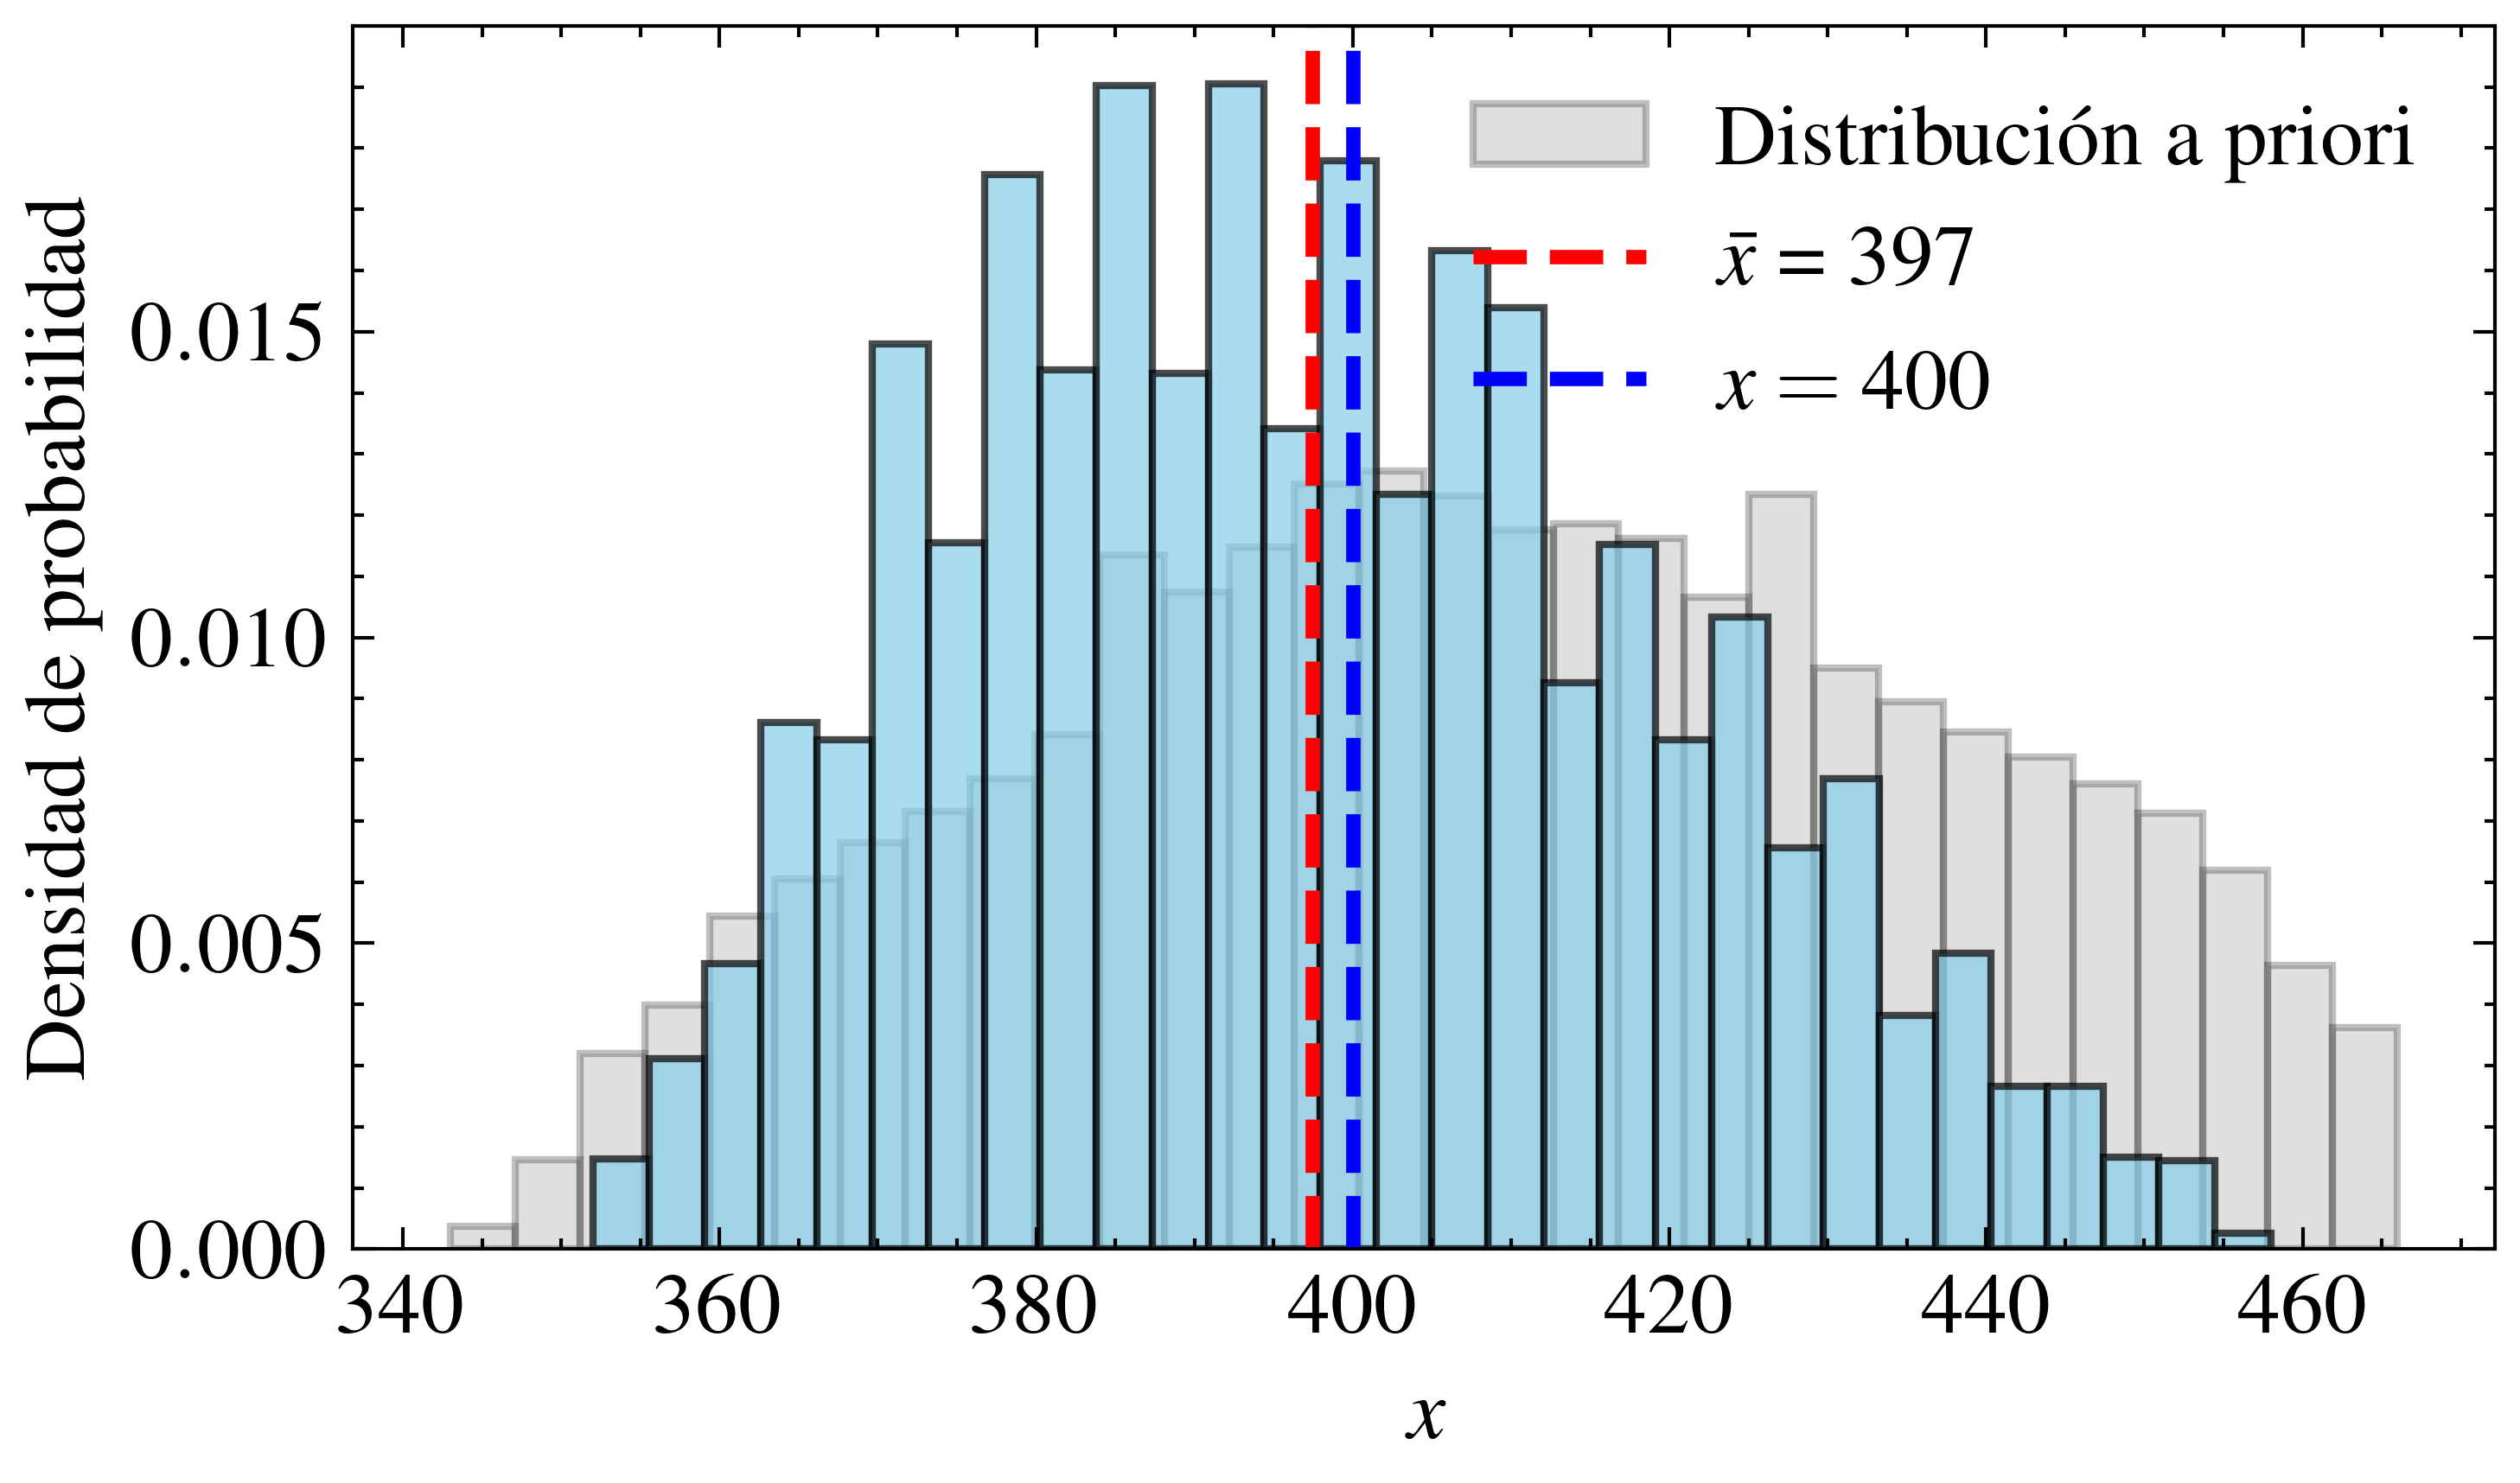

In [68]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo['x'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000['x'], bins=30, alpha=0.7, density=True, edgecolor='black', color='skyblue')
ax.axvline(mejores_10000['x'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{x}}$ = {int(mejores_10000["x"].mean())}')
ax.axvline(400, color='blue', linestyle='dashed', linewidth=2, label='$x = 400$')
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_x_exp1_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

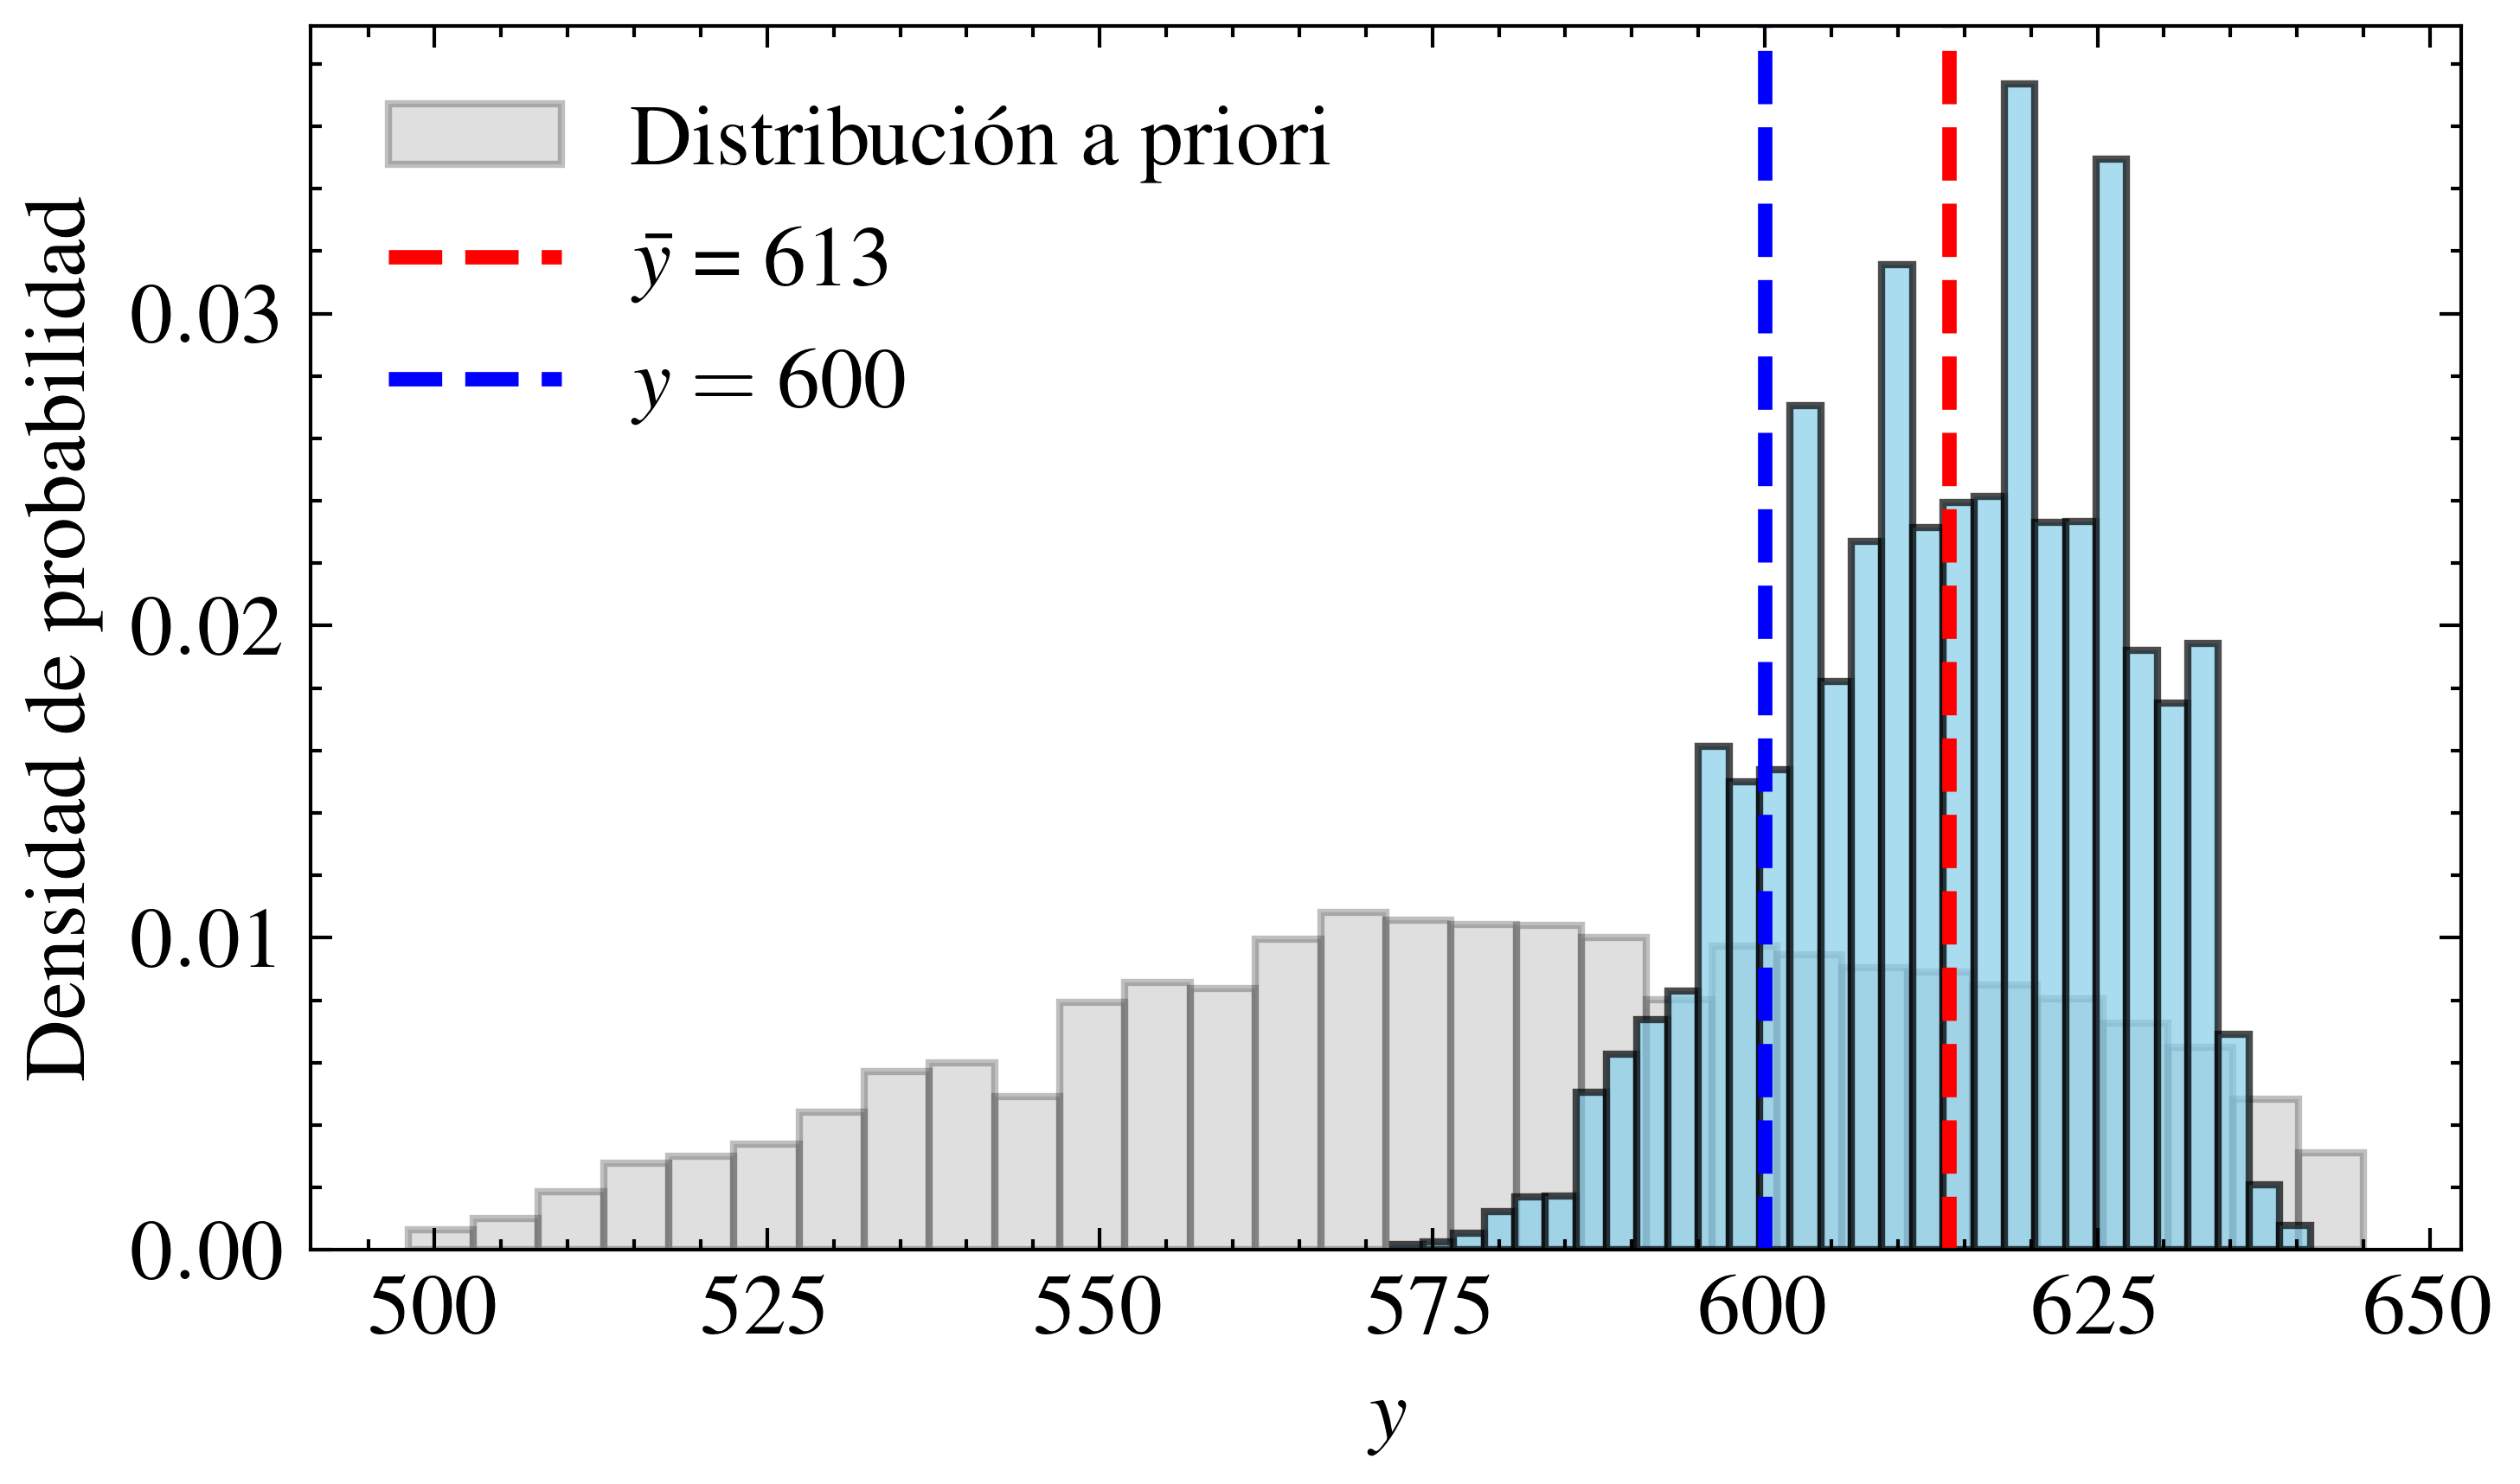

In [67]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo['y'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000['y'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000['y'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{y}}$ = {int(mejores_10000["y"].mean())}')
ax.axvline(600, color='blue', linestyle='dashed', linewidth=2, label='$y = 600$')
ax.set_xlabel('$y$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_y_exp1_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

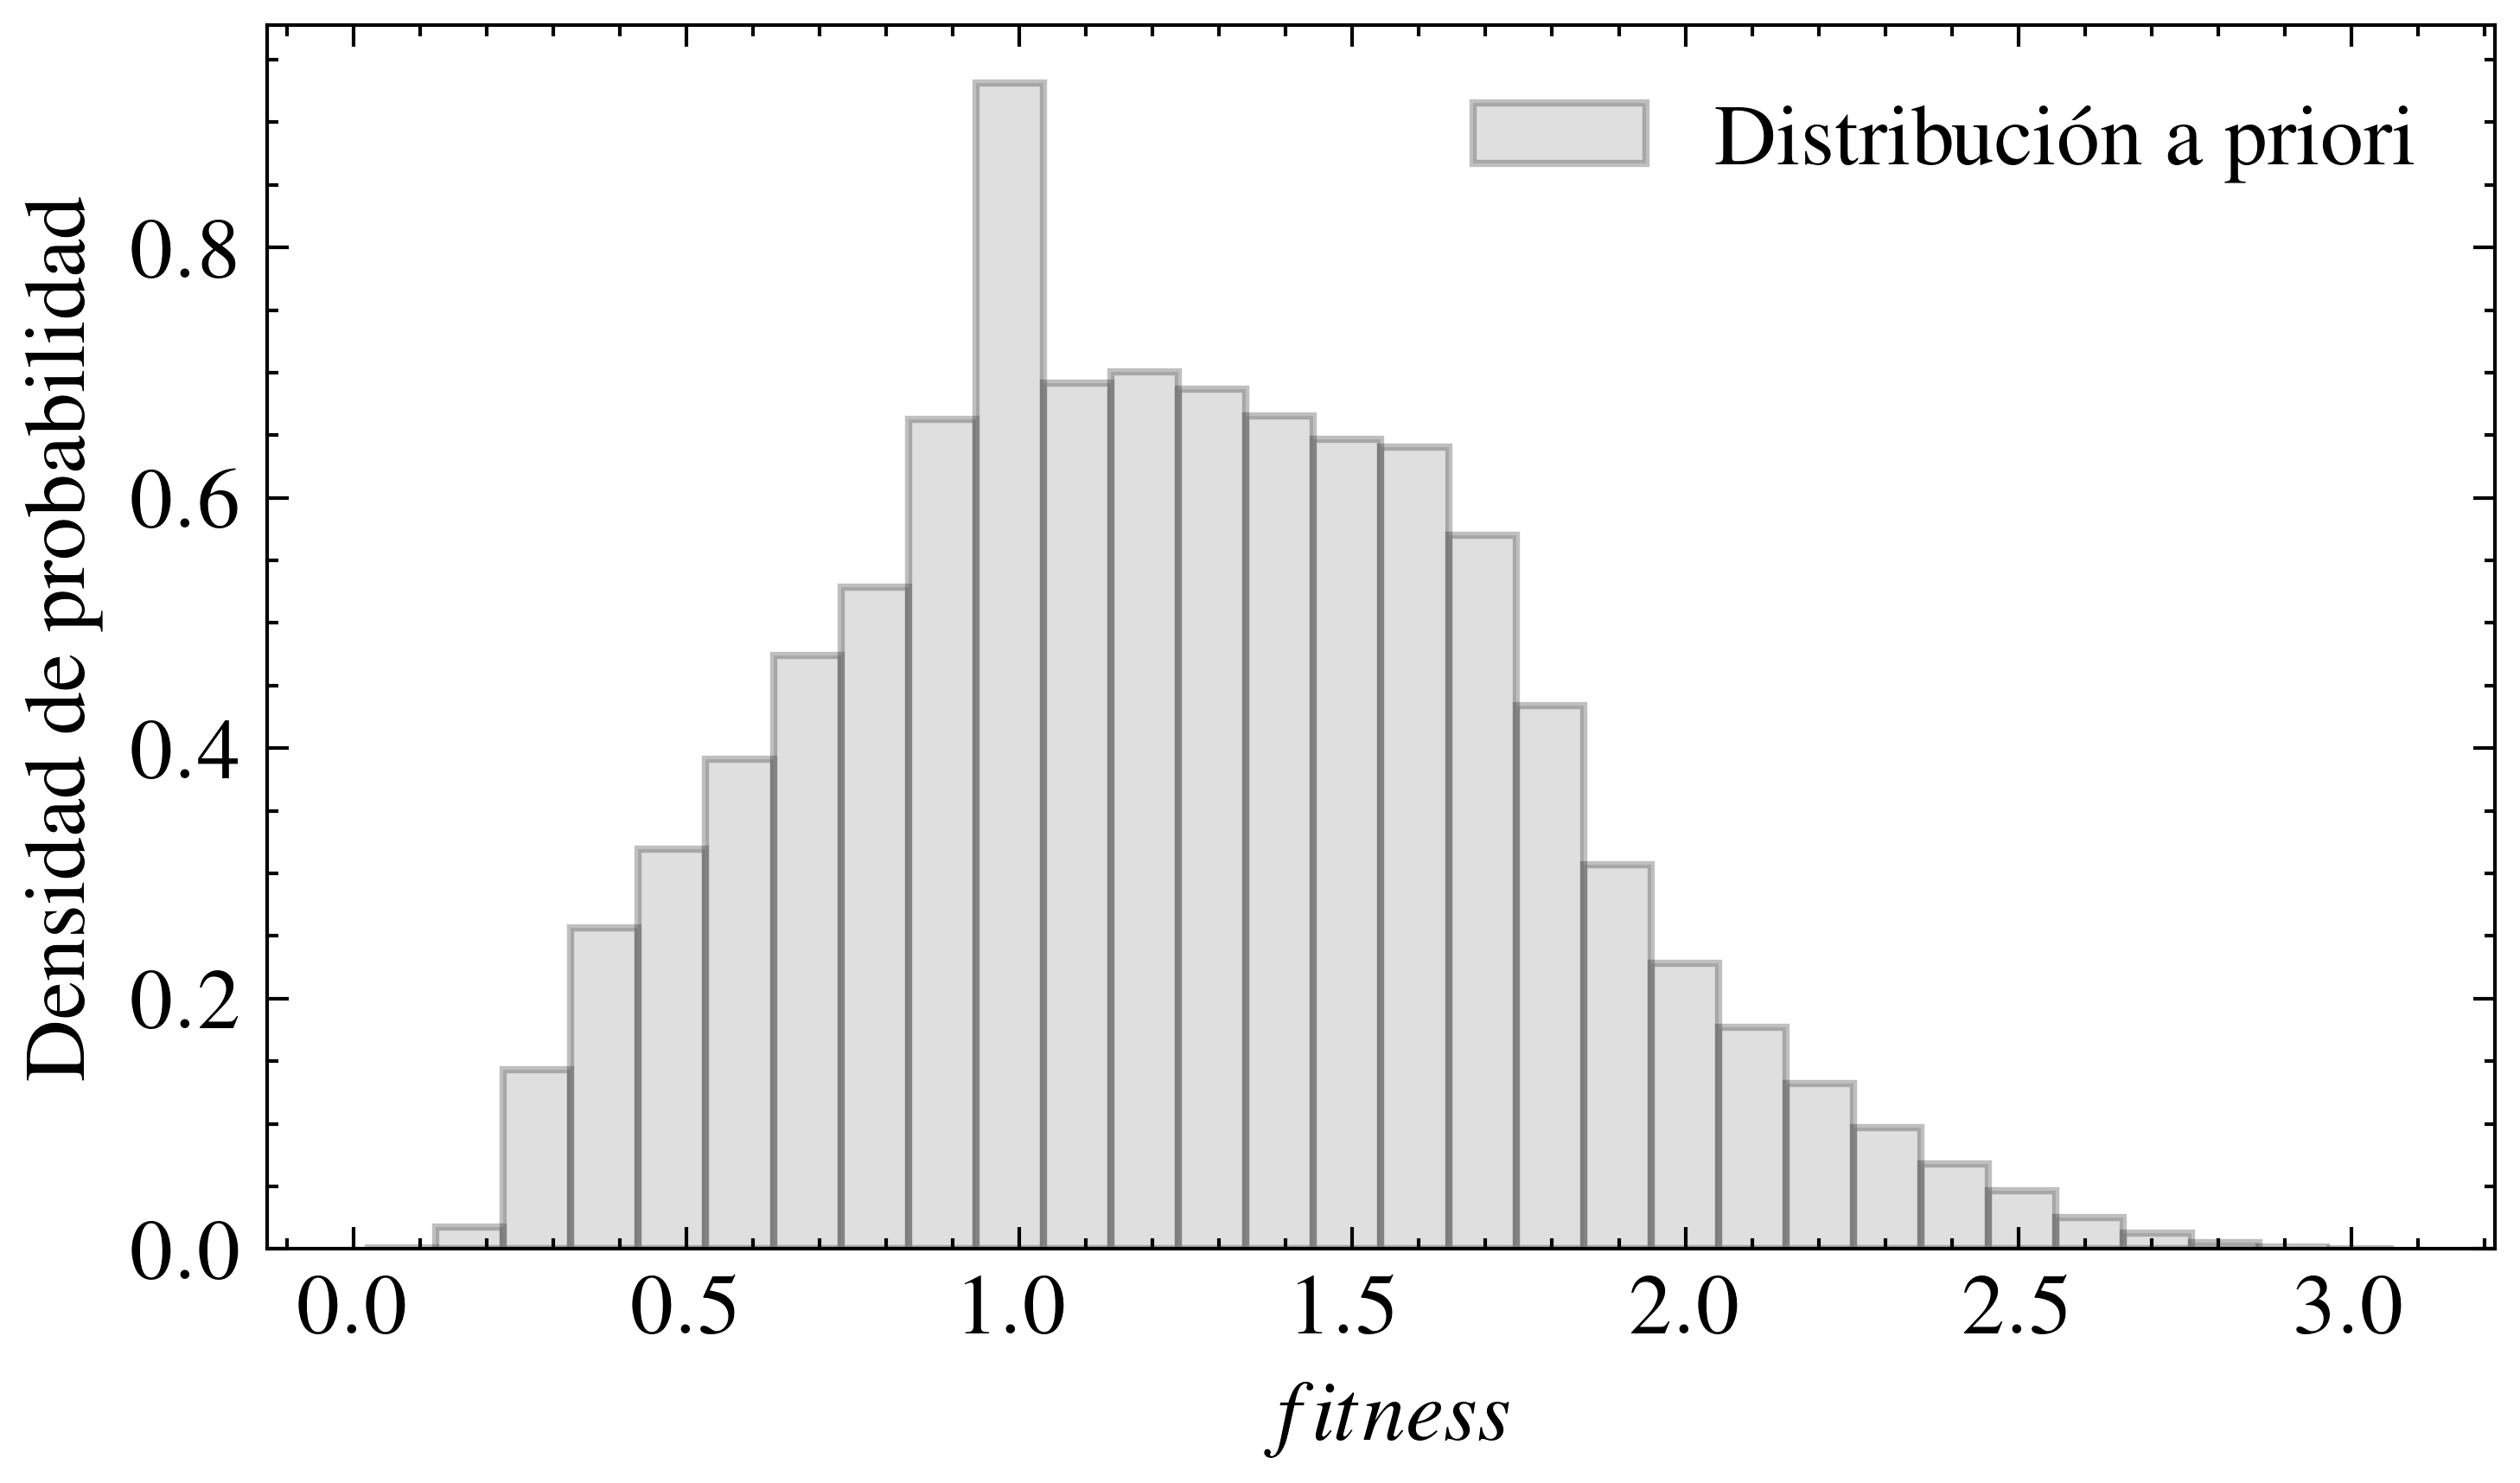

In [14]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo['fitness'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

# ax.hist(mejores_10000['fitness'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
# ax.axvline(mejores_10000['fitness'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{fitness}}$ = {mejores_10000["fitness"].mean()}')
ax.set_xlabel('$fitness$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_fitness_exp1_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

In [6]:
# Mejor individuo
mejor_individuo = mejores_10000.iloc[0]
print("Mejor individuo encontrado:")
print(mejor_individuo)

Mejor individuo encontrado:
D           10.7868928909
A            0.0000920663
B           13.5312194824
x          399.0000000000
y          599.0000000000
fitness      0.0219819181
Name: 977924, dtype: float64


In [7]:
fitnes_maximo = mejores_10000['fitness'].max()
print("Fitness máximo entre los mejores 10,000 individuos:", fitnes_maximo)

Fitness máximo entre los mejores 10,000 individuos: 0.2948945222478284


In [14]:
# Uso
res = bootstrap_confidence_intervals_df(mejores_10000, param_cols=["D", "A", "B", "x", "y"])

print("IC 95% de parámetros medios:\n", res["mean_params_CI"])
print("\nIC 95% de mejores parámetros:\n", res["best_params_CI"])

IC 95% de parámetros medios:
   param             low            high       boot_mean
0     D   19.4977747079   20.0330326177   19.7669968469
1     A    0.0002585392    0.0002636493    0.0002610374
2     B   55.2777417062   56.4061576055   55.8451926829
3     x  396.9807925000  397.8383275000  397.4111189000
4     y  613.6173575000  614.0922100000  613.8420070000

IC 95% de mejores parámetros:
   param             low            high       boot_mean
0     D    8.6518182755   12.7455329895   10.3732415981
1     A    0.0000920663    0.0001829350    0.0000996579
2     B   12.5401992798   19.9822463989   14.1282019272
3     x  394.0000000000  400.0000000000  398.9300000000
4     y  599.0000000000  609.0000000000  599.6780000000


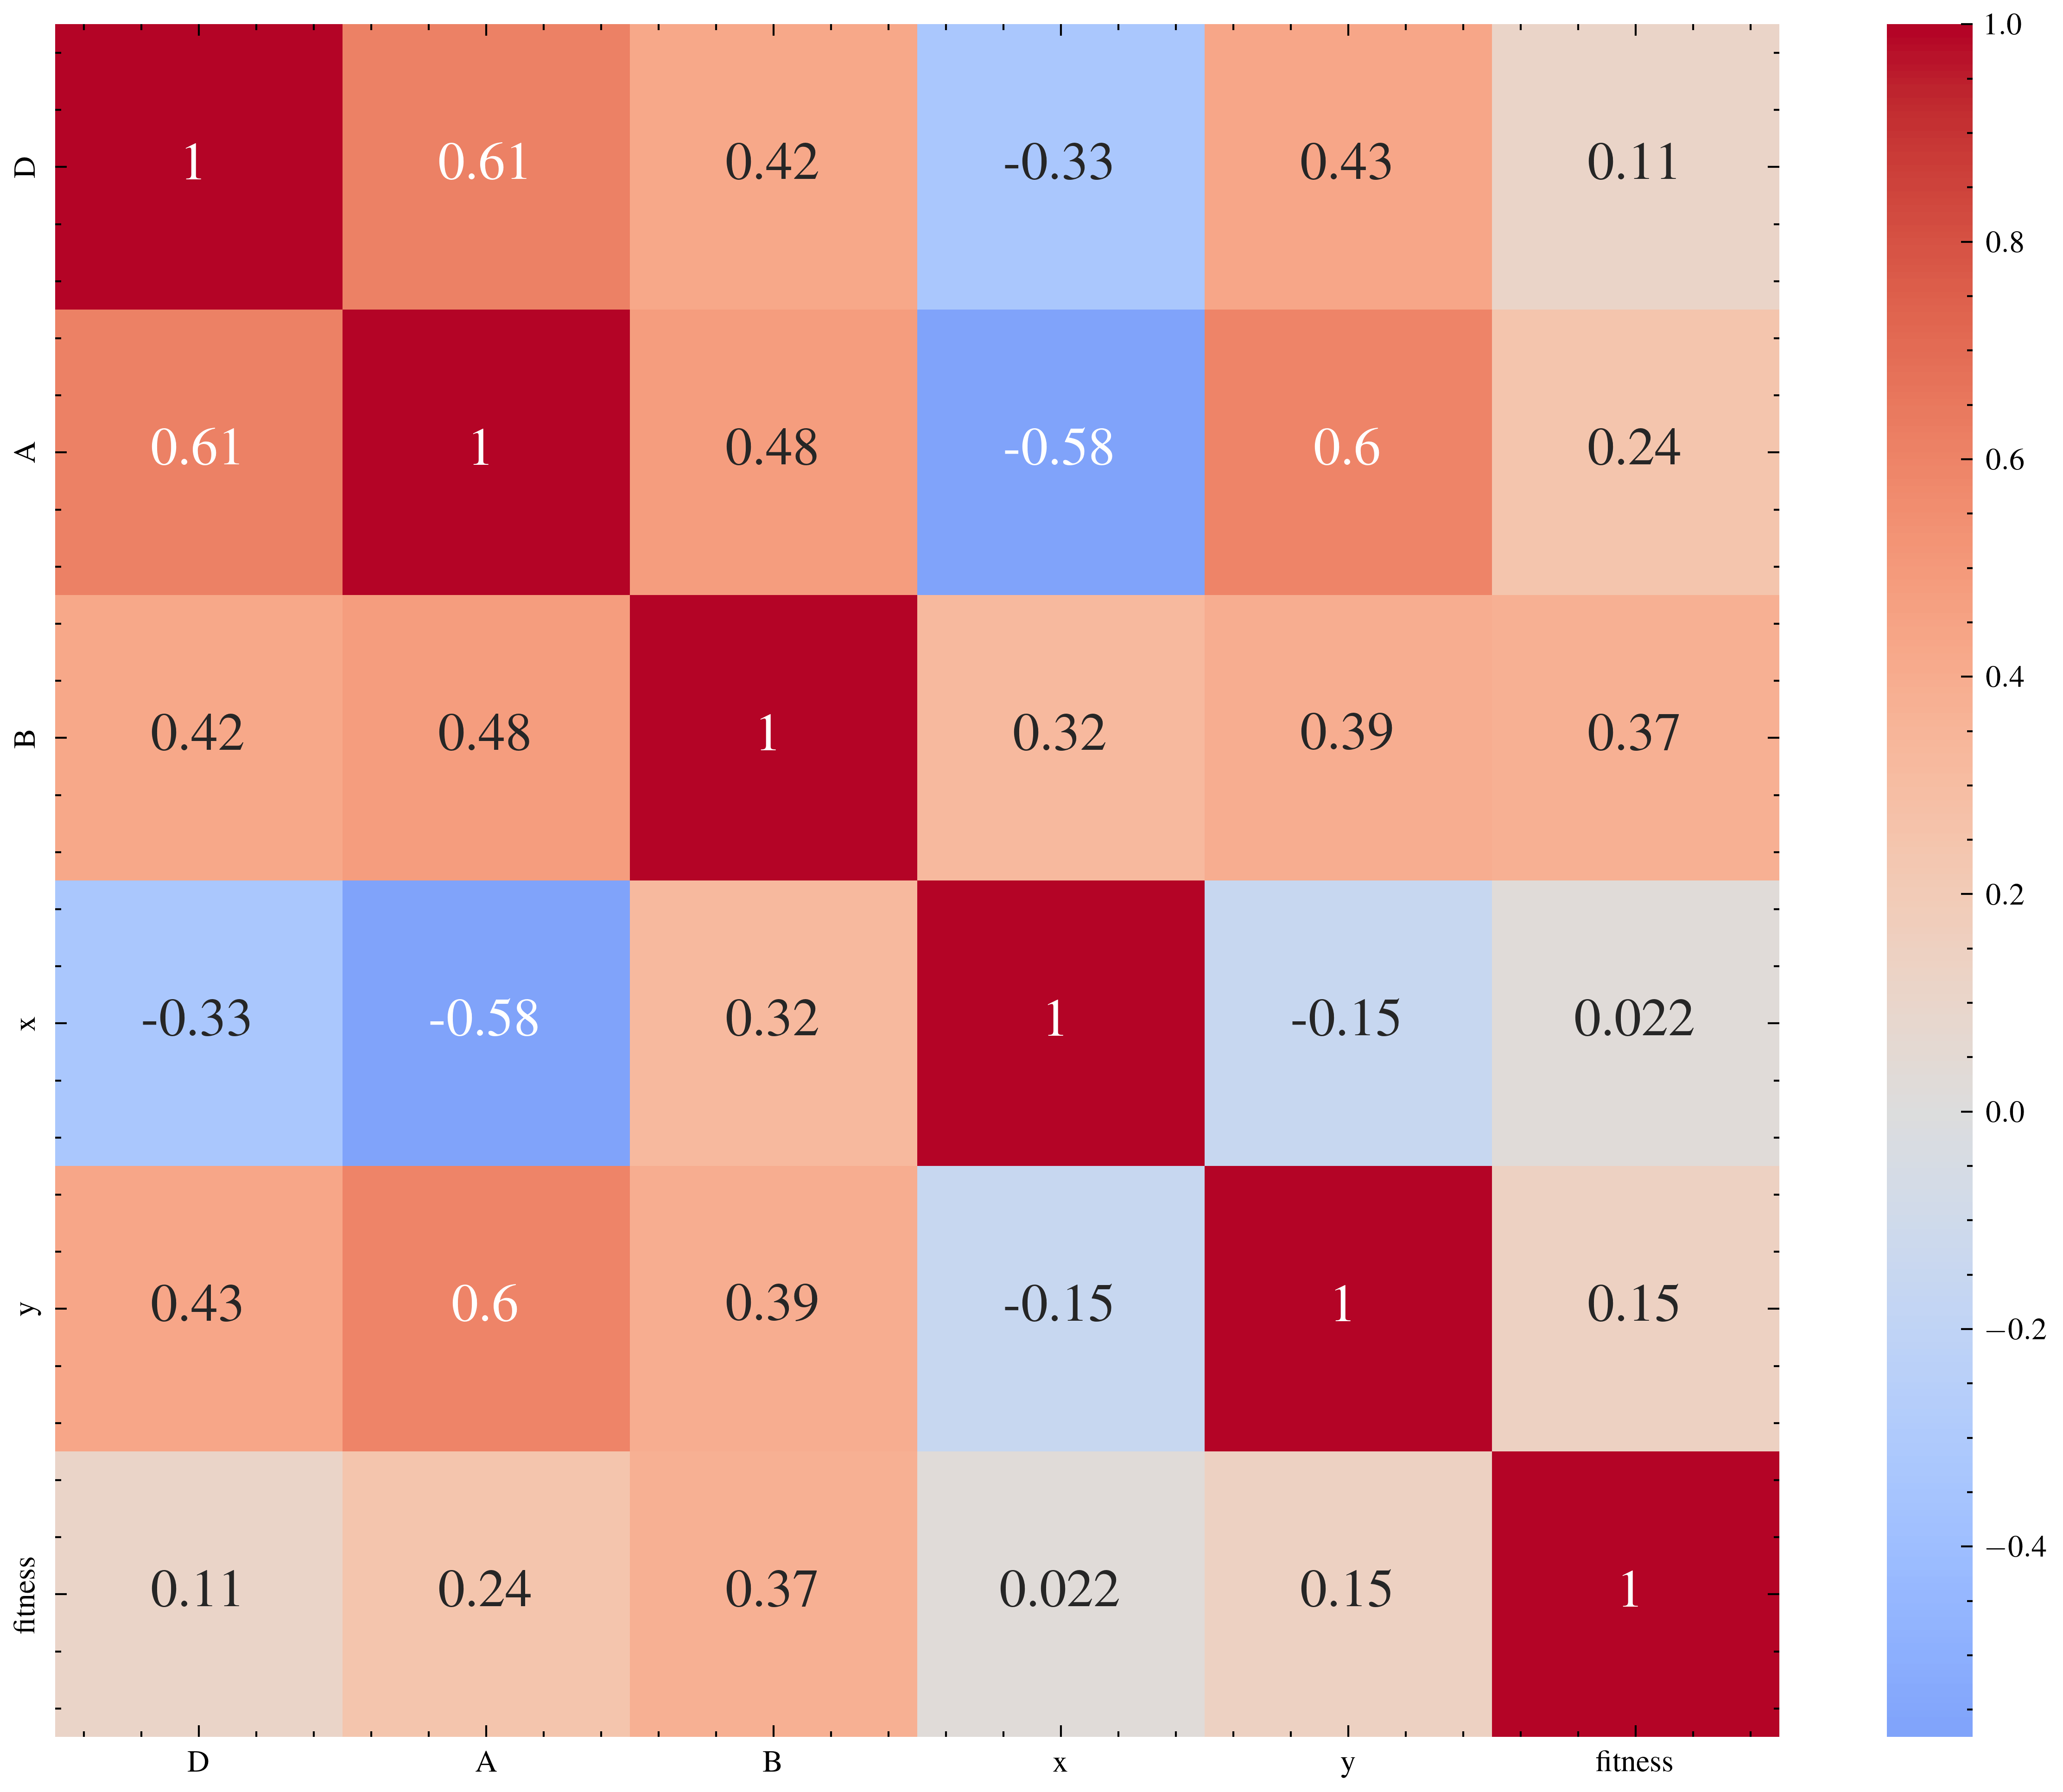

In [24]:
# # --- Opción 1: Matriz de correlación completa ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    mejores_10000.corr(), 
    annot=True, 
    annot_kws={"size": 14},
    cmap="coolwarm", 
    center=0,
)
plt.show()

# Experimento 2

In [4]:
# Ruta a la carpeta que contiene los CSVs
carpeta = "resultados_fuerza_bruta/Resultados_exp2"

# Lista todos los archivos CSV en la carpeta
csv_files = glob.glob(os.path.join(carpeta, "*.csv"))

# Cargá todos los CSVs en una lista de DataFrames
dataframes = [pd.read_csv(f) for f in csv_files]

# Opcional: combiná todos los DataFrames en uno solo
df_completo_2 = pd.concat(dataframes, ignore_index=True)

In [5]:
print("Número total de filas en el DataFrame combinado:", len(df_completo_2))
print(df_completo_2.head())

Número total de filas en el DataFrame combinado: 1020000
               D             A              B      x      y          beta  \
0   8.3219451904  0.0005136104  78.8525136765  442.0  633.0  0.1087016016   
1  47.0369911194  0.0004696747  12.9764976501  363.0  585.0  0.5963473320   
2   8.6584959030  0.0002526450  96.2692260742  378.0  496.0  1.1913123131   
3  22.2462615967  0.0001497603  24.6899681091  479.0  578.0  0.1597158313   
4   5.5183677673  0.0003086034  45.5954170227  461.0  596.0  1.6041336060   

          gamma       fitness  
0  0.0978314355  0.9629003764  
1  0.5665489435  0.9421998617  
2  0.1071092561  0.8426530455  
3  0.1437442452  0.9210768876  
4  0.7768857479  0.8921960212  


In [6]:
df_ordenado_2 = df_completo_2.sort_values(by='fitness')
# mejores_10000 = df_ordenado.head(10000)
# Seleccionamos los que tengan fitness menor a 0.1
mejores_10000_2 = df_ordenado_2[df_ordenado_2['fitness'] < 0.3]
print("Número de individuos con fitness menor a 0.1:", len(mejores_10000_2))
print(mejores_10000_2)

Número de individuos con fitness menor a 0.1: 23718
                     D             A              B      x      y  \
697701   44.4711875916  0.0000636124  21.1234855652  419.0  600.0   
891645   15.6712770462  0.0002268218  35.1730079651  393.0  613.0   
215019   25.9031658173  0.0001330536  26.5782413483  401.0  608.0   
695384   69.0397796631  0.0001967286  54.1469612122  402.0  613.0   
773494   49.3629417419  0.0001067160  22.2418613434  404.0  600.0   
...                ...           ...            ...    ...    ...   
370059   88.4155502319  0.0001730312  25.9686431885  355.0  586.0   
990202   27.1941661835  0.0004924225  85.5724716187  369.0  618.0   
1019901  77.4135055542  0.0002714015  64.7890548706  377.0  572.0   
524510   12.0306348801  0.0000193047  37.4203834534  452.0  585.0   
881353   13.5414819717  0.0000459838  25.5980281830  412.0  567.0   

                 beta         gamma       fitness  
697701   1.0626628399  0.5231912732  0.0329518396  
891645   1.5426

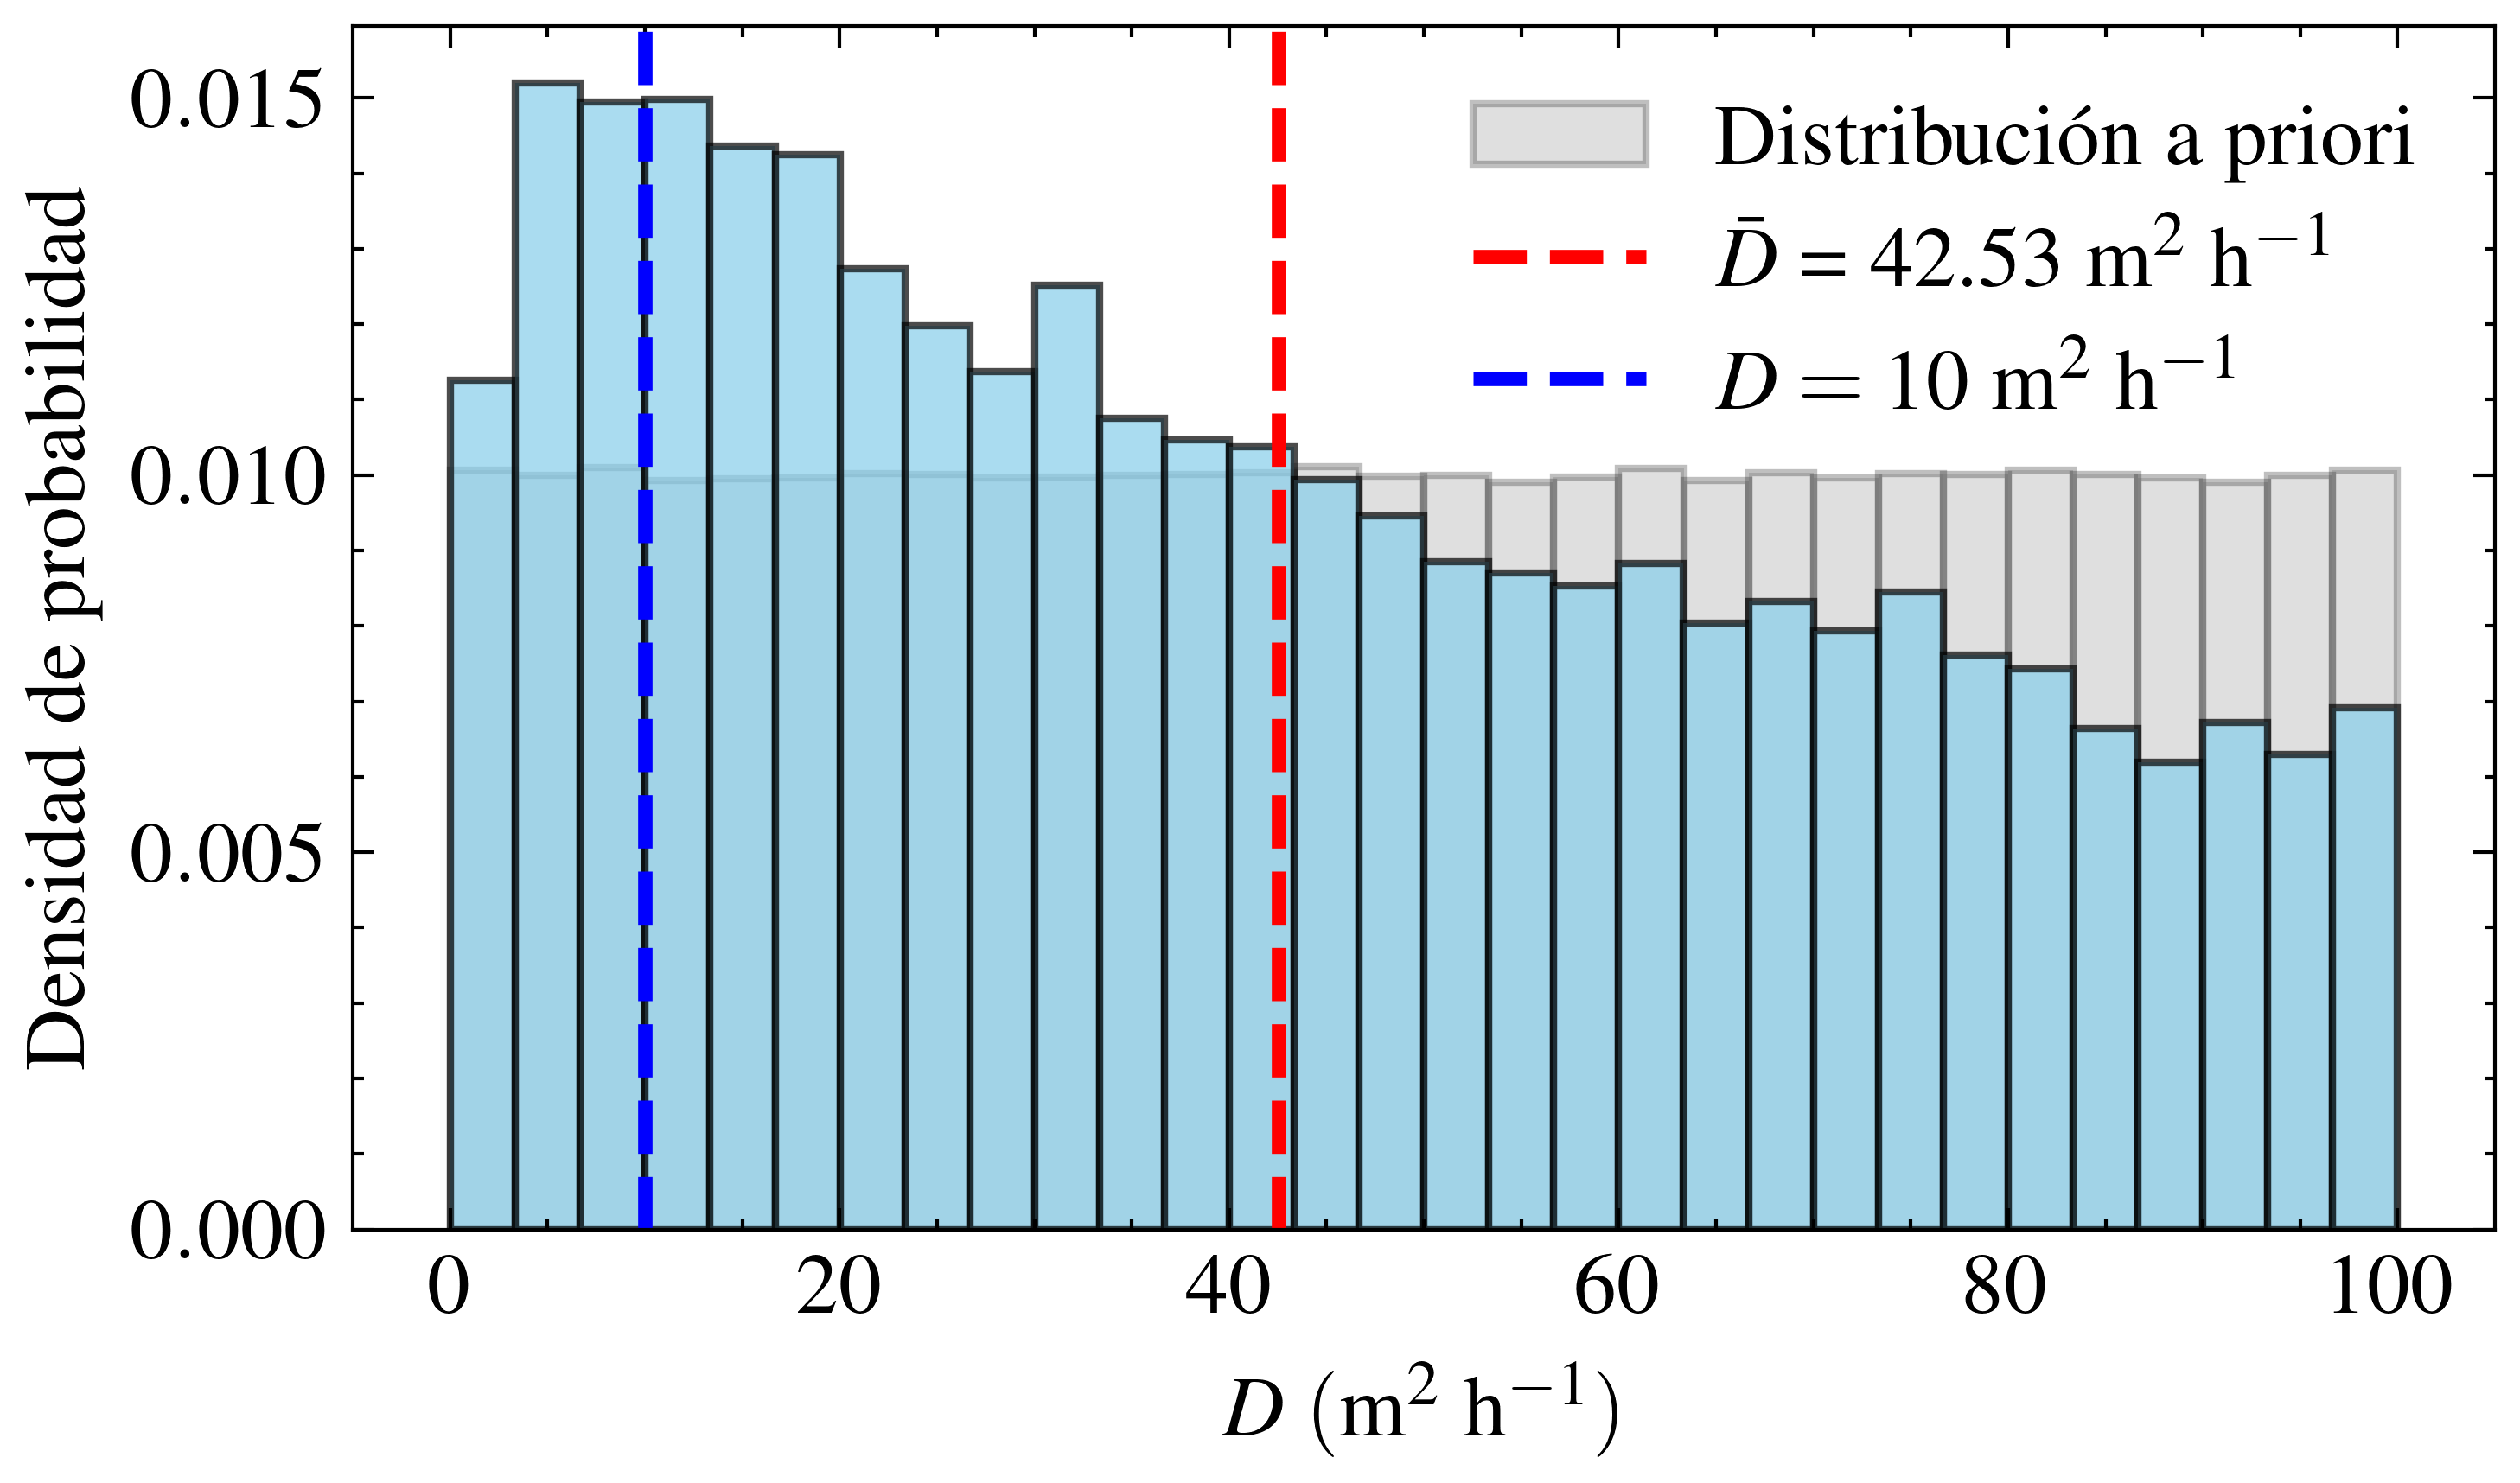

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.hist(df_completo_2['D'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_2['D'], bins=30, alpha=0.7, density=True, edgecolor='black', color='skyblue')
ax.axvline(mejores_10000_2['D'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{D}}$ = {mejores_10000_2["D"].mean():.2f} $\\mathrm{{m^2~h^{{-1}}}}$')
ax.axvline(10, color='blue', linestyle='dashed', linewidth=2, label='$D = 10~\\mathrm{m^2~h^{-1}}$')
ax.set_xlabel('$D~(\\mathrm{m^2~h^{-1}})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_D_exp2_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

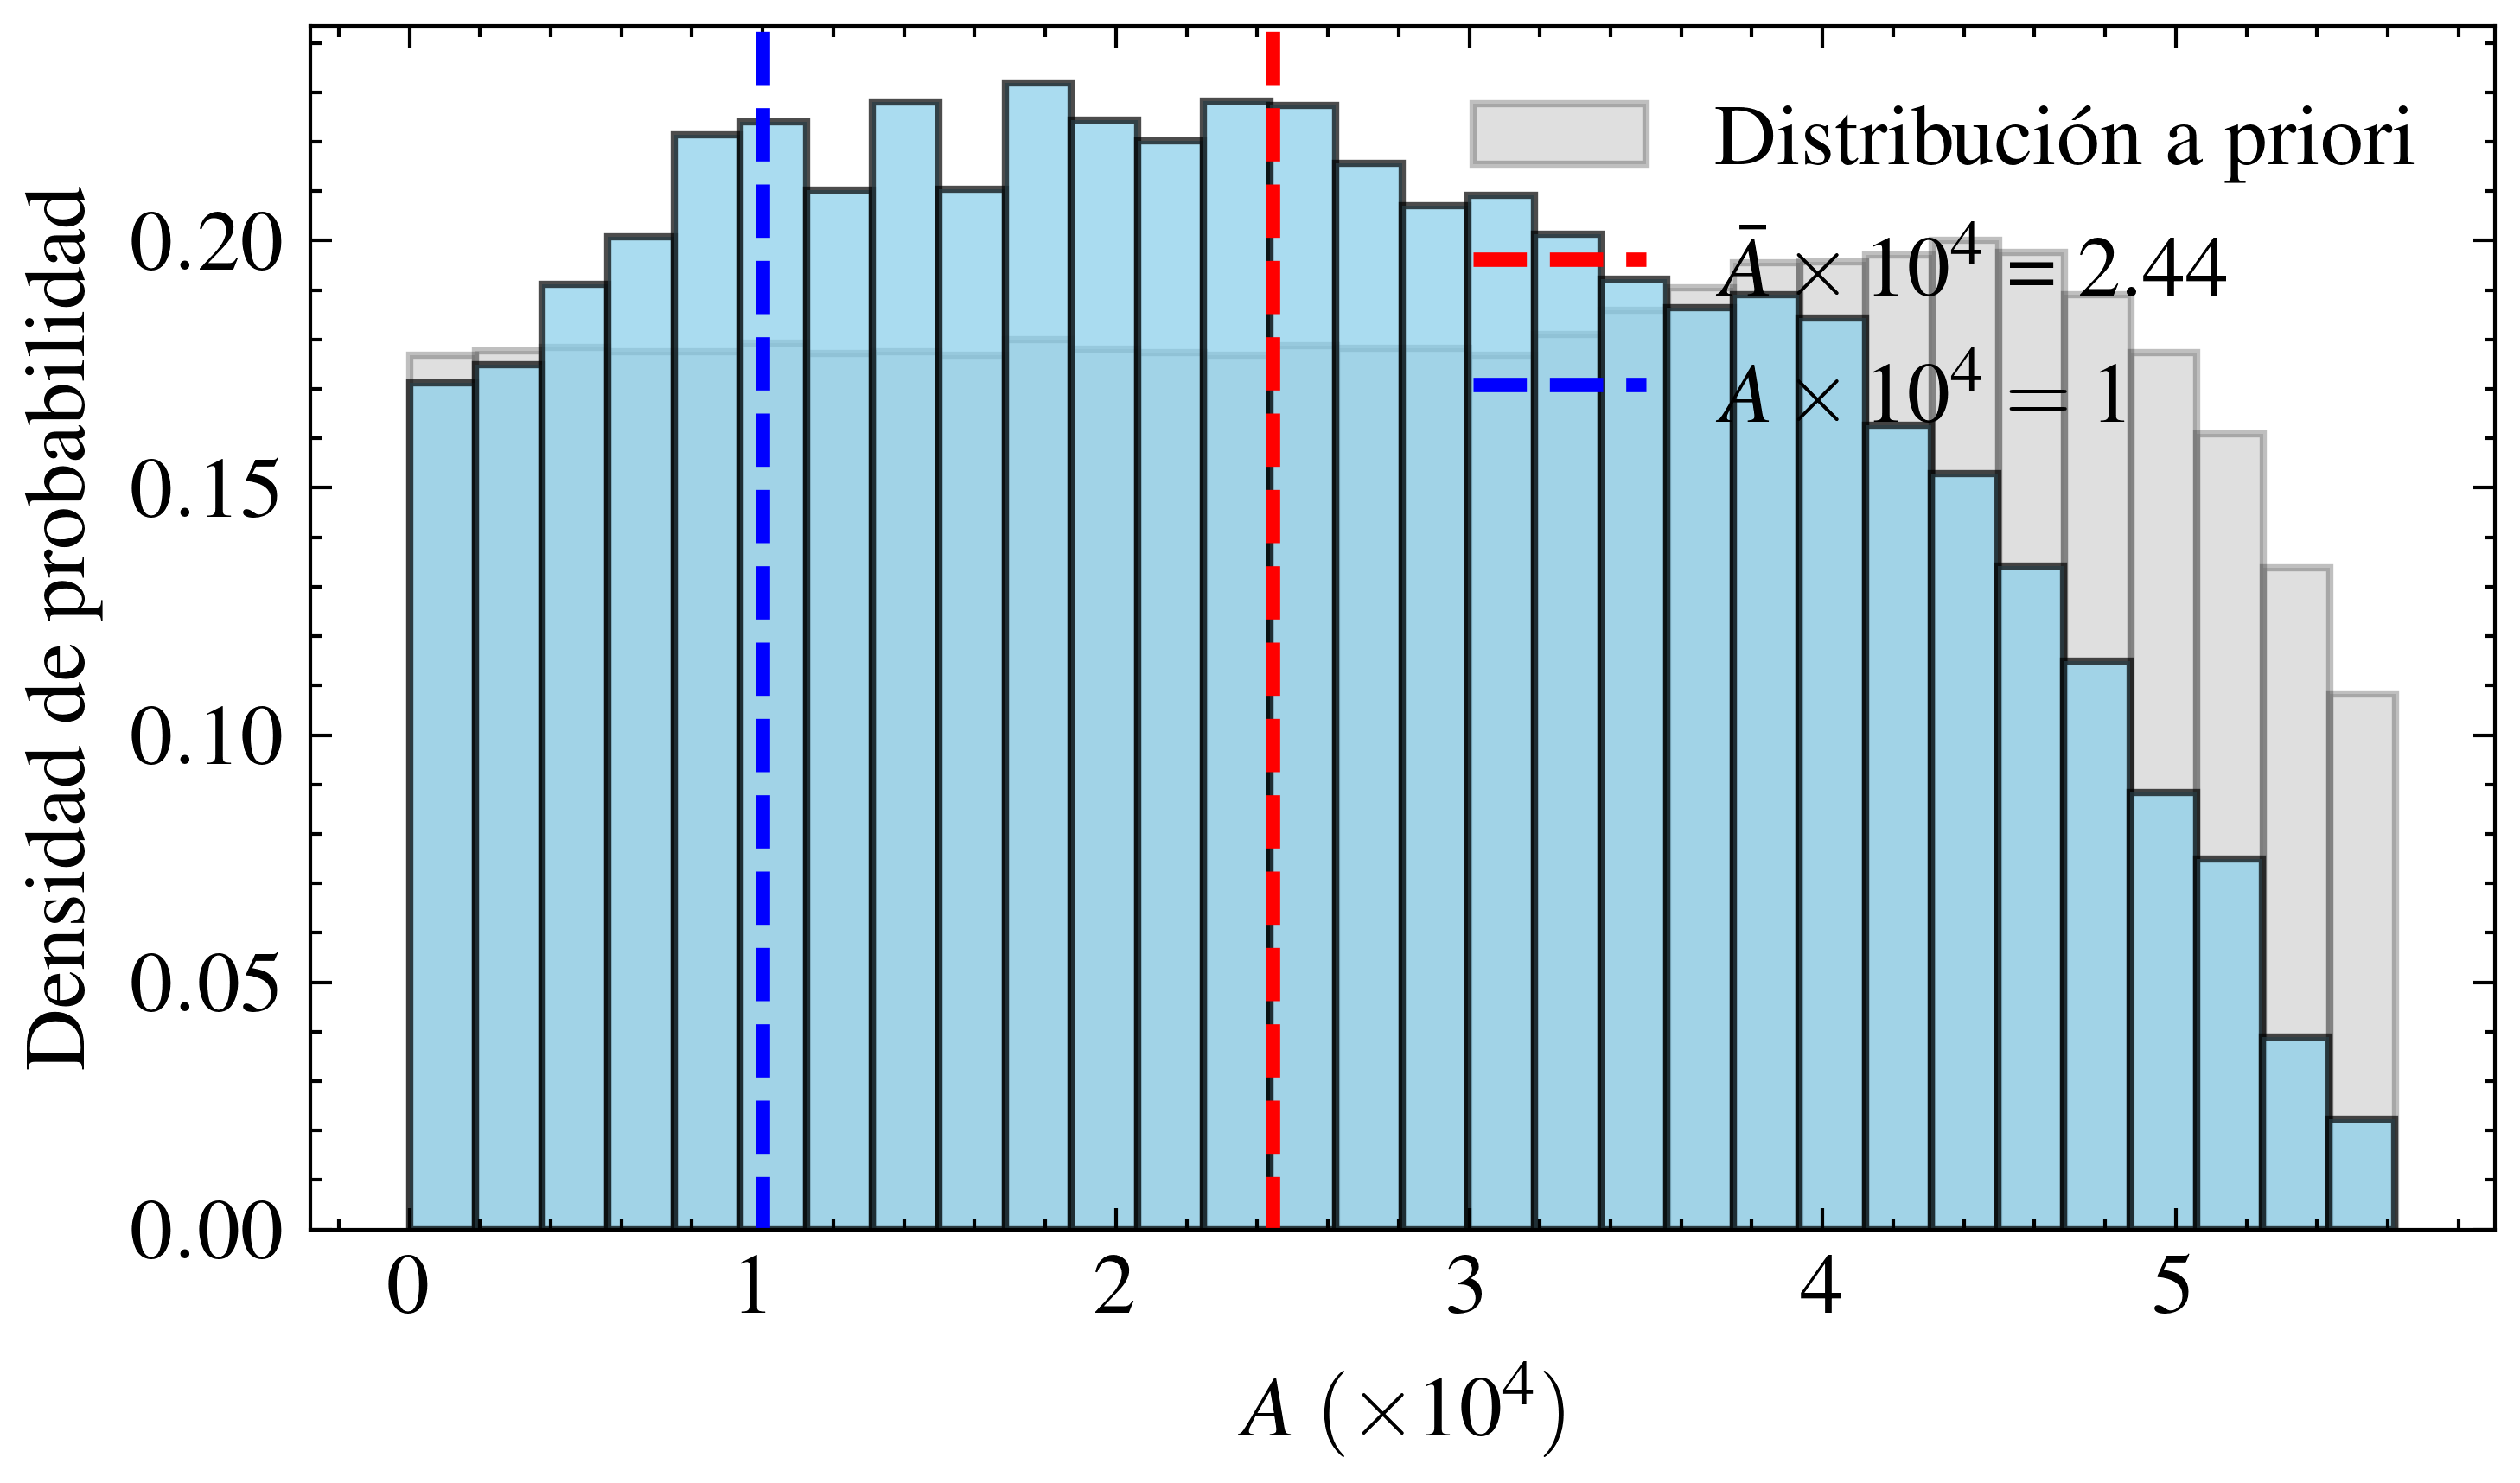

In [12]:
fig, ax = plt.subplots(figsize=(5, 3))

# Histograma original (atrás)
ax.hist(df_completo_2['A'] * 1e4, bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_2['A'] * 1e4, bins=30, alpha=0.7, density=True, edgecolor='black', color='skyblue')
ax.axvline(mejores_10000_2['A'].mean() * 1e4, color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{A}} \\times 10^{4}$ = {mejores_10000_2["A"].mean() * 1e4:.2f}')
ax.axvline(0.0001 * 1e4, color='blue', linestyle='dashed', linewidth=2, label='$A \\times 10^{4} = 1$')
ax.set_xlabel('$A~(\\times 10^{4})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_A_exp2_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

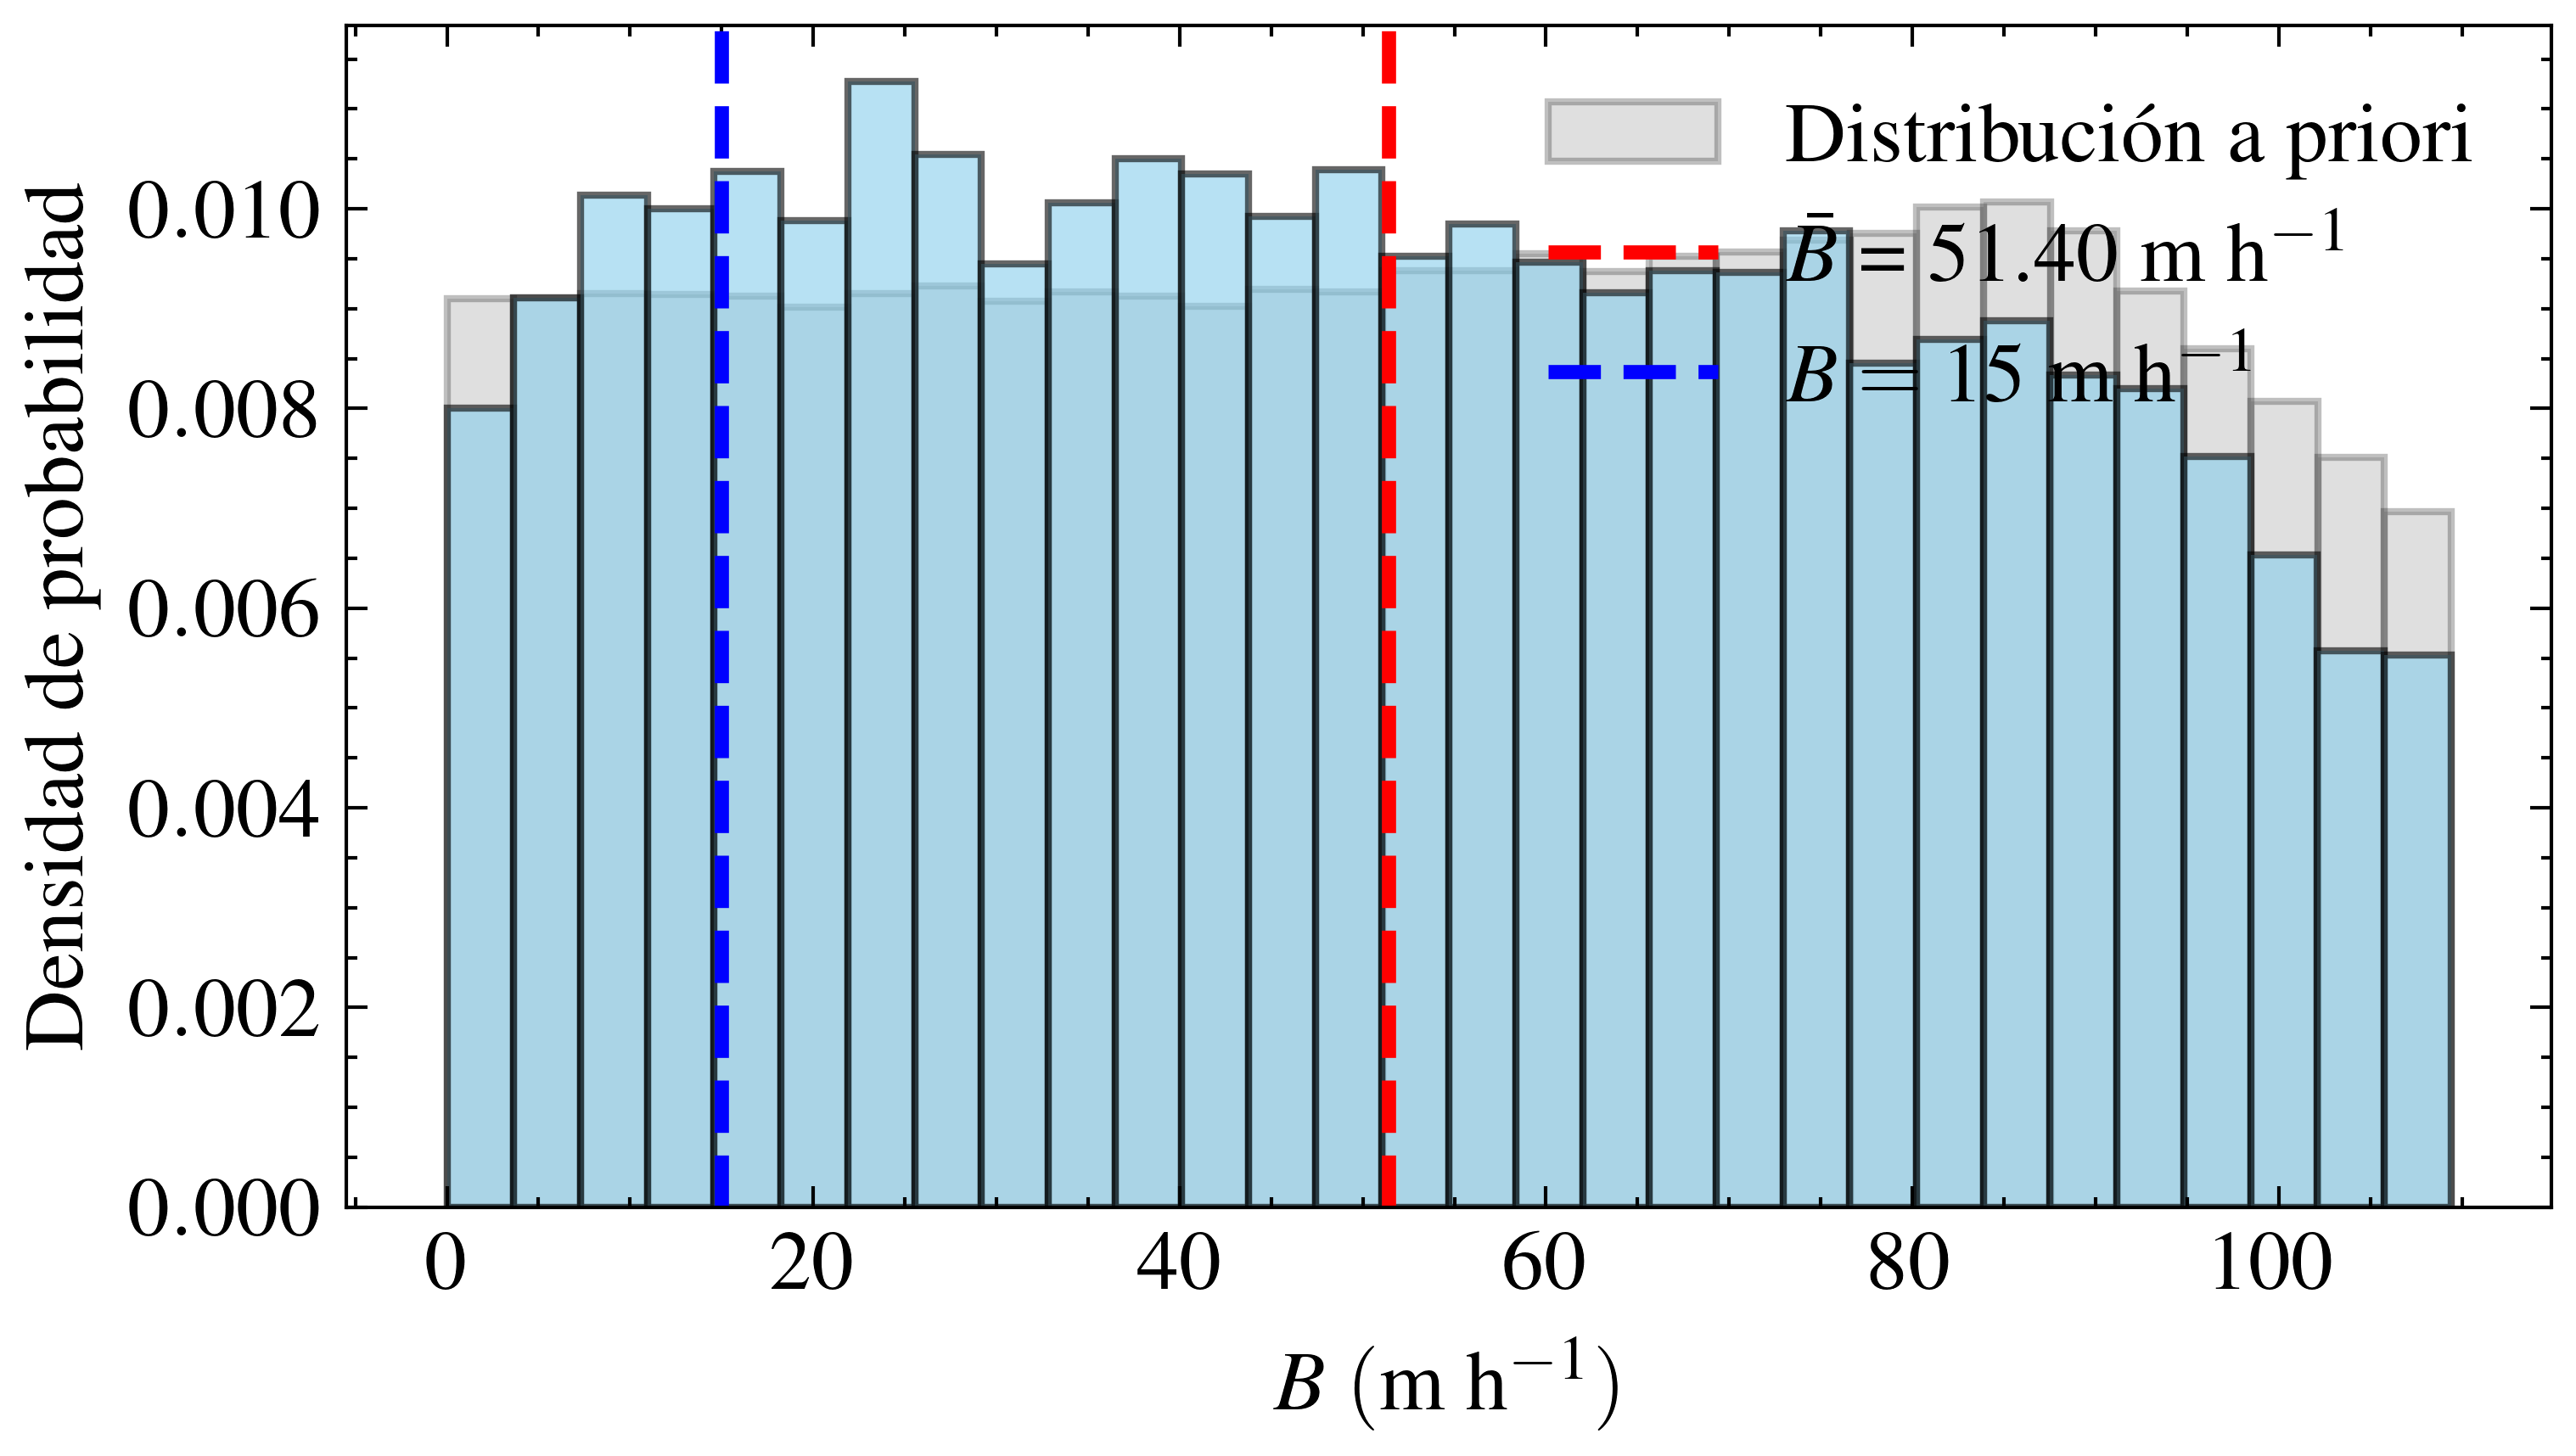

In [13]:
fig, ax = plt.subplots(figsize=(5.2, 3))

ax.hist(df_completo_2['B'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_2['B'], bins=30, alpha=0.6, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_2['B'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{B}}$ = {mejores_10000_2["B"].mean():.2f} $\\mathrm{{m~h^{{-1}}}}$')
ax.axvline(15, color='blue', linestyle='dashed', linewidth=2, label='$B = 15~\\mathrm{m~h^{-1}}$')
ax.set_xlabel('$B~(\\mathrm{m~h^{-1}})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig('hist_B_exp2_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

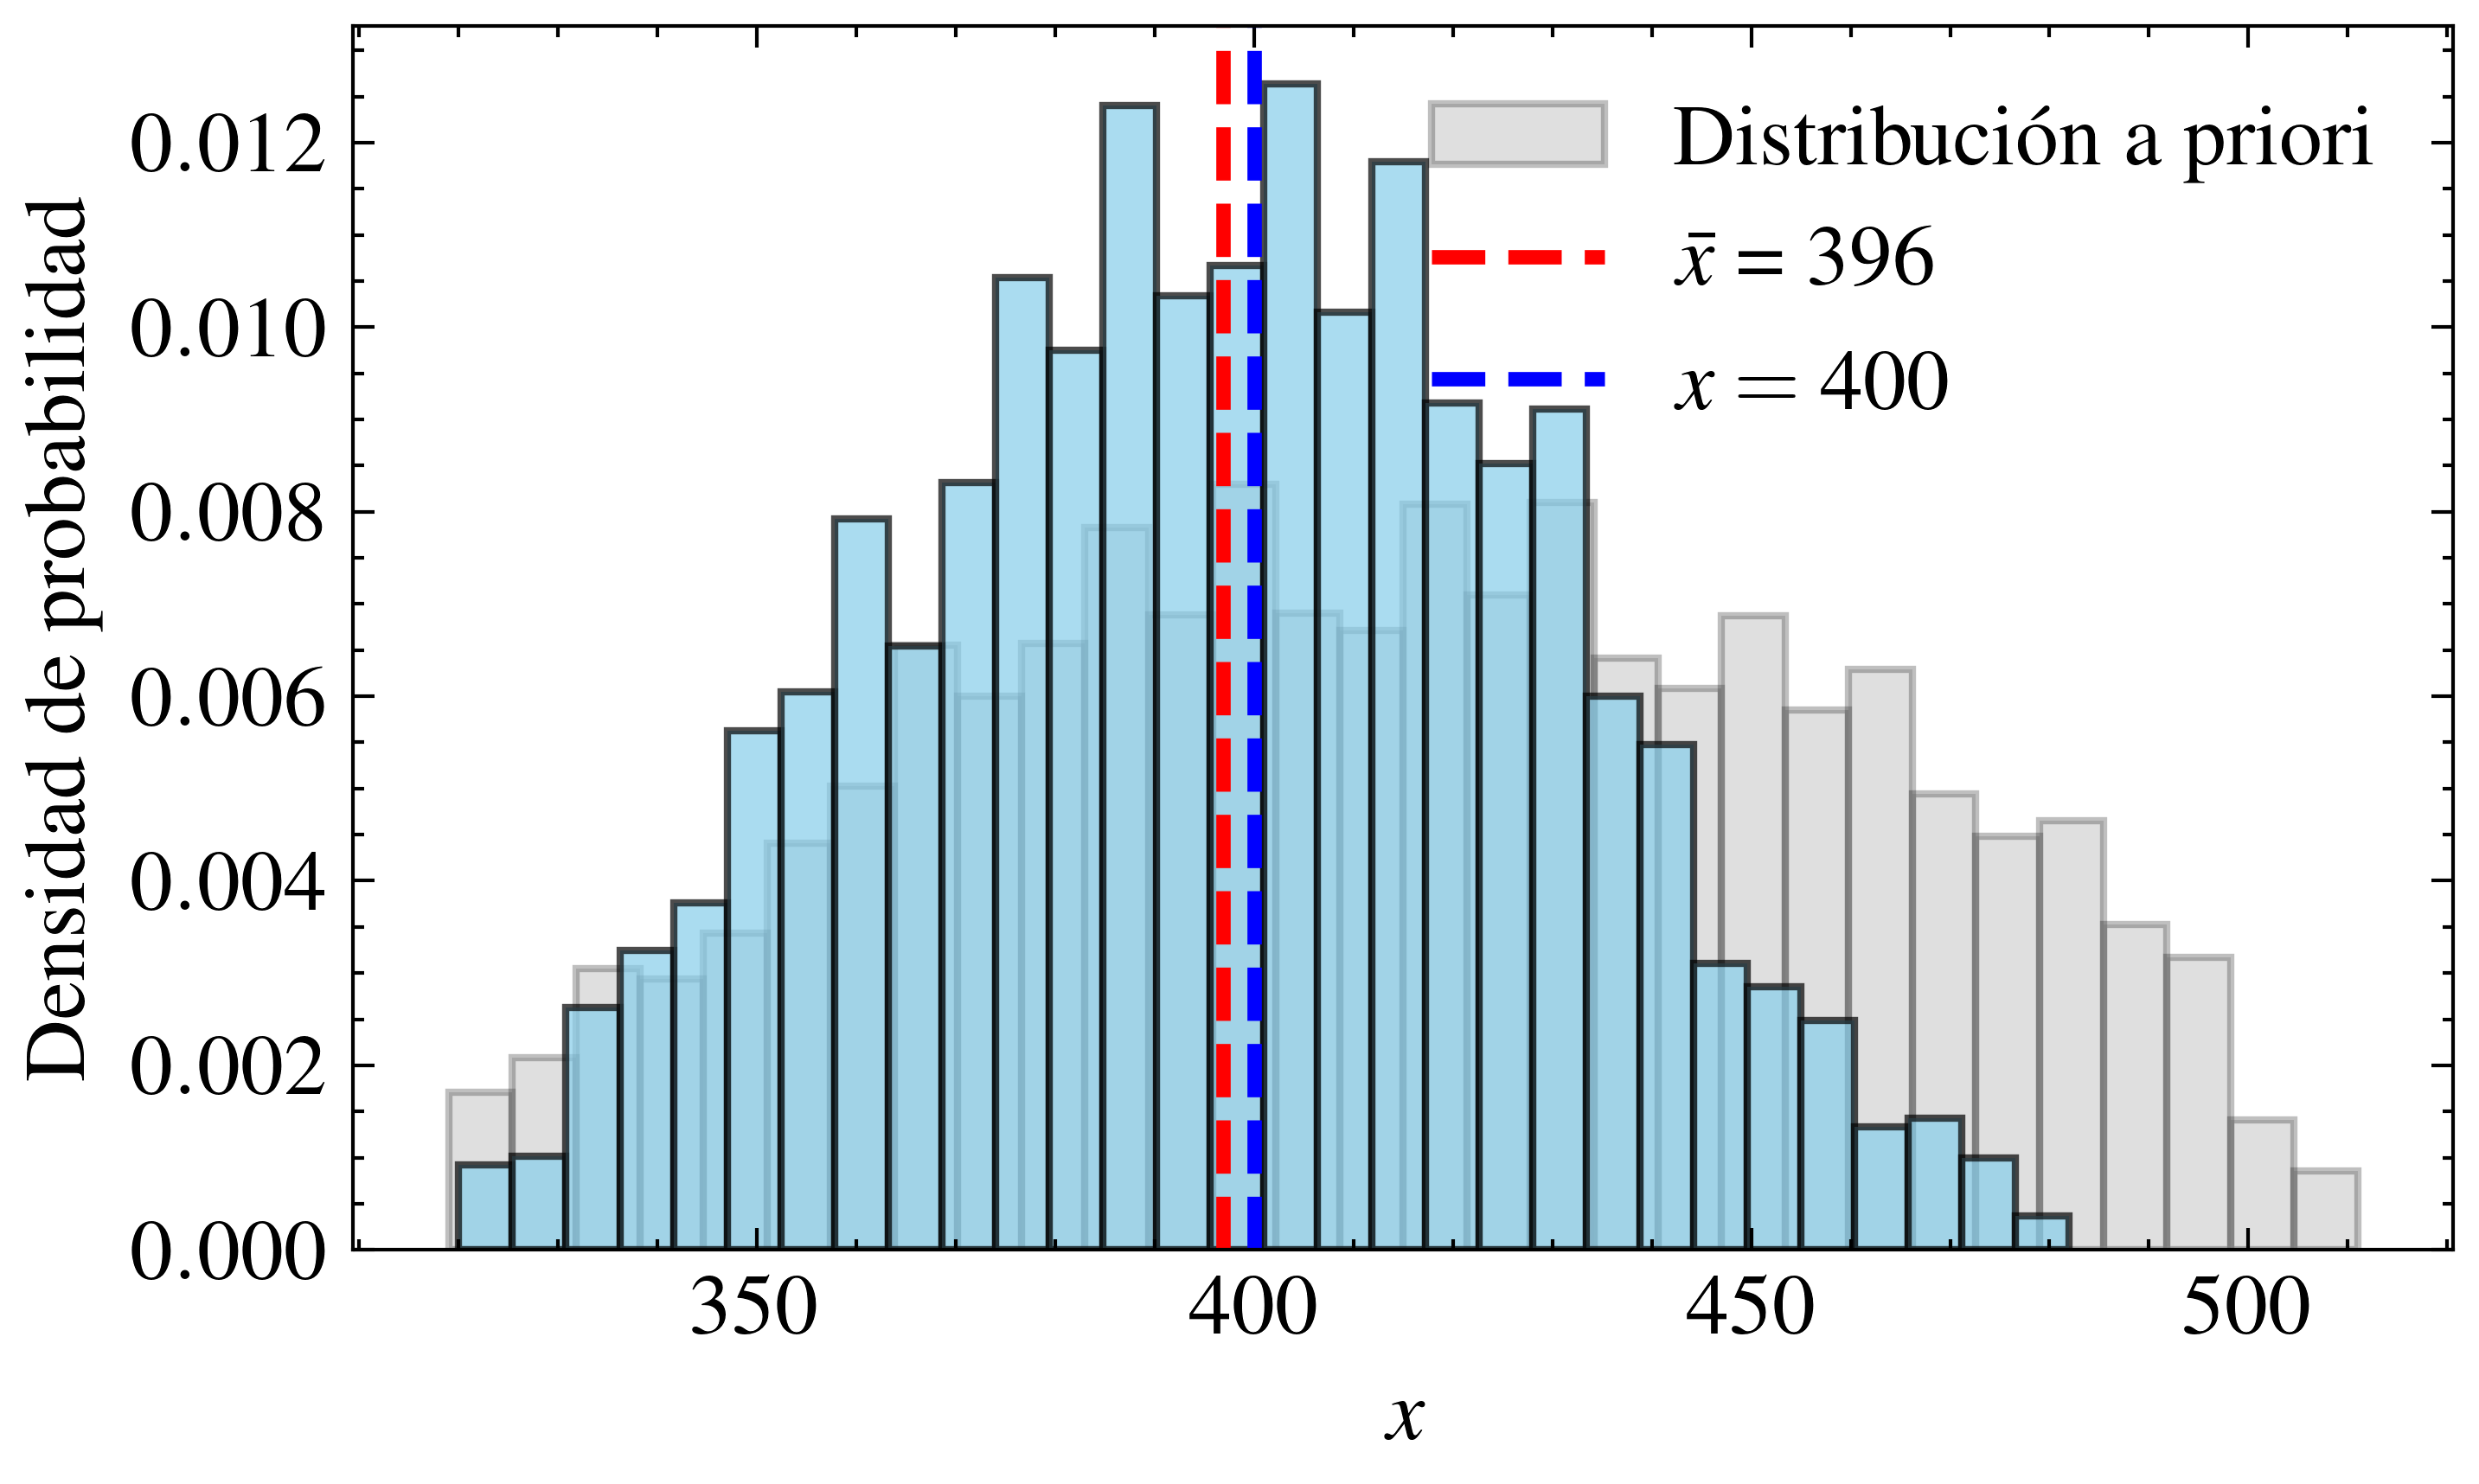

In [14]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_2['x'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_2['x'], bins=30, alpha=0.7, density=True, edgecolor='black', color='skyblue')
ax.axvline(mejores_10000_2['x'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{x}}$ = {int(mejores_10000_2["x"].mean())}')
ax.axvline(400, color='blue', linestyle='dashed', linewidth=2, label='$x = 400$')
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_x_exp2_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

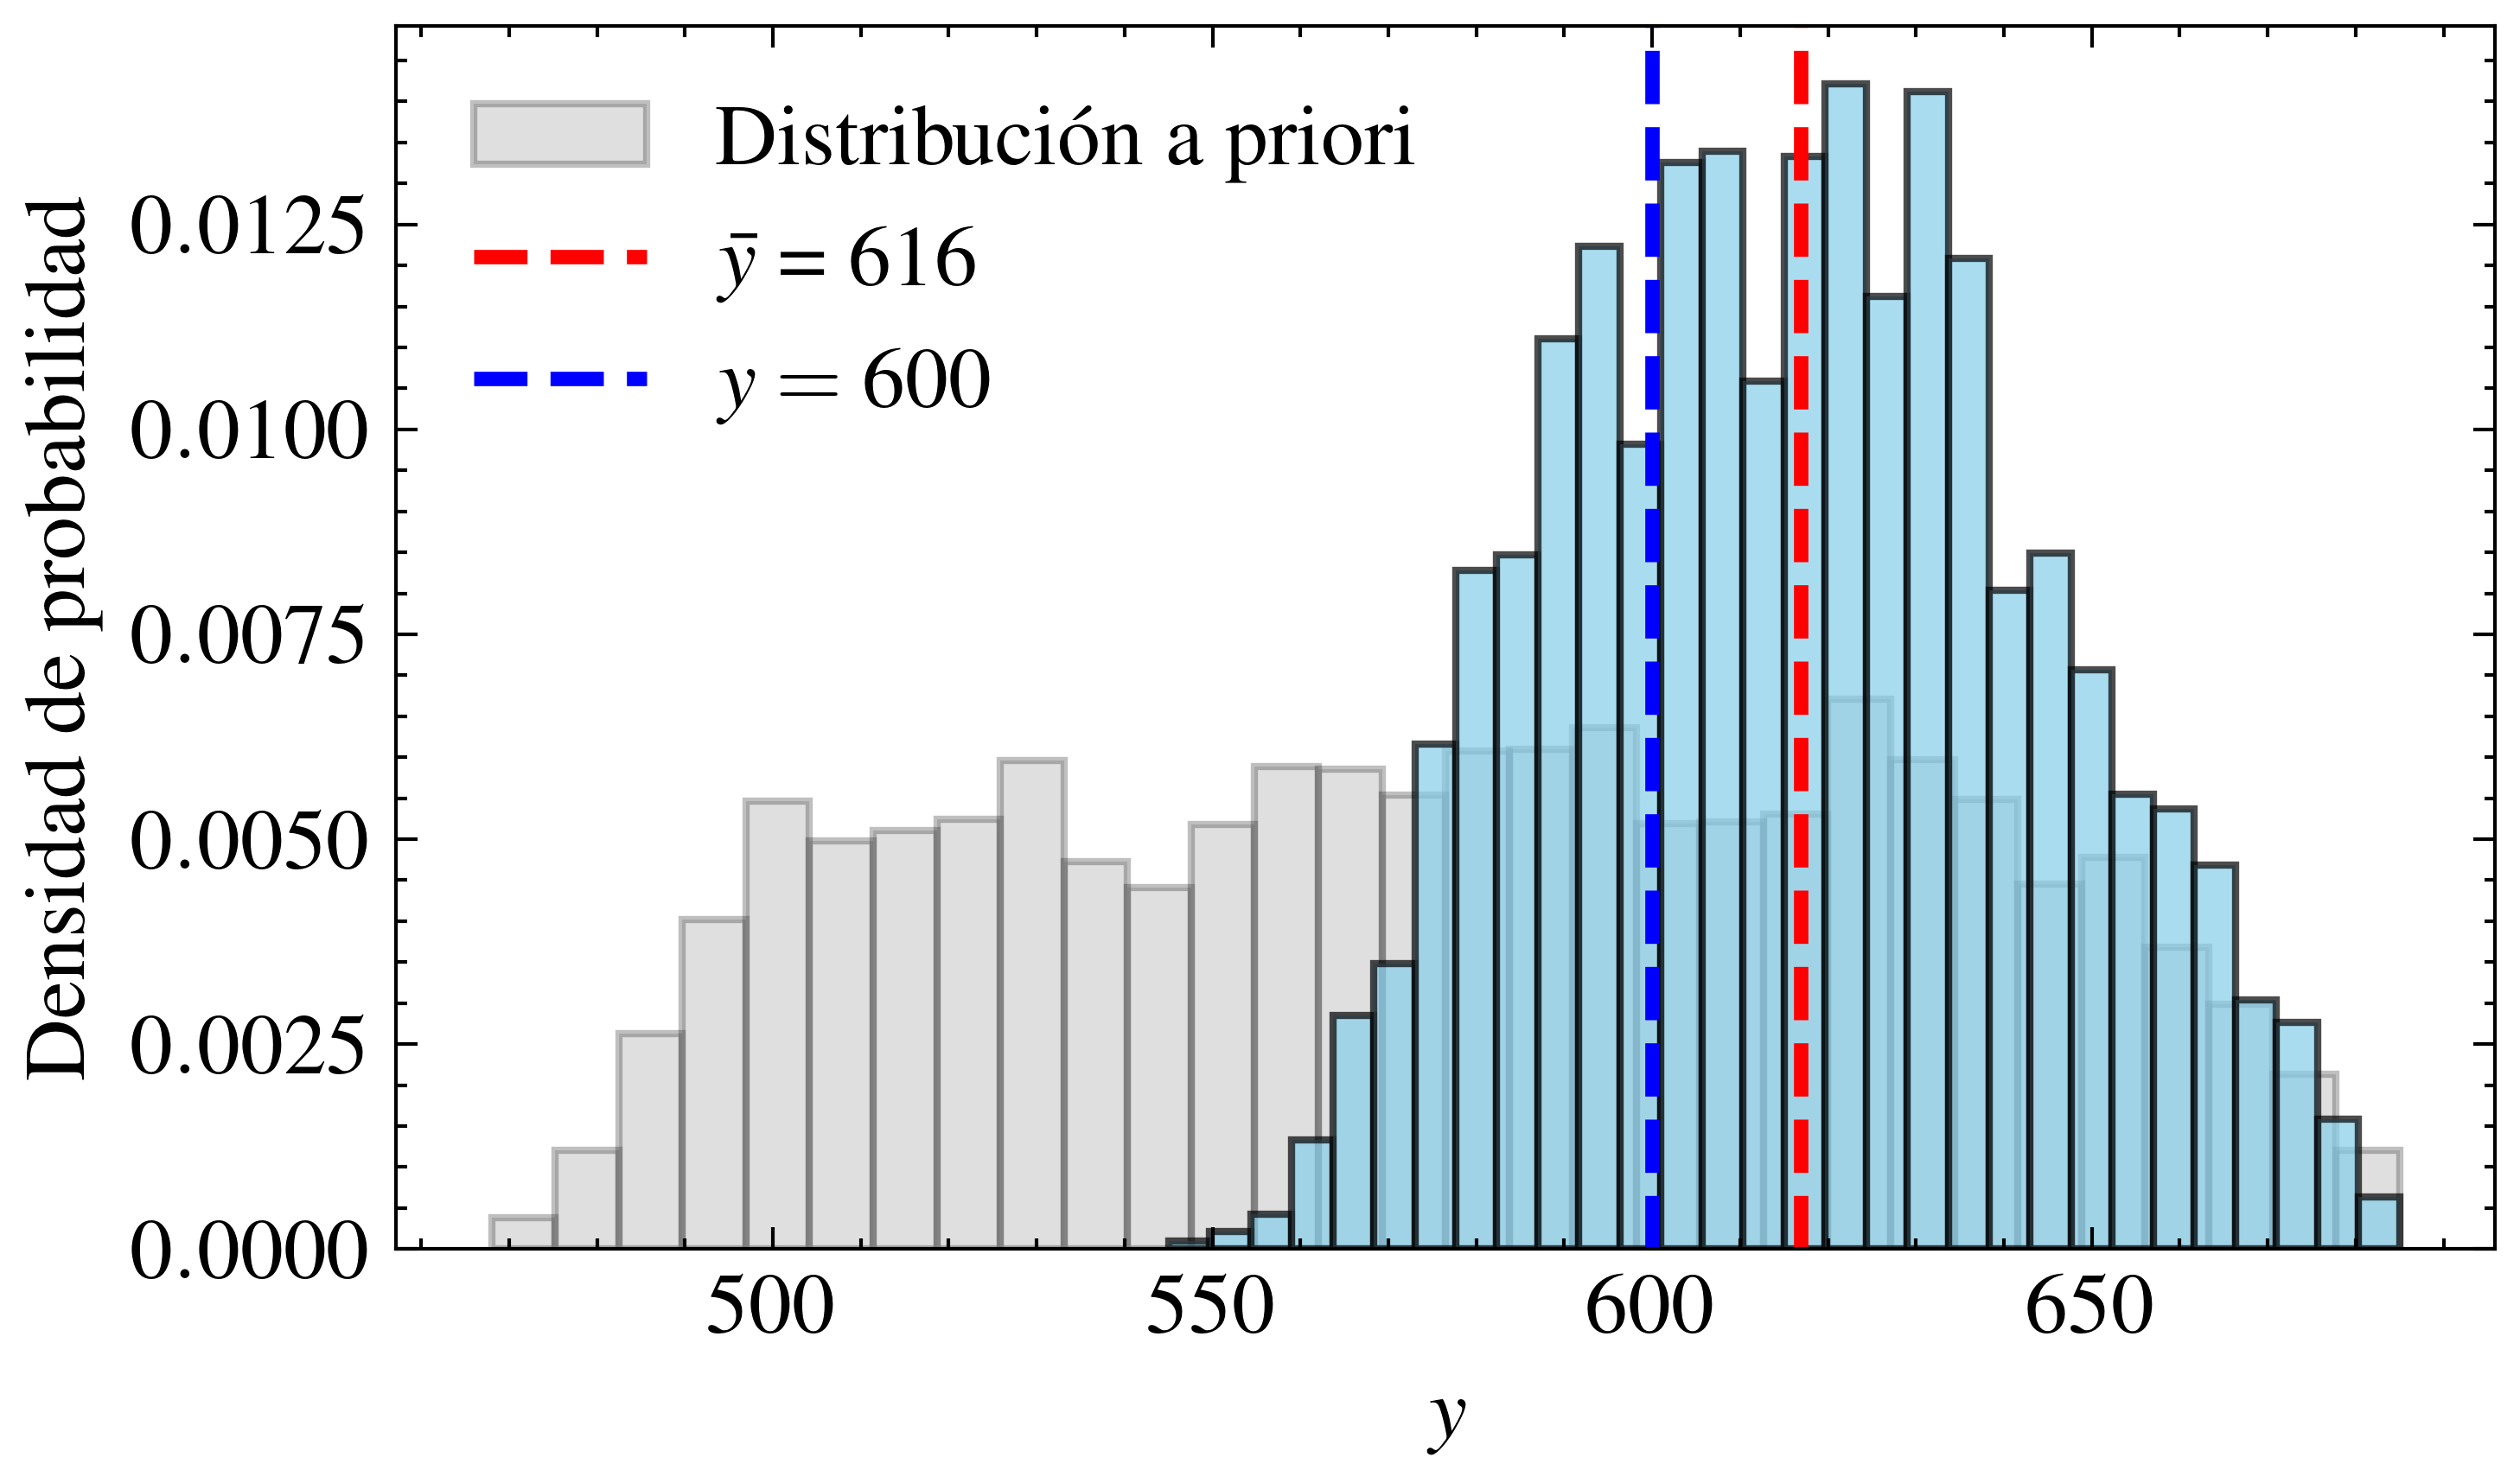

In [15]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_2['y'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_2['y'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_2['y'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{y}}$ = {int(mejores_10000_2["y"].mean())}')
ax.axvline(600, color='blue', linestyle='dashed', linewidth=2, label='$y = 600$')
ax.set_xlabel('$y$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_y_exp2_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

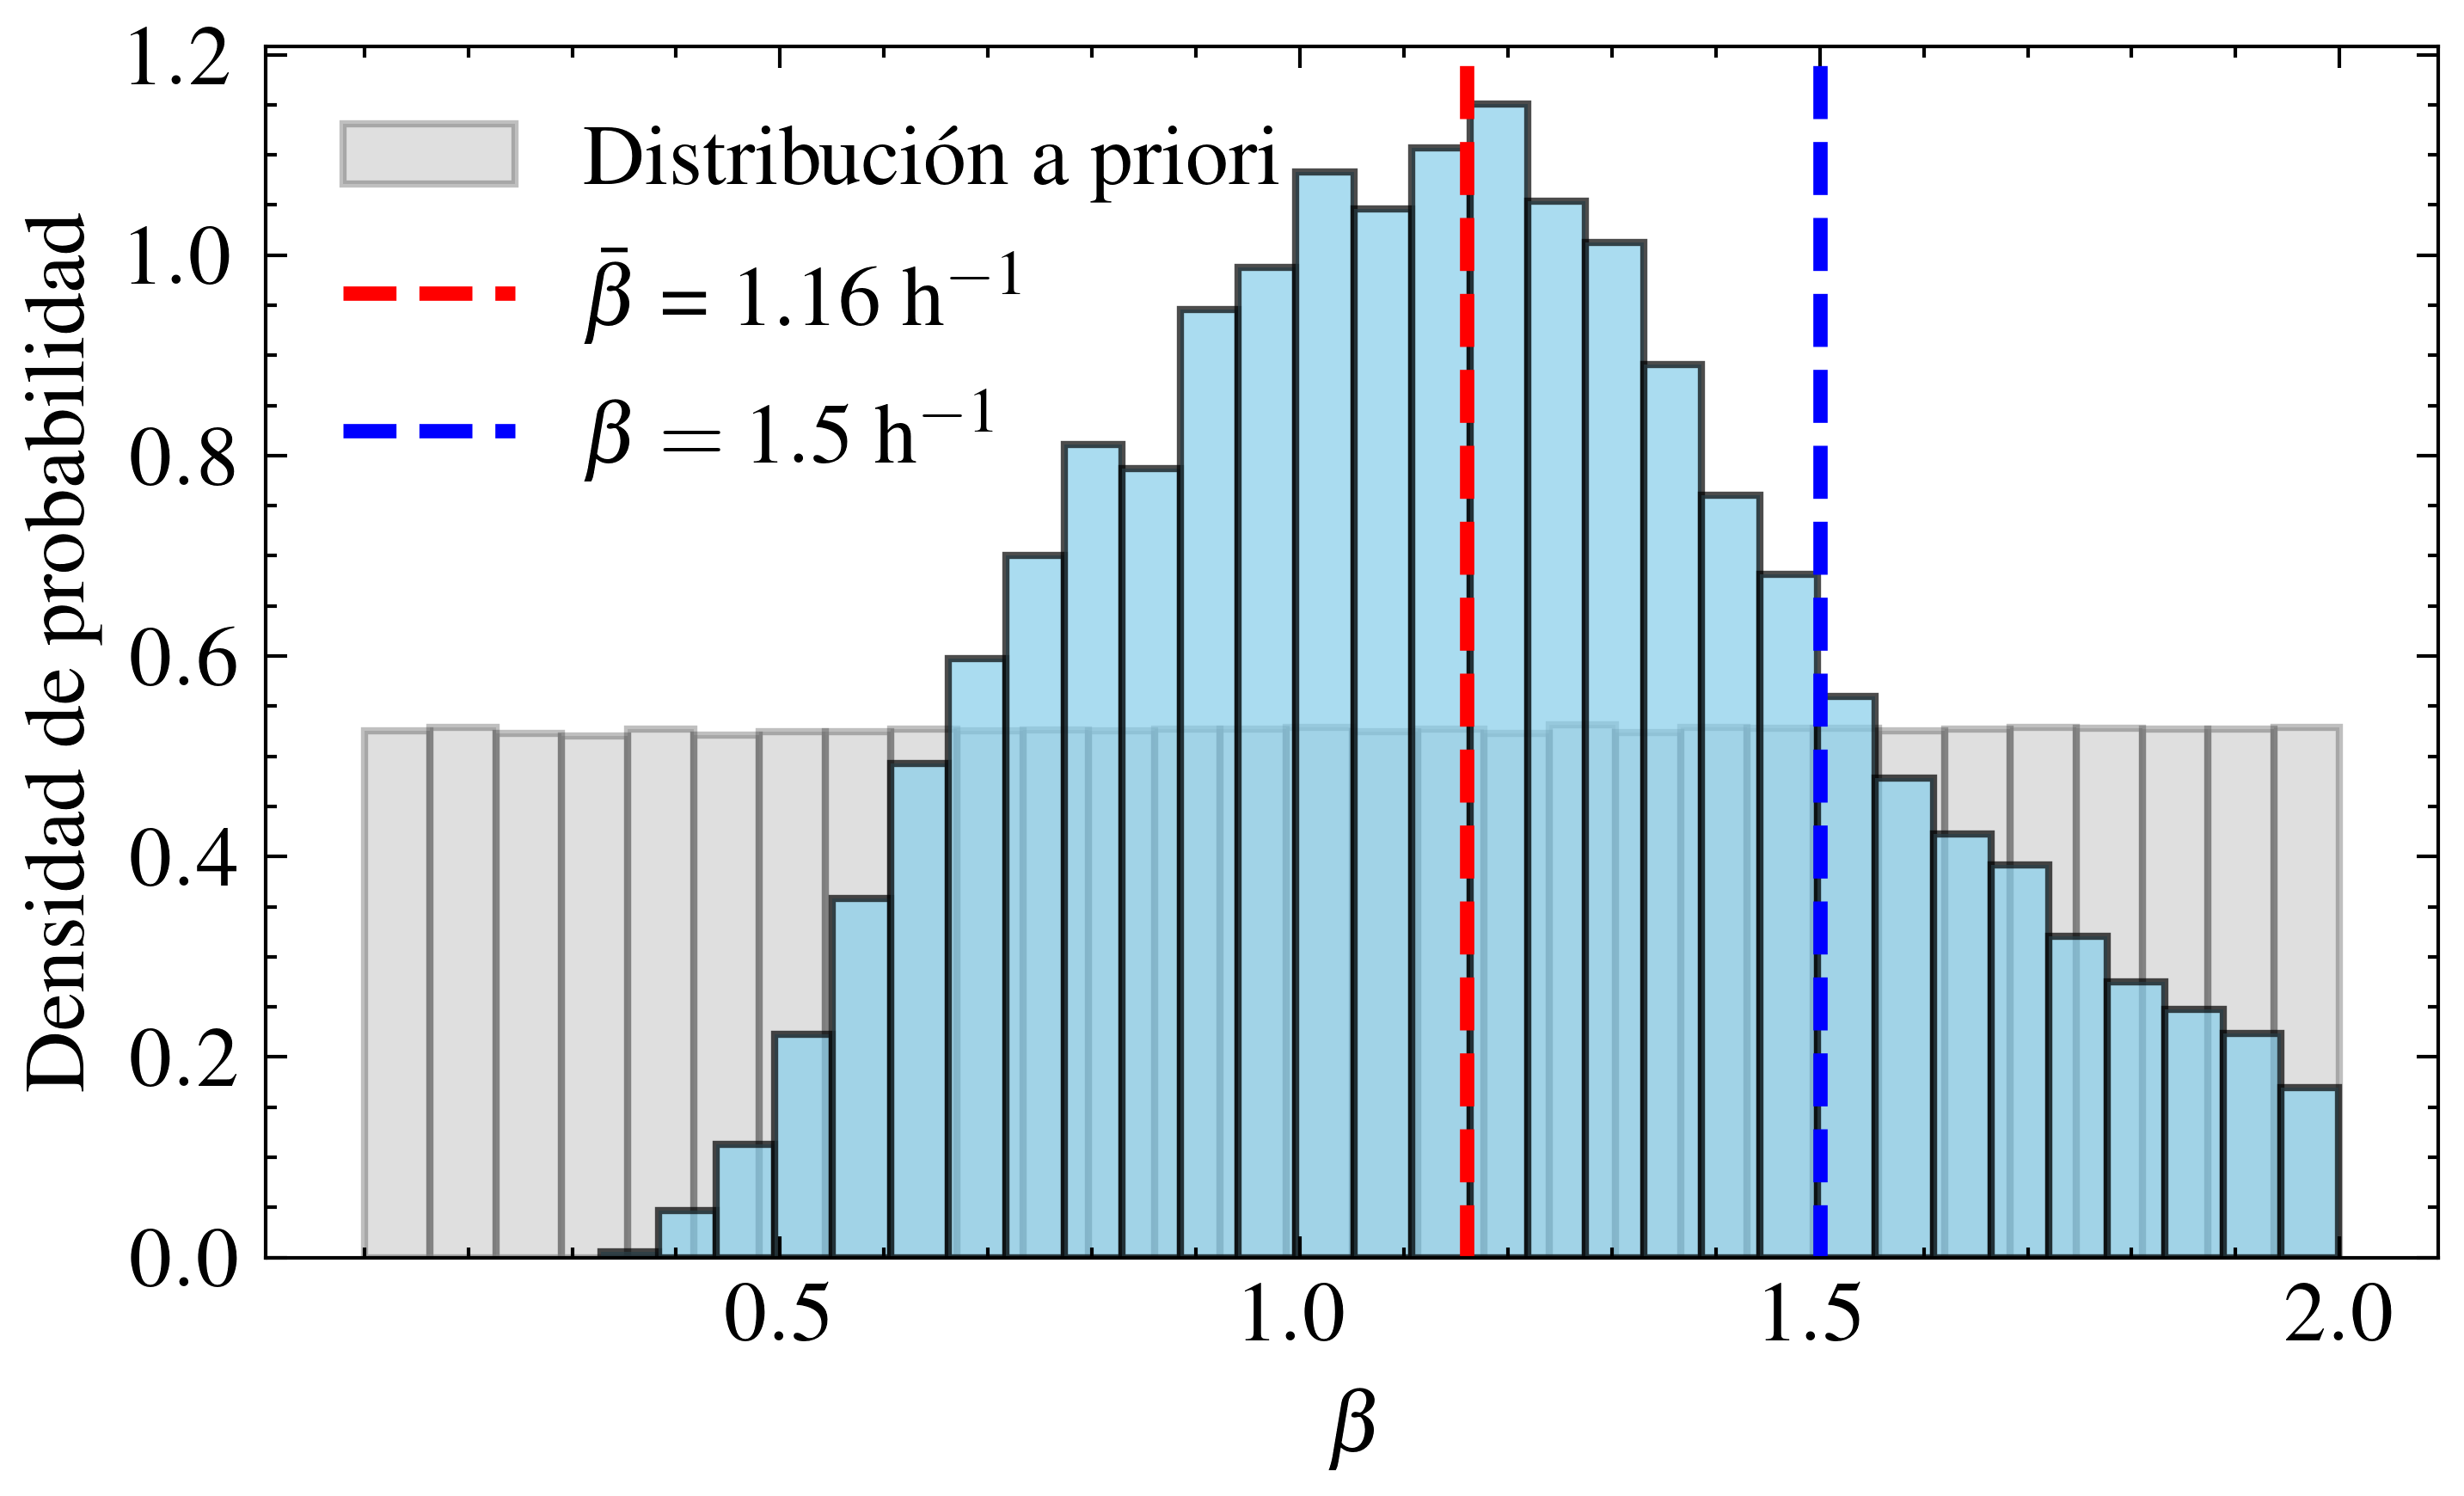

In [16]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_2['beta'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_2['beta'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_2['beta'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_2["beta"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(1.5, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 1.5~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\beta$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_beta_exp2_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

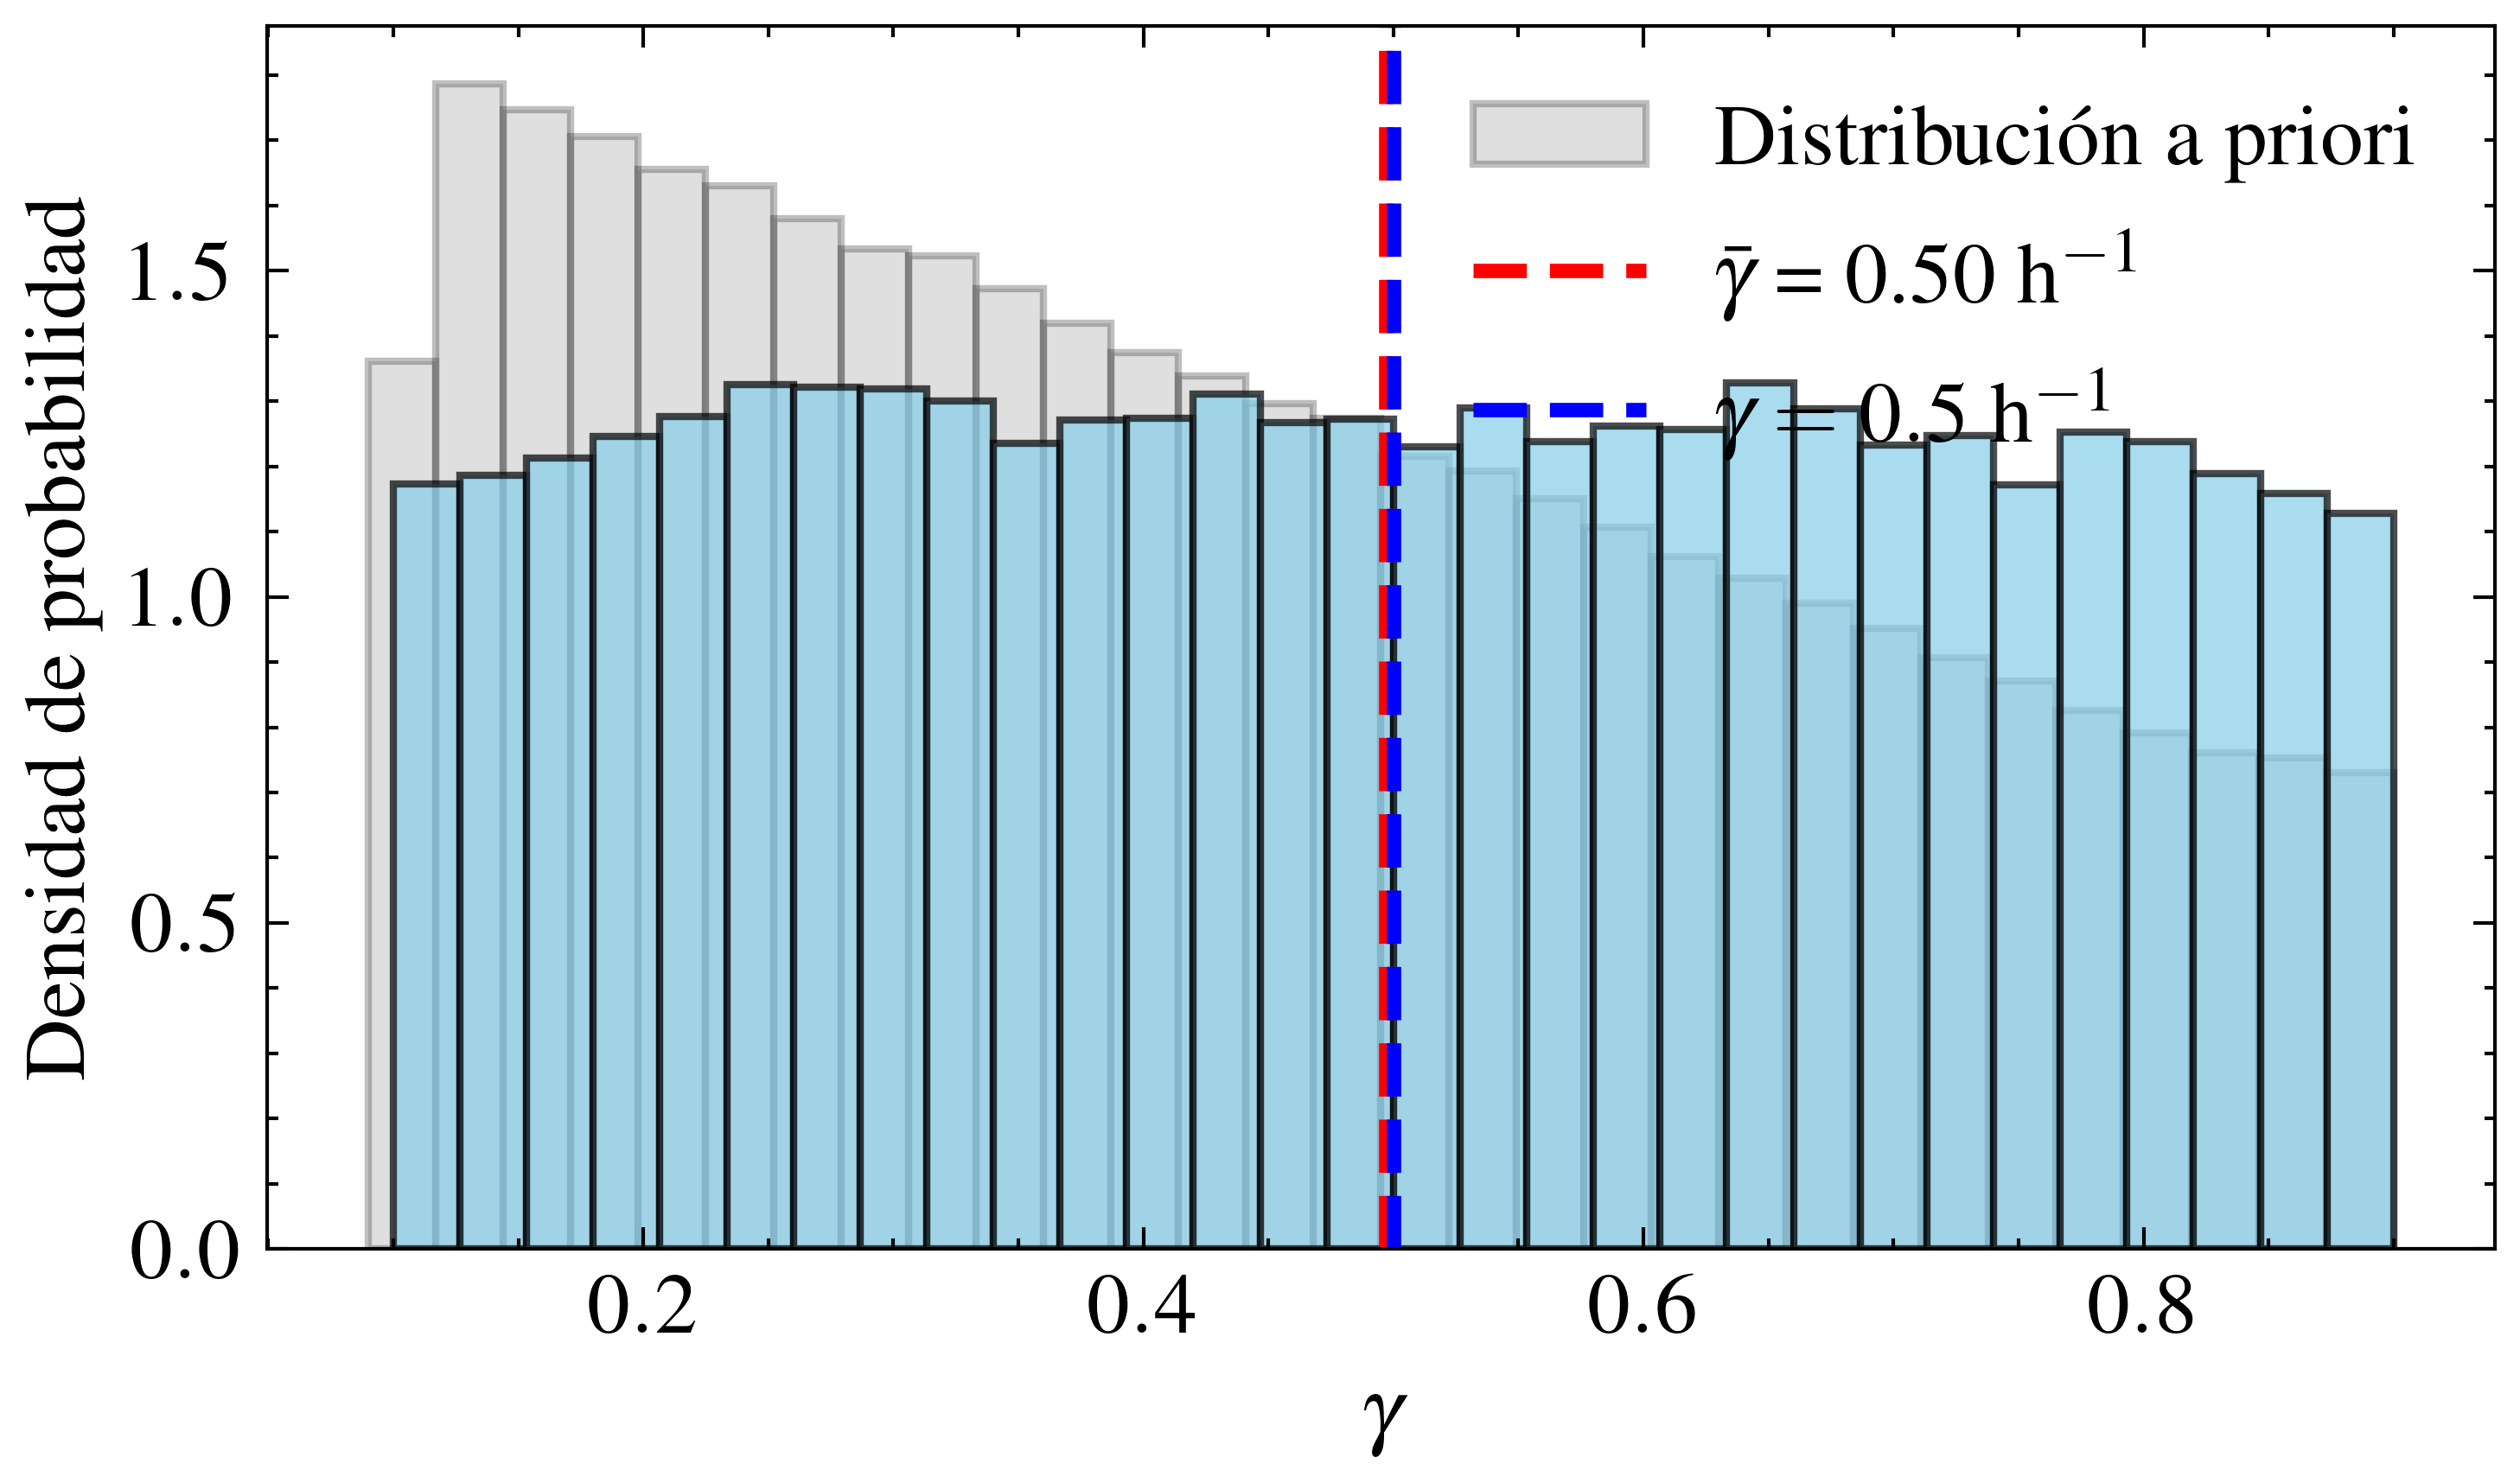

In [17]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_2['gamma'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_2['gamma'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_2['gamma'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\gamma}}$ = {mejores_10000_2["gamma"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.5, color='blue', linestyle='dashed', linewidth=2, label='$\\gamma = 0.5~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\gamma$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_gamma_exp2_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

In [7]:
# Mejor individuo
mejor_individuo_2 = mejores_10000_2.iloc[0]
print("Mejor individuo encontrado:")
print(mejor_individuo_2)

Mejor individuo encontrado:
D           44.4711875916
A            0.0000636124
B           21.1234855652
x          419.0000000000
y          600.0000000000
beta         1.0626628399
gamma        0.5231912732
fitness      0.0329518396
Name: 697701, dtype: float64


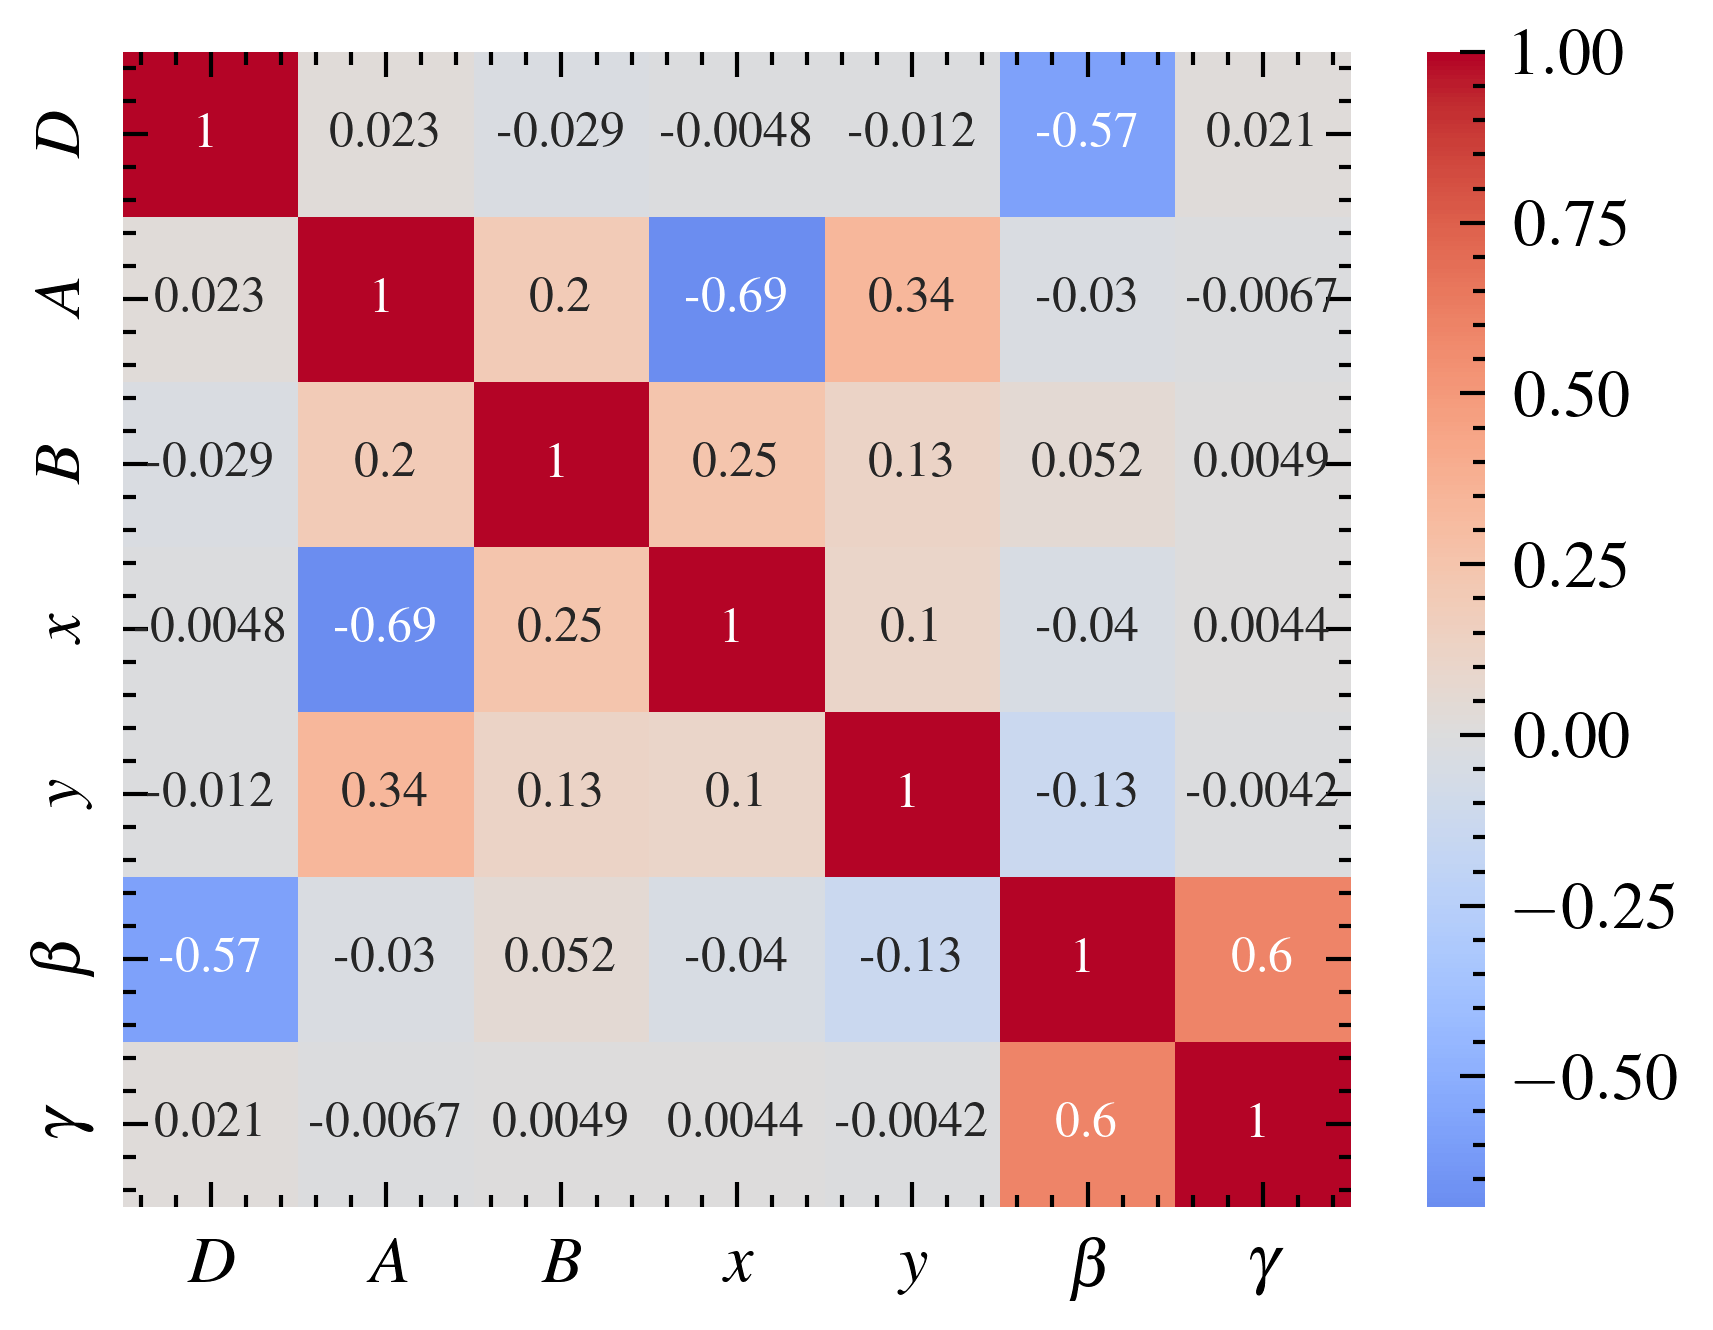

In [19]:
# # --- Opción 1: Matriz de correlación completa ---
mejores_10000_2_para_corr = mejores_10000_2.drop(columns=['fitness'])

xticks = ['$D$', '$A$', '$B$', '$x$', '$y$', '$\\beta$', '$\\gamma$']

plt.figure()
sns.heatmap(
    mejores_10000_2_para_corr.corr(), 
    annot=True, 
    annot_kws={"size": 6},
    cmap="coolwarm", 
    center=0,
    xticklabels=xticks,
    yticklabels=xticks
)
plt.savefig('correlation_matrix_exp2_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Experimento 3

In [20]:
# Ruta a la carpeta que contiene los CSVs
carpeta = "resultados_fuerza_bruta/Resultados_exp3"

# Lista todos los archivos CSV en la carpeta
csv_files = glob.glob(os.path.join(carpeta, "*.csv"))

# Cargá todos los CSVs en una lista de DataFrames
dataframes = [pd.read_csv(f) for f in csv_files]

# Opcional: combiná todos los DataFrames en uno solo
df_completo_3 = pd.concat(dataframes, ignore_index=True)

In [21]:
print("Número total de filas en el DataFrame combinado:", len(df_completo_3))
print(df_completo_3.head())

Número total de filas en el DataFrame combinado: 1030000
               D             A              B        beta_1        beta_2  \
0   6.8616175652  0.0000934252  11.8245439529  0.5606483817  1.8883242607   
1  72.9514617920  0.0005168379  71.5660247803  1.2638107538  0.3392017186   
2  93.8810424805  0.0004906331  74.5213623047  1.3086689711  1.7237281799   
3  94.7594833374  0.0005129990  12.1255235672  0.5745914578  1.8184230328   
4  24.3720912933  0.0004187347  35.7441215515  0.6445202231  0.8502713442   

         beta_3        beta_4        beta_5       gamma_1       gamma_2  \
0  1.9403450489  1.2178105116  1.8167946339  0.5045835376  0.5672330856   
1  1.4758833647  0.1644079387  0.6656987071  0.5840952396  0.3052815497   
2  1.4330739975  1.9572250843  0.7450838685  0.5915413499  0.2108577192   
3  1.2354739904  0.9974271059  1.4199329615  0.5171322823  0.5616450310   
4  0.4018937349  1.8466801643  0.7192224264  0.1054358855  0.3068734407   

        gamma_3       gamma_4

In [22]:
df_ordenado_3 = df_completo_3.sort_values(by='fitness')
# mejores_10000 = df_ordenado.head(10000)
# Seleccionamos los que tengan fitness menor a 0.1
mejores_10000_3 = df_ordenado_3[df_ordenado_3['fitness'] < 0.3]
print("Número de individuos con fitness menor a 0.1:", len(mejores_10000_3))
print(mejores_10000_3)

Número de individuos con fitness menor a 0.1: 3124
                     D             A              B        beta_1  \
67450     9.9001455307  0.0001118979  21.1600170135  1.3841999769   
145583   95.6099319458  0.0001289079   1.3745106459  0.5375463963   
958419   22.6000862122  0.0001262134   6.0274596214  0.5762428045   
888707   46.2650947571  0.0001204013  20.5229701996  0.7814912796   
1029197  15.7870855331  0.0000863871  16.0486717224  0.6728015542   
...                ...           ...            ...           ...   
630935   54.4778785706  0.0005068236  45.9259414673  1.8032225370   
664300   41.6754570007  0.0001523013  22.7123050690  0.9329468012   
1022323  96.5588302612  0.0004473538   2.9972605705  0.7907682061   
497604   82.2388153076  0.0004722350  77.1389236450  1.7367638350   
226092   73.5951766968  0.0003116588   1.0110054016  1.8825410604   

               beta_2        beta_3        beta_4        beta_5       gamma_1  \
67450    1.0604500771  1.3349727392  1.

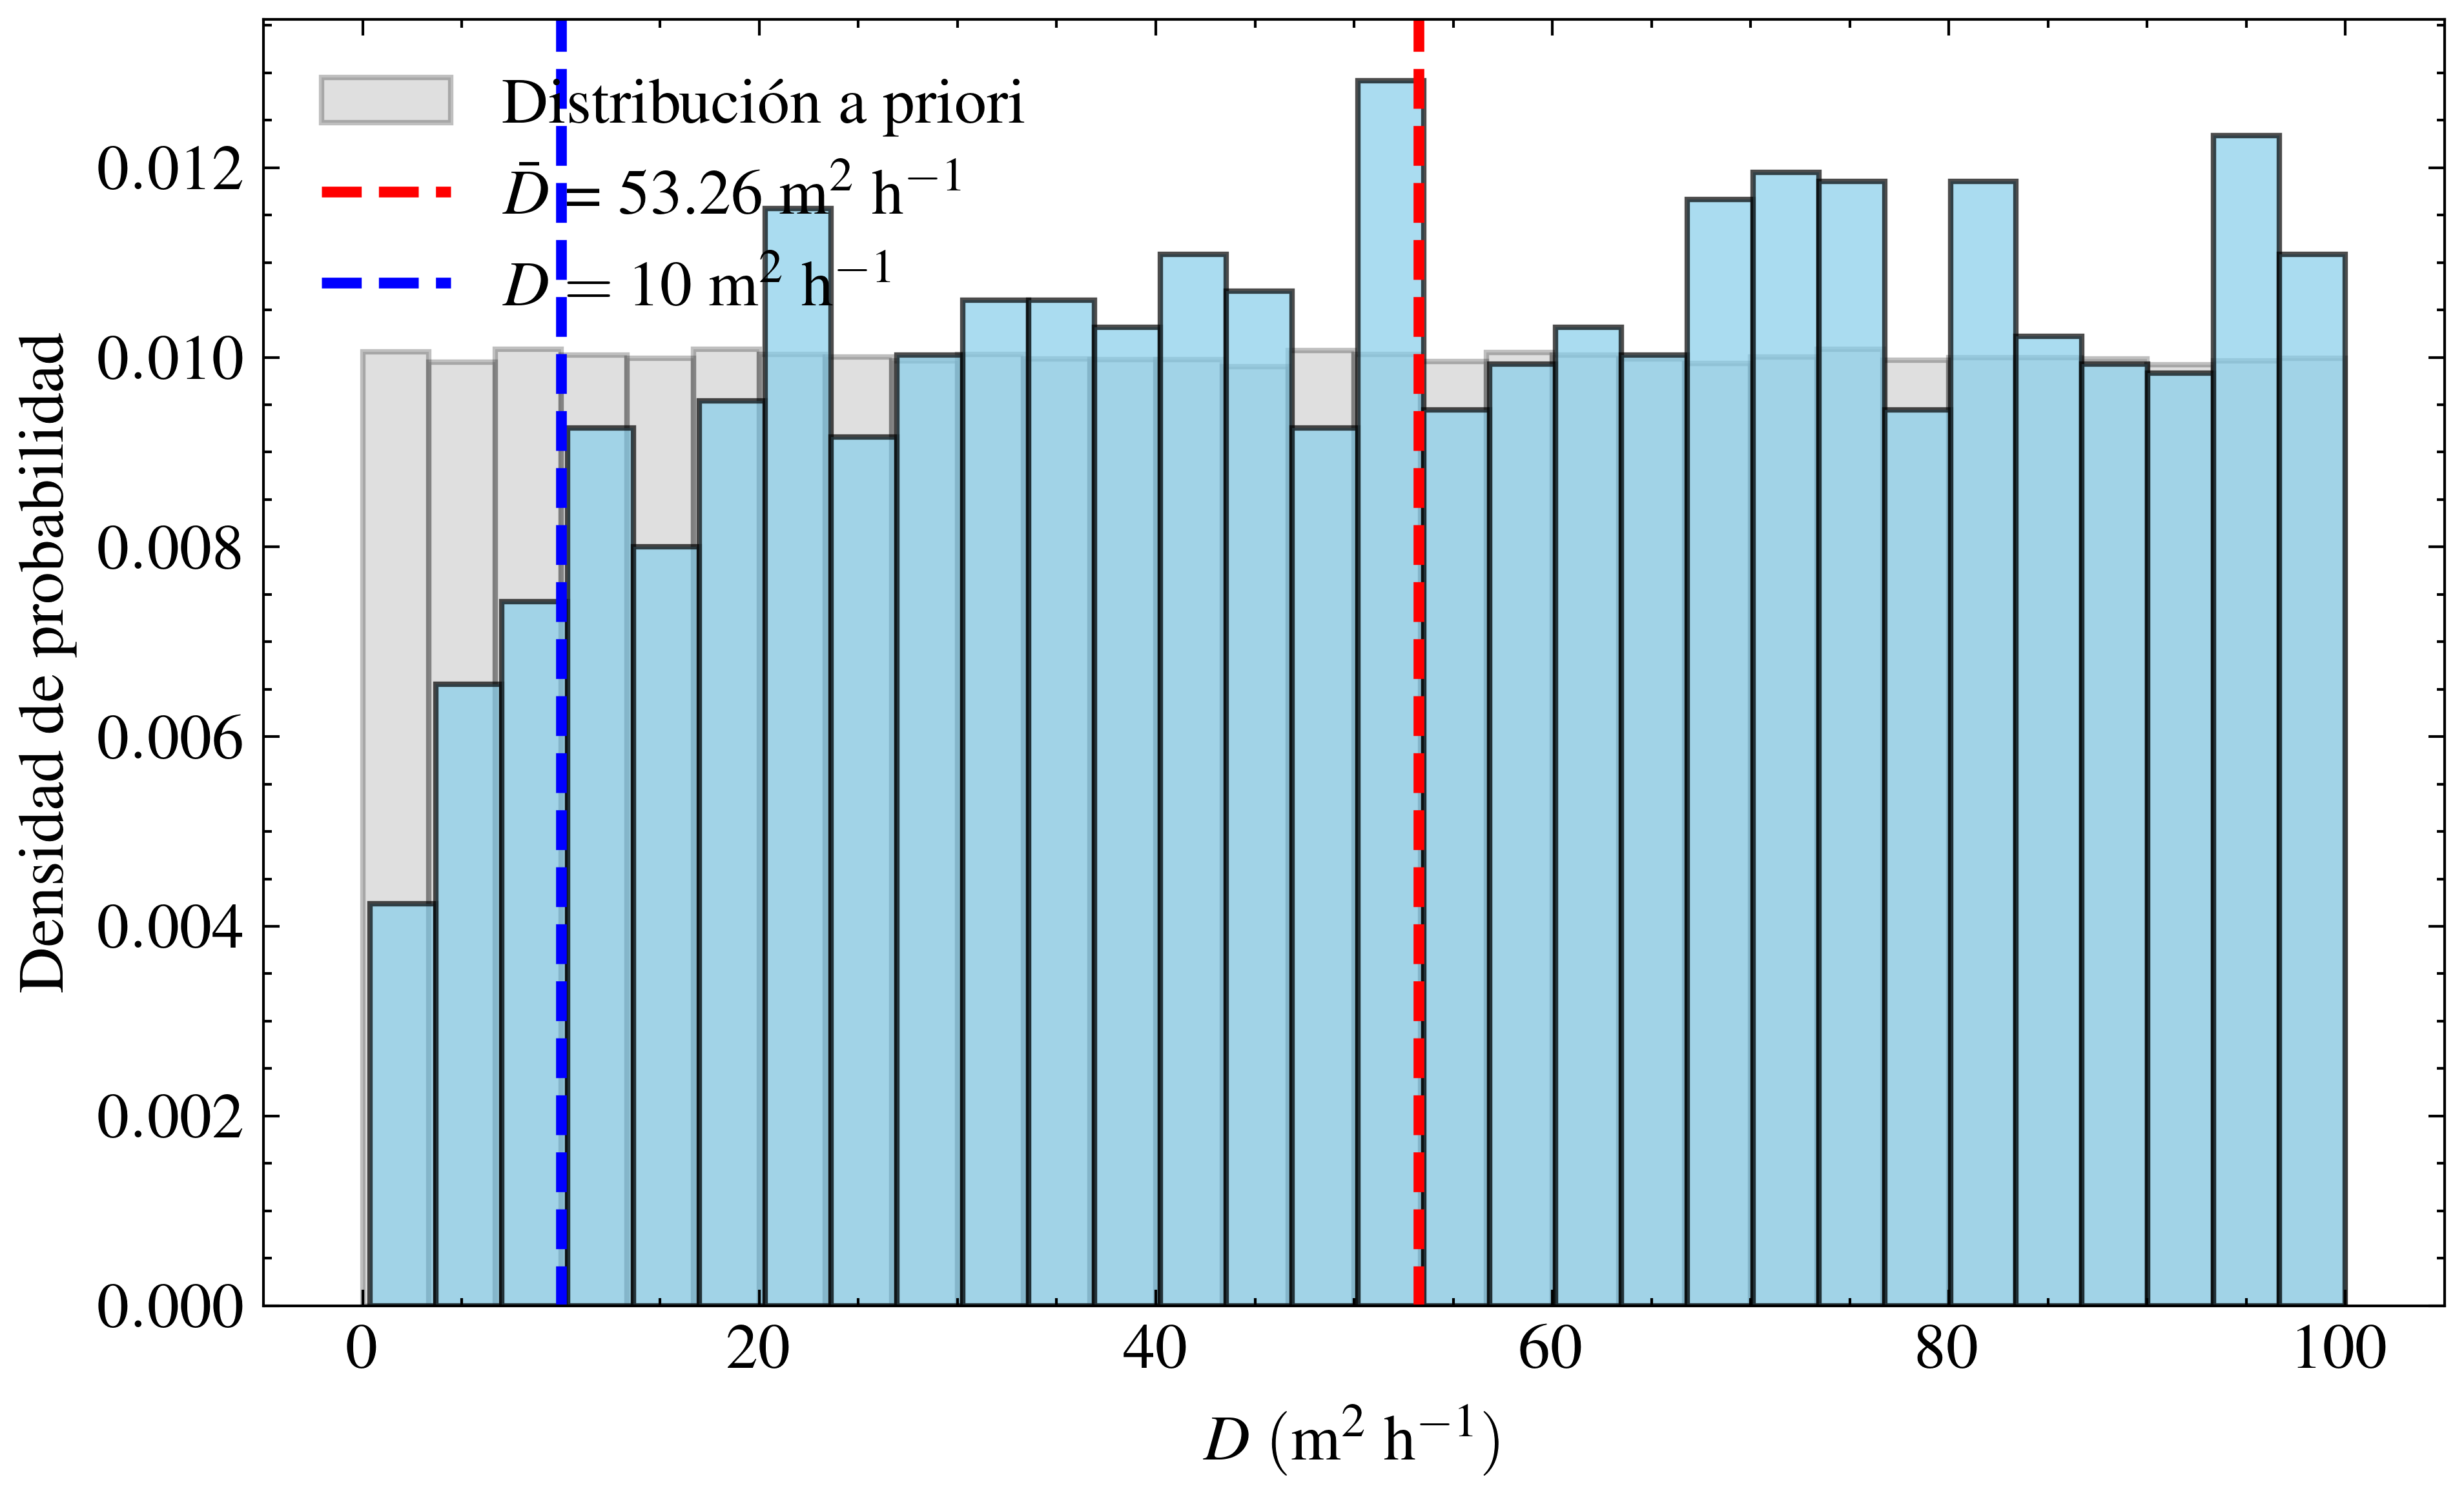

In [45]:
fig, ax = plt.subplots(figsize=(6.5, 4))

ax.hist(df_completo_3['D'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['D'], bins=30, alpha=0.7, density=True, edgecolor='black', color='skyblue')
ax.axvline(mejores_10000_3['D'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{D}}$ = {mejores_10000_3["D"].mean():.2f} $\\mathrm{{m^2~h^{{-1}}}}$')
ax.axvline(10, color='blue', linestyle='dashed', linewidth=2, label='$D = 10~\\mathrm{m^2~h^{-1}}$')
ax.set_xlabel('$D~(\\mathrm{m^2~h^{-1}})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_D_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

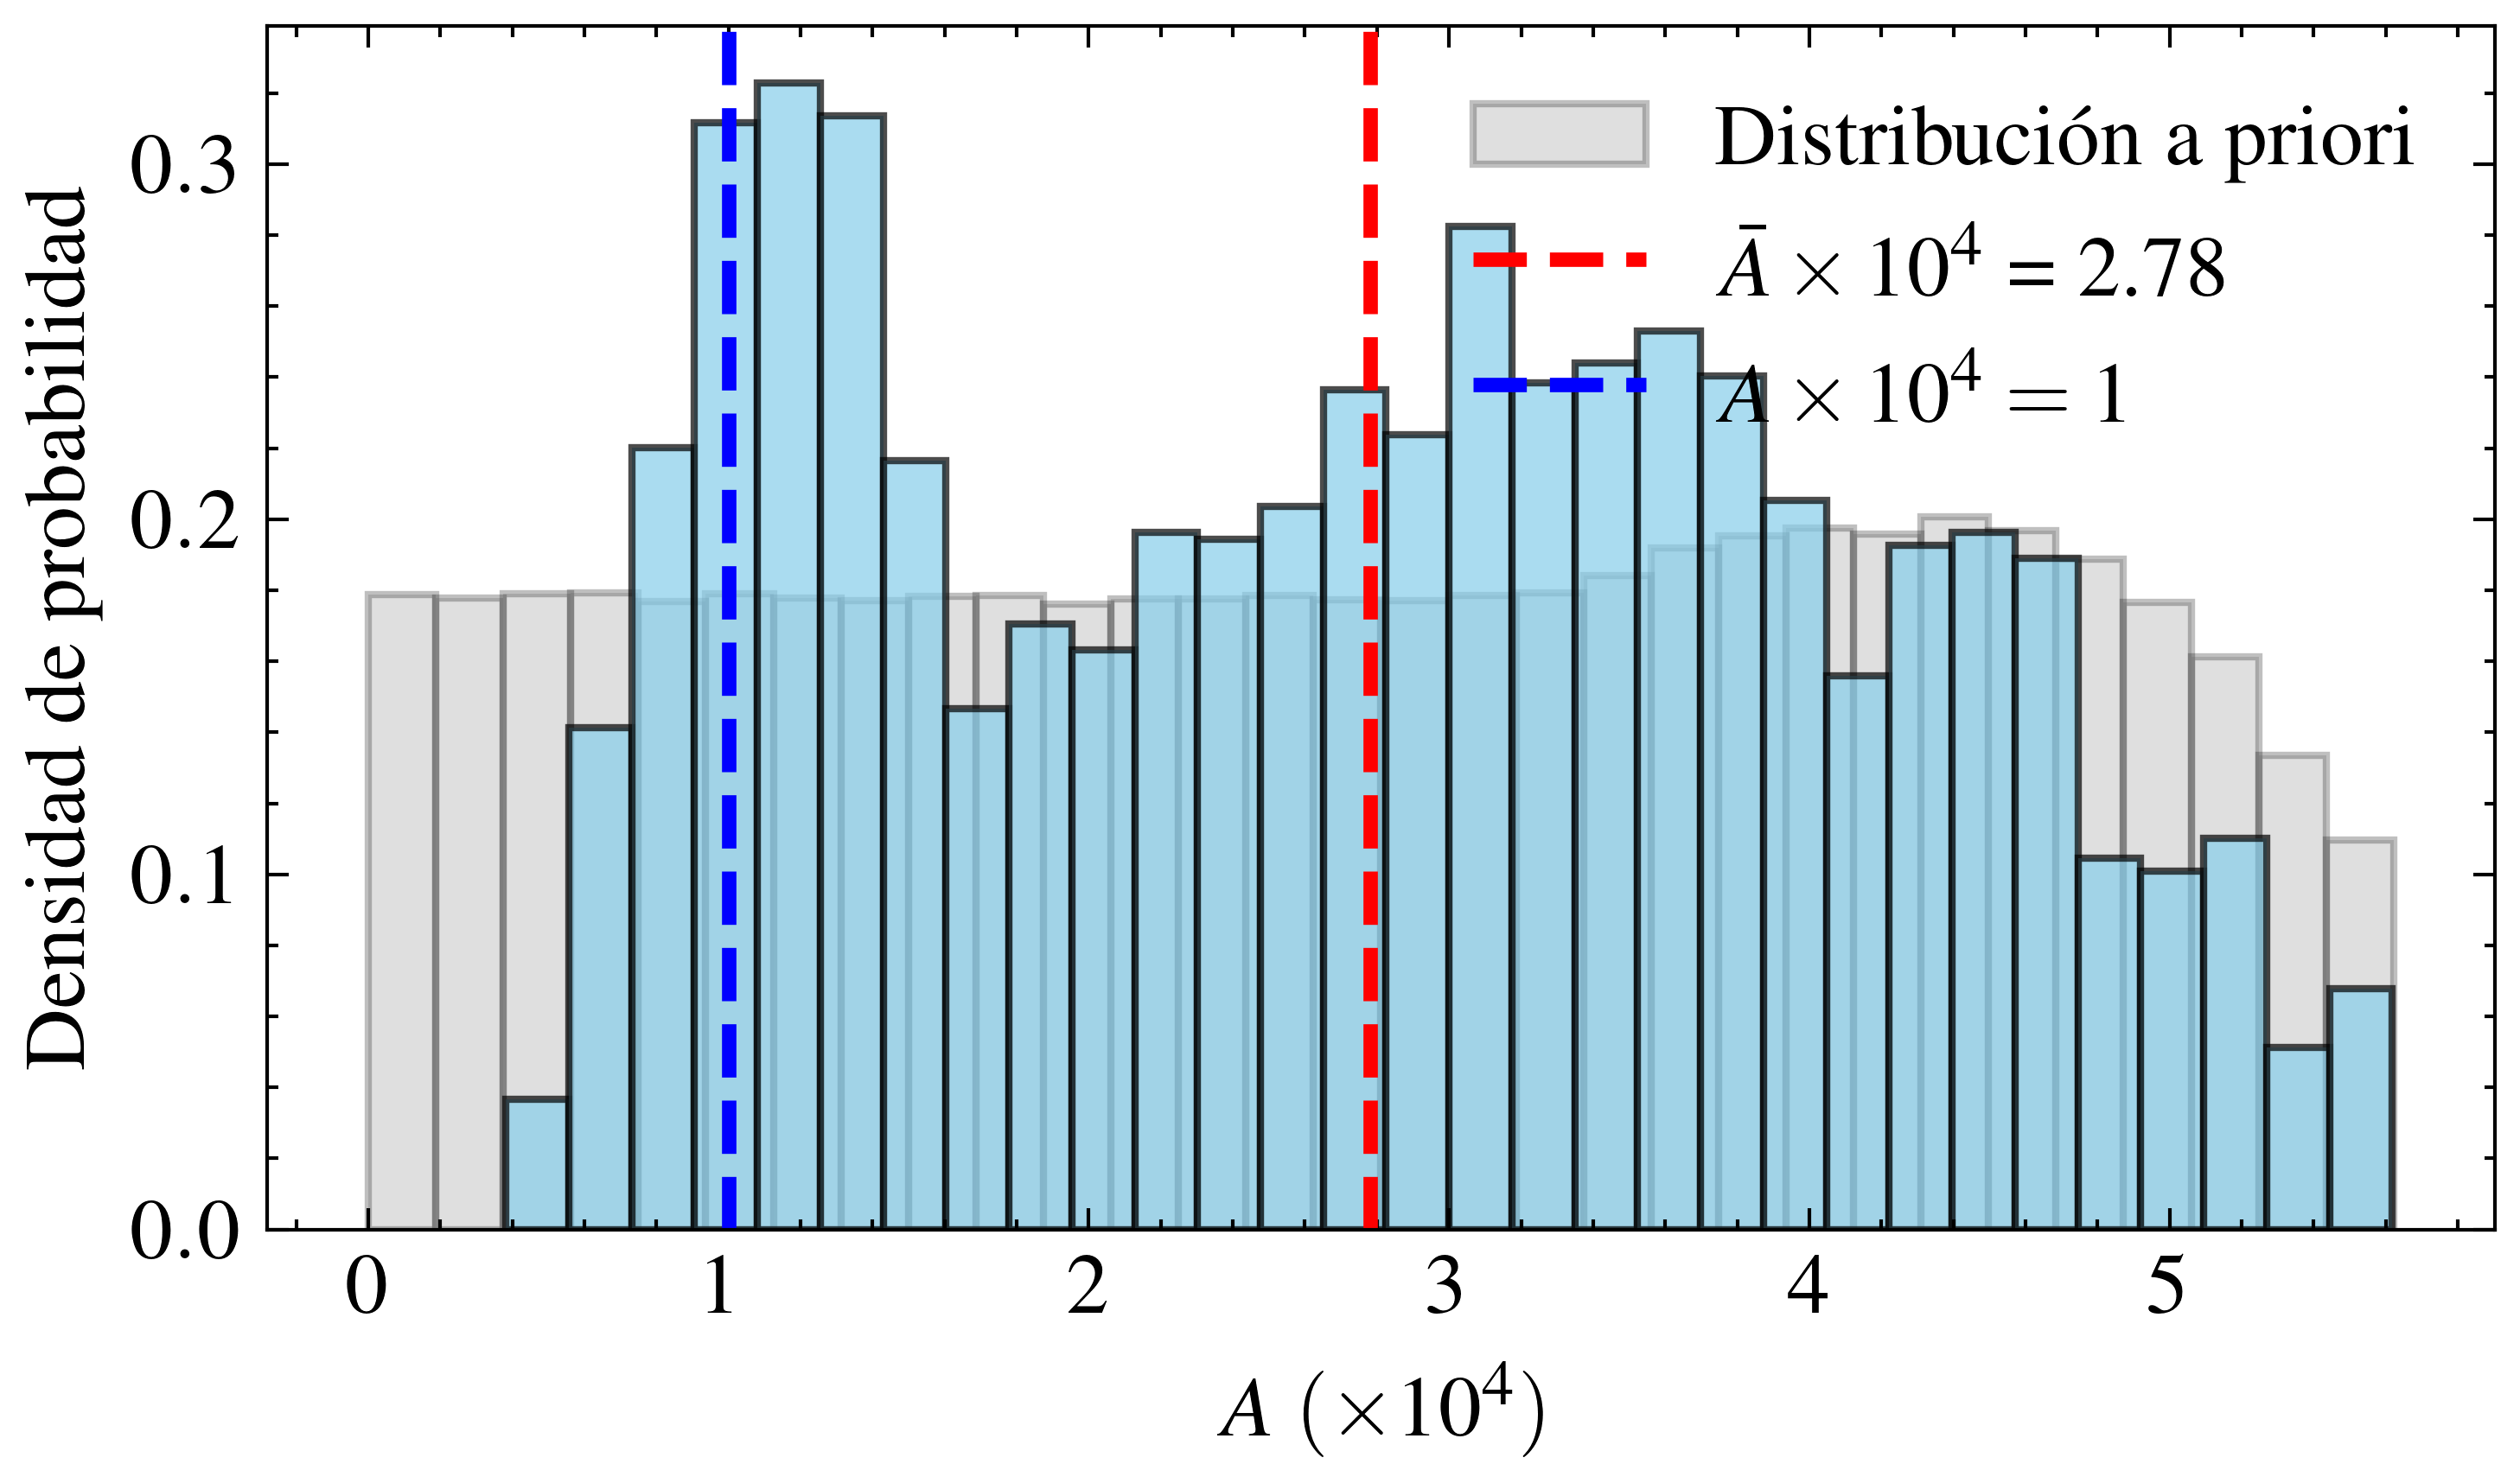

In [26]:
fig, ax = plt.subplots(figsize=(5, 3))

# Histograma original (atrás)
ax.hist(df_completo_3['A'] * 1e4, bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['A'] * 1e4, bins=30, alpha=0.7, density=True, edgecolor='black', color='skyblue')
ax.axvline(mejores_10000_3['A'].mean() * 1e4, color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{A}} \\times 10^{4}$ = {mejores_10000_3["A"].mean() * 1e4:.2f}')
ax.axvline(0.0001 * 1e4, color='blue', linestyle='dashed', linewidth=2, label='$A \\times 10^{4} = 1$')
ax.set_xlabel('$A~(\\times 10^{4})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_A_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

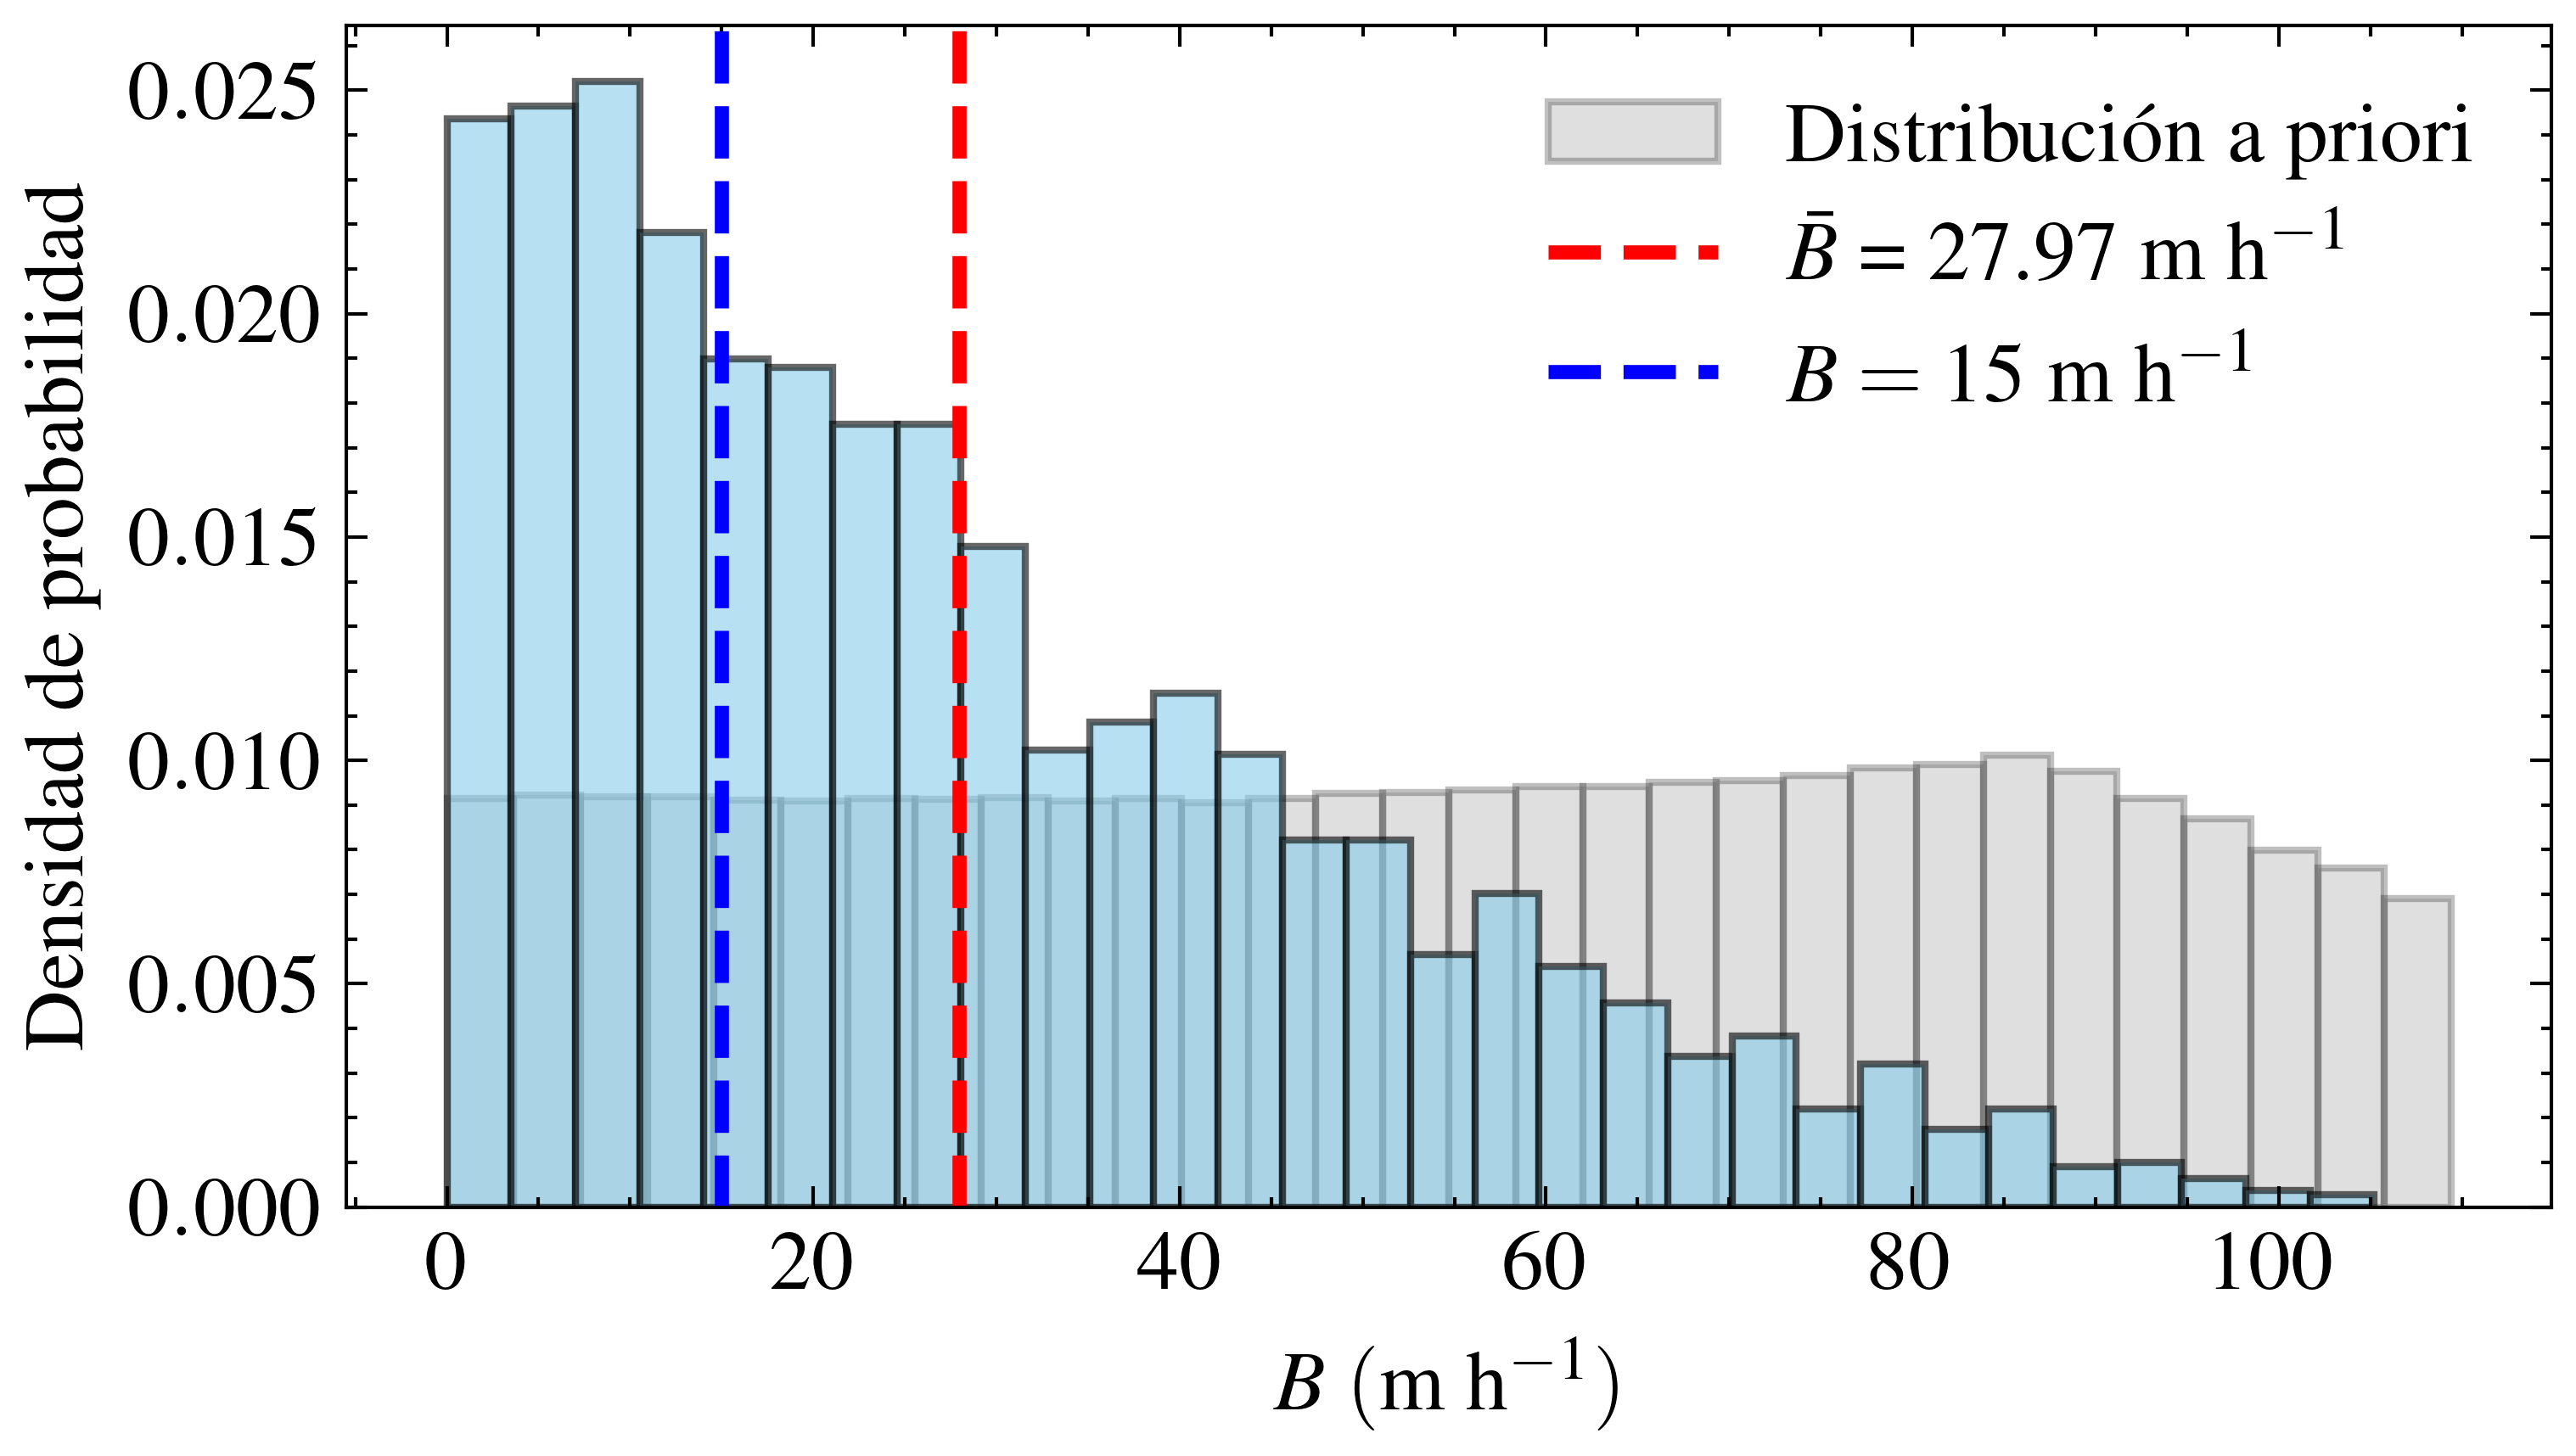

In [27]:
fig, ax = plt.subplots(figsize=(5.2, 3))

ax.hist(df_completo_3['B'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['B'], bins=30, alpha=0.6, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['B'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{B}}$ = {mejores_10000_3["B"].mean():.2f} $\\mathrm{{m~h^{{-1}}}}$')
ax.axvline(15, color='blue', linestyle='dashed', linewidth=2, label='$B = 15~\\mathrm{m~h^{-1}}$')
ax.set_xlabel('$B~(\\mathrm{m~h^{-1}})$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig('hist_B_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PDF
plt.show()

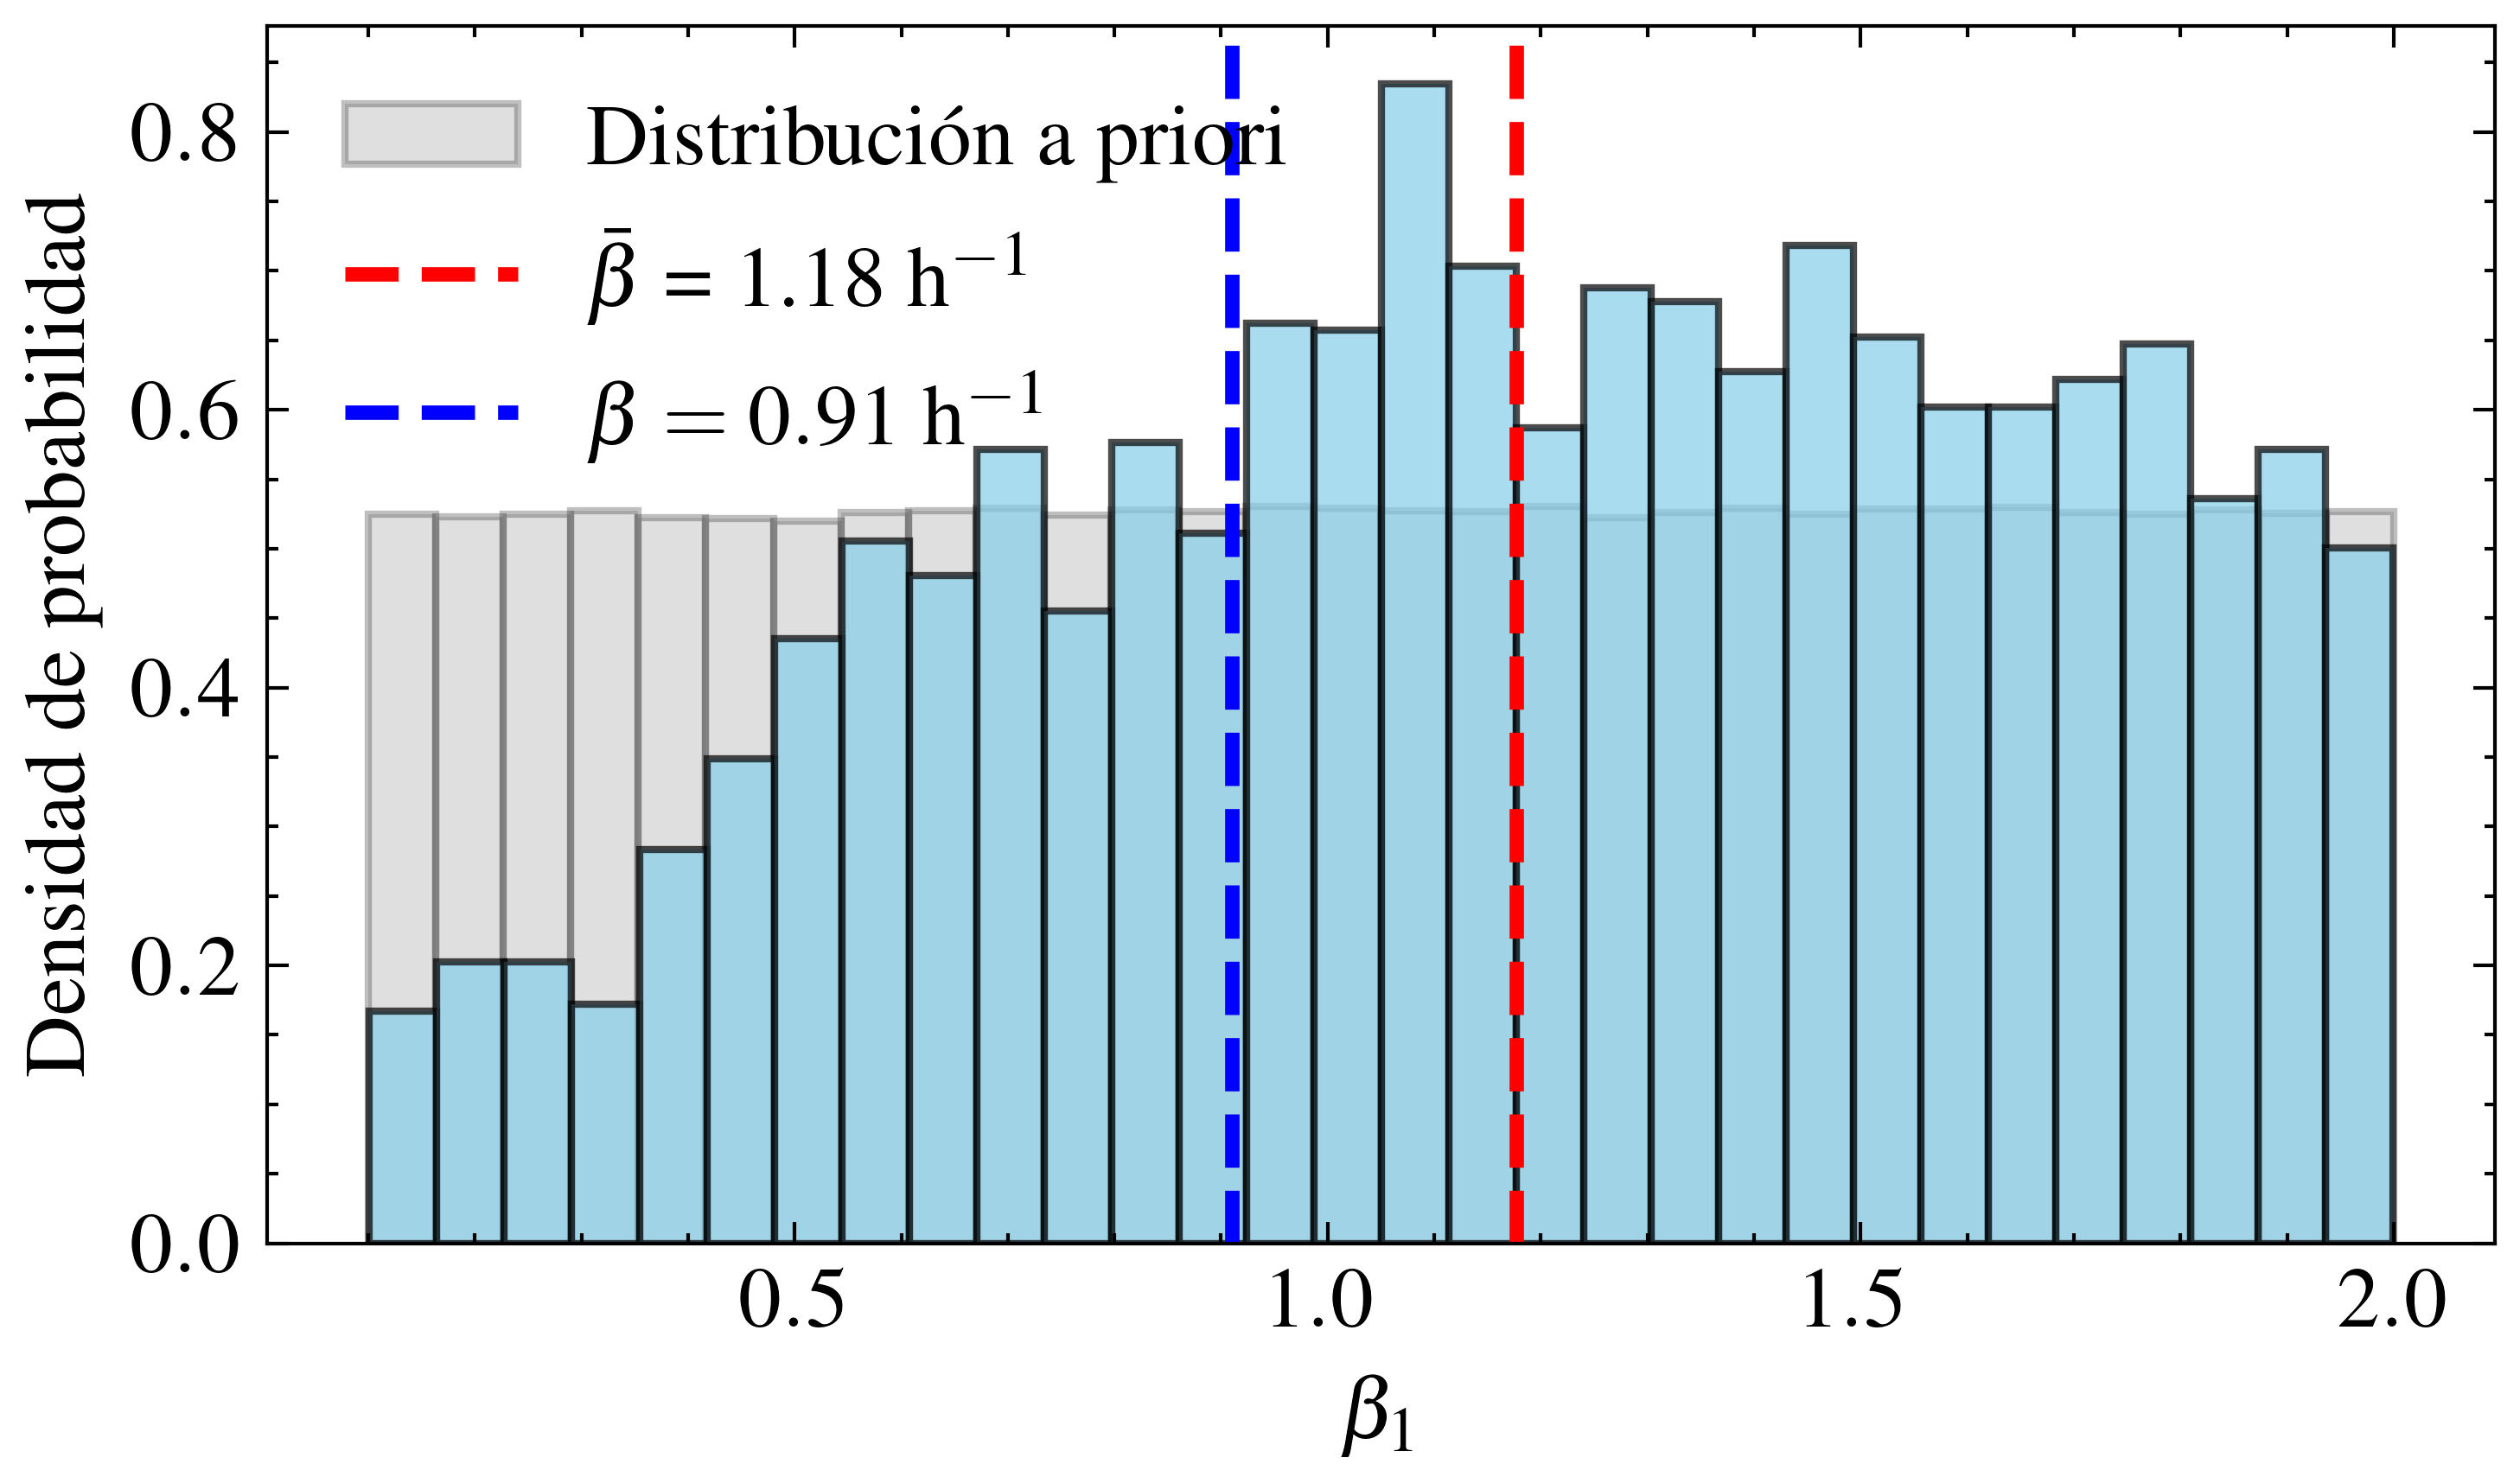

In [30]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['beta_1'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['beta_1'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['beta_1'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["beta_1"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.91, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 0.91~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\beta_1$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_beta_1_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

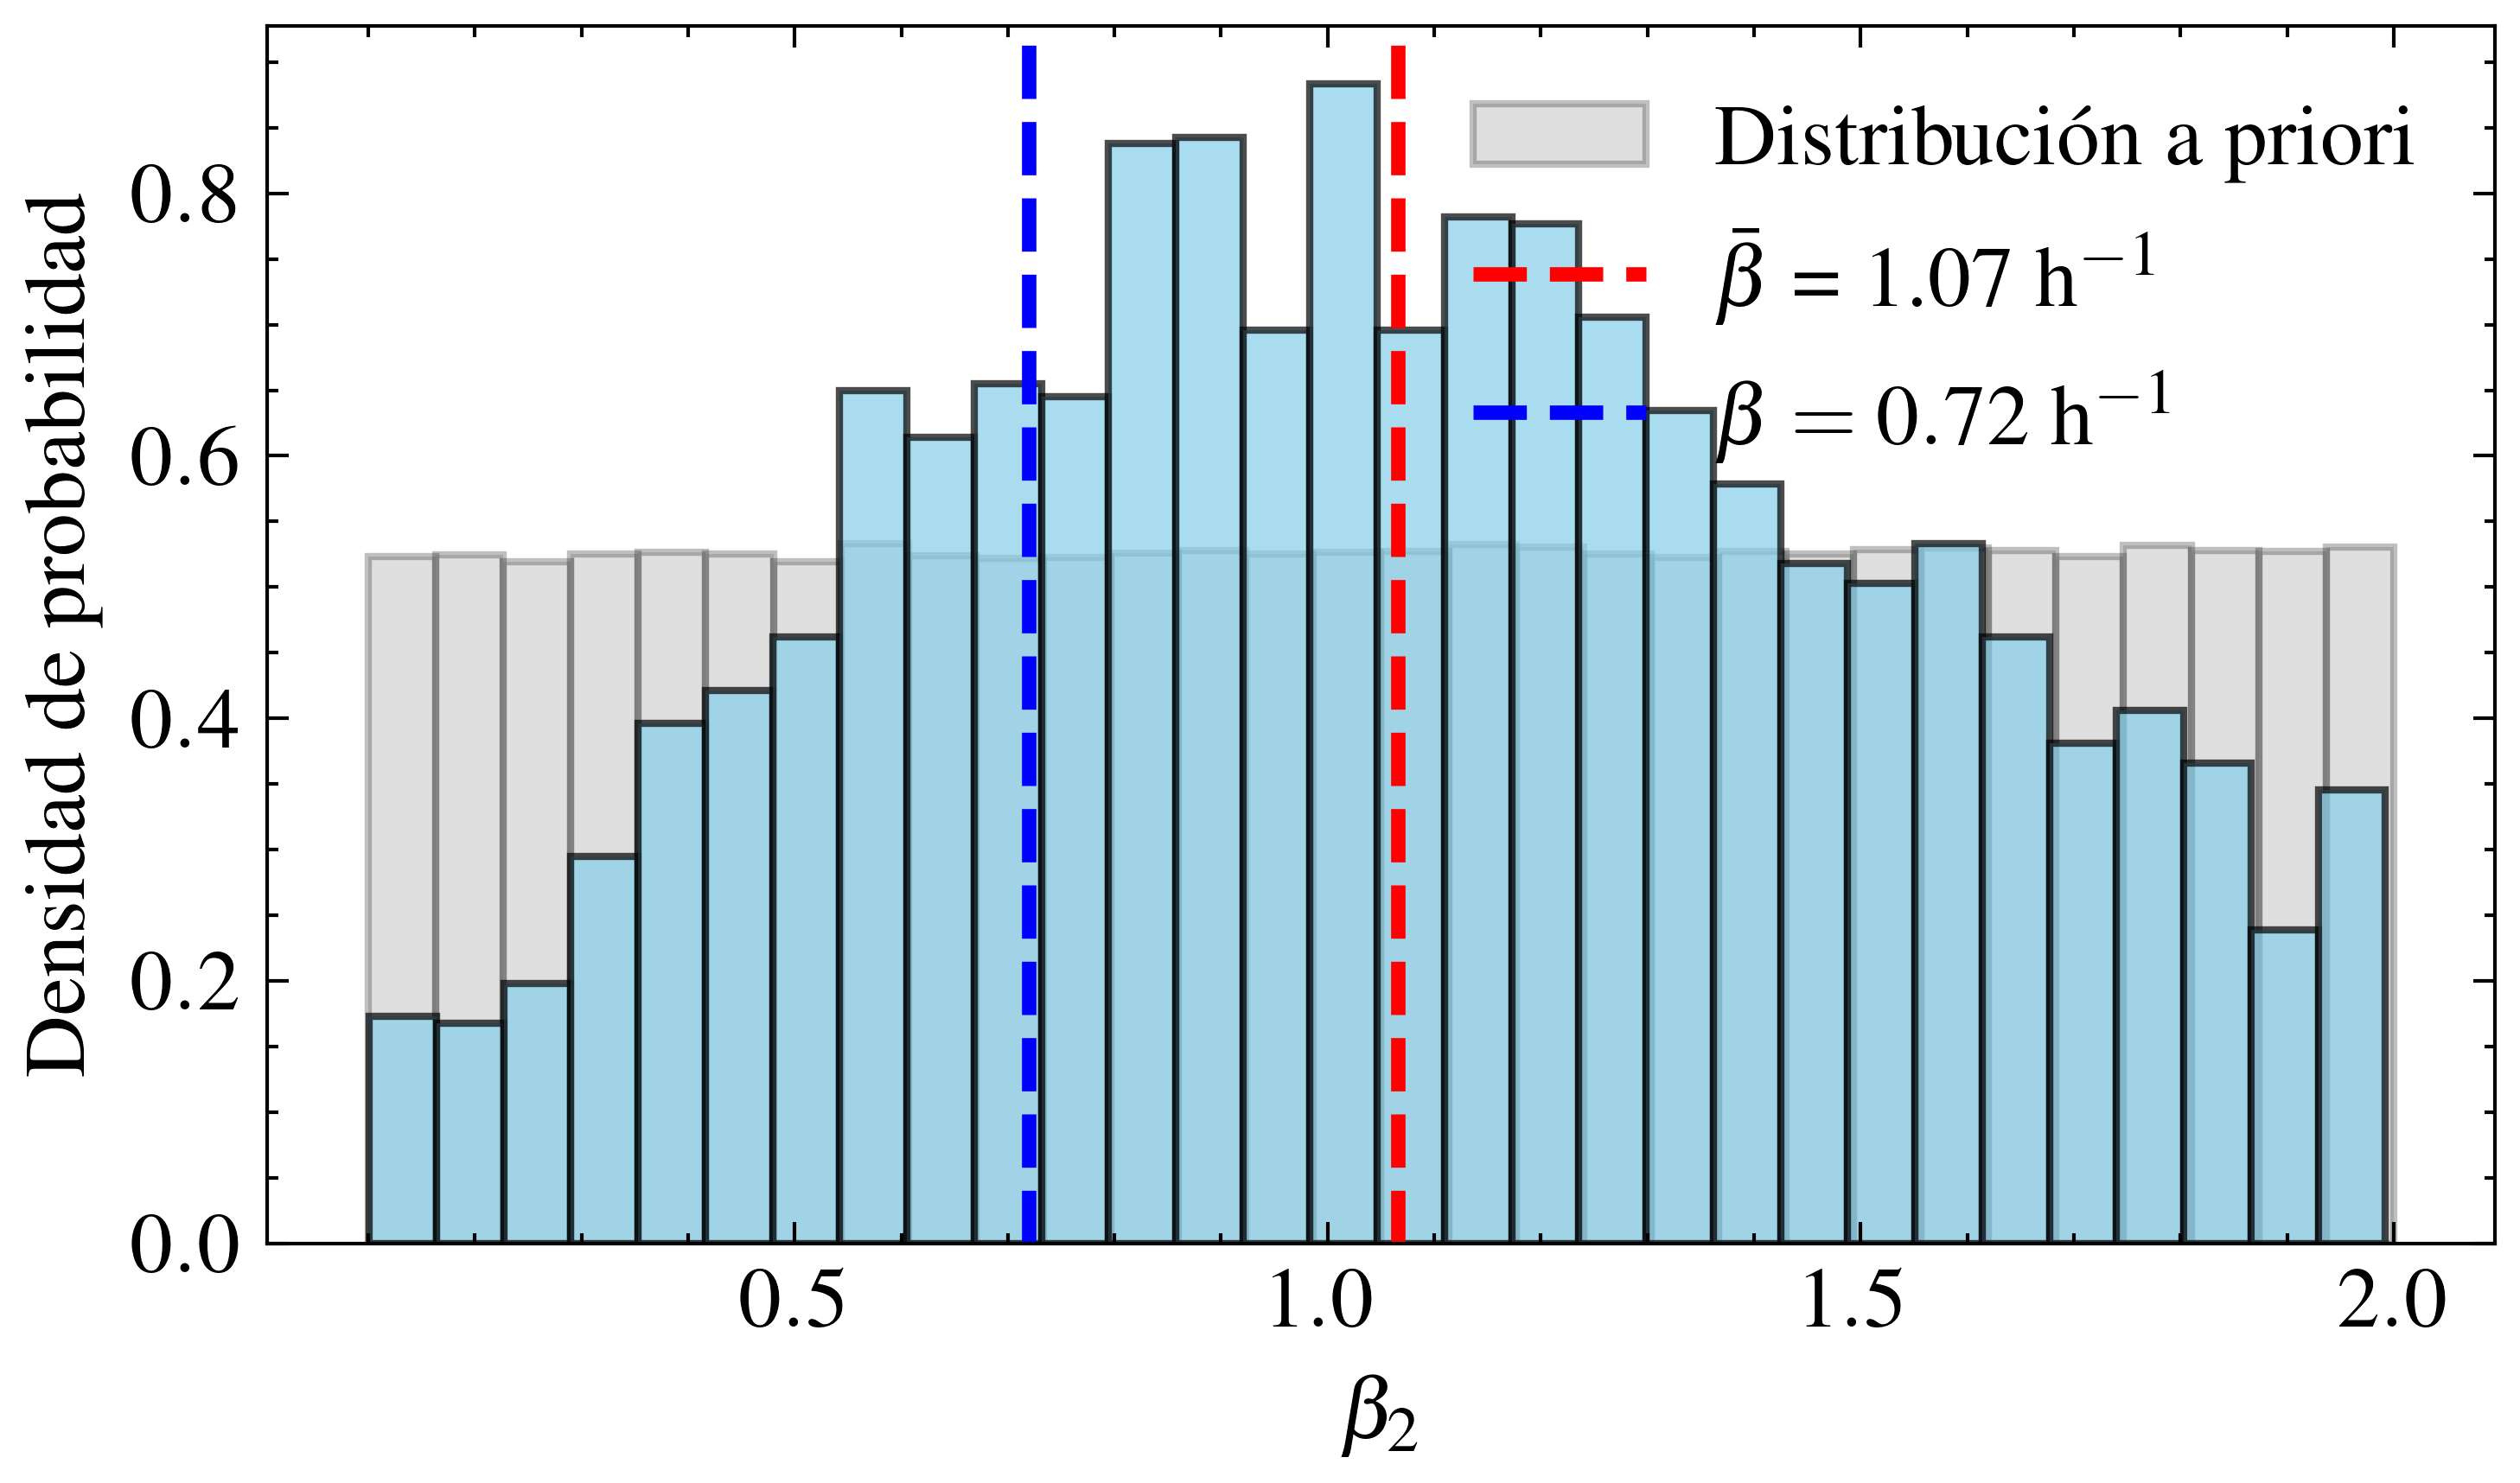

In [31]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['beta_2'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['beta_2'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['beta_2'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["beta_2"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.72, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 0.72~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\beta_2$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_beta_2_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

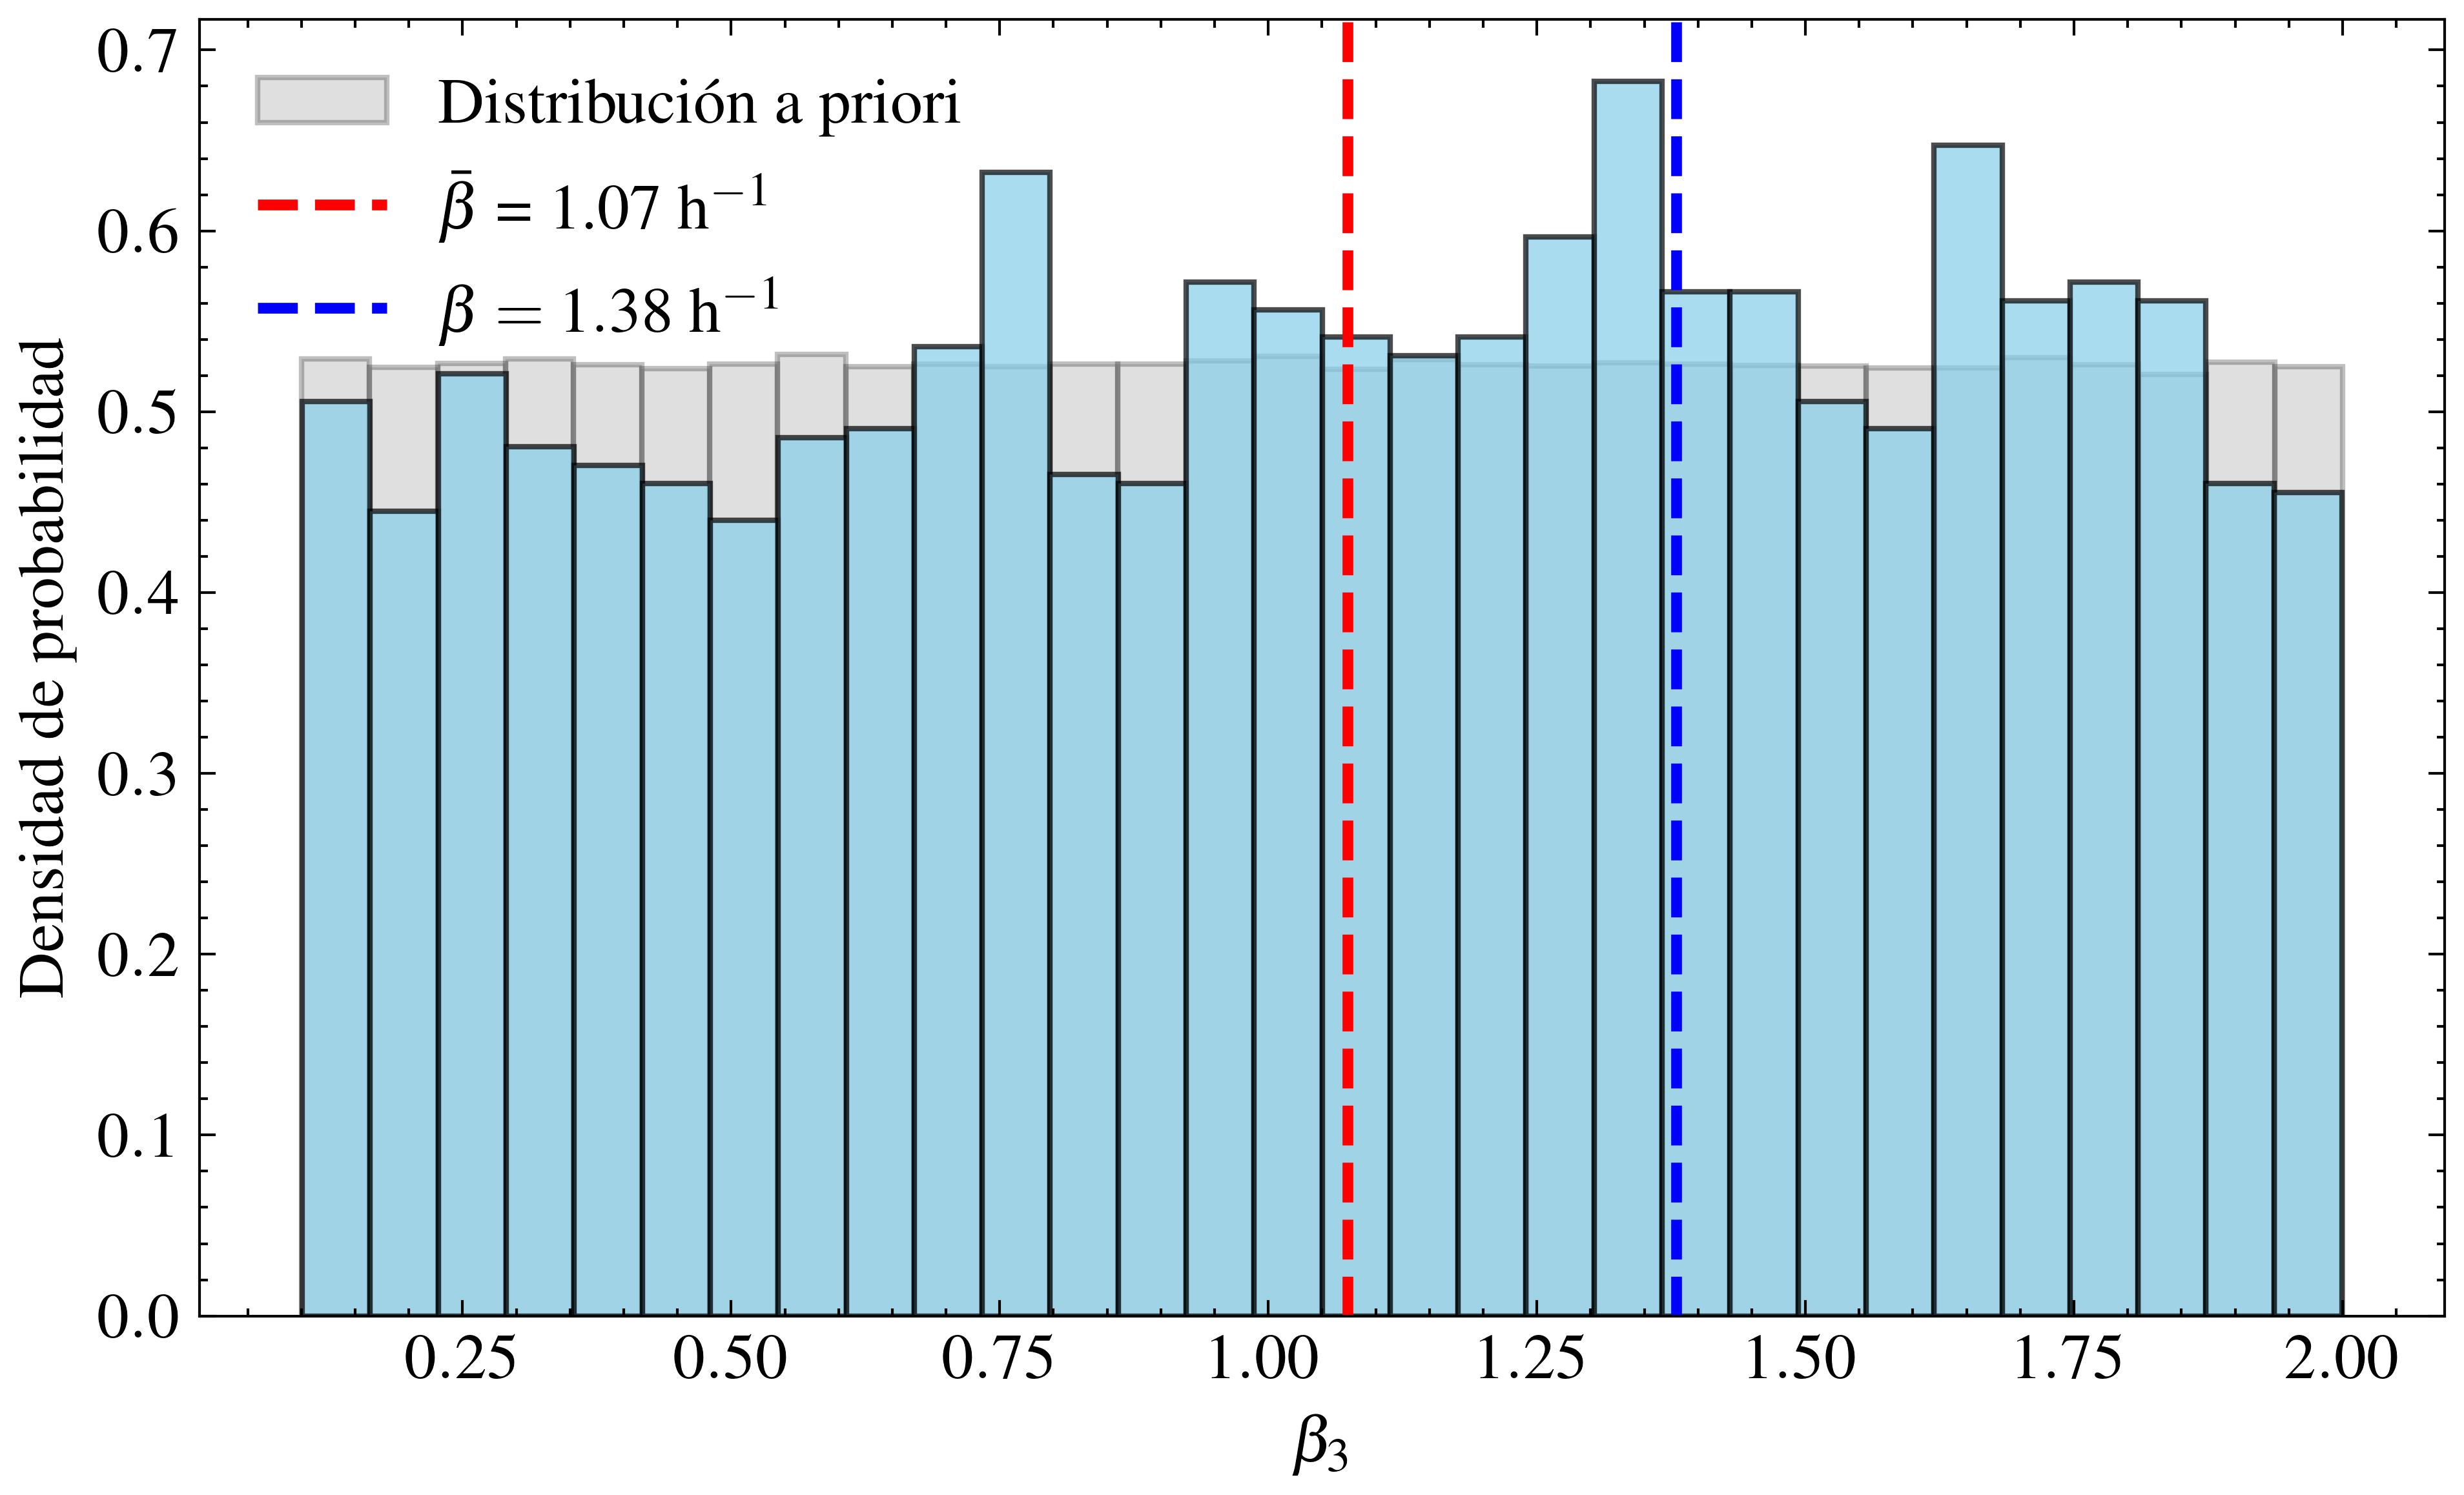

In [46]:
fig, ax = plt.subplots(figsize=(6.5,4))

ax.hist(df_completo_3['beta_3'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['beta_3'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['beta_3'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["beta_3"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(1.38, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 1.38~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\beta_3$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_beta_3_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

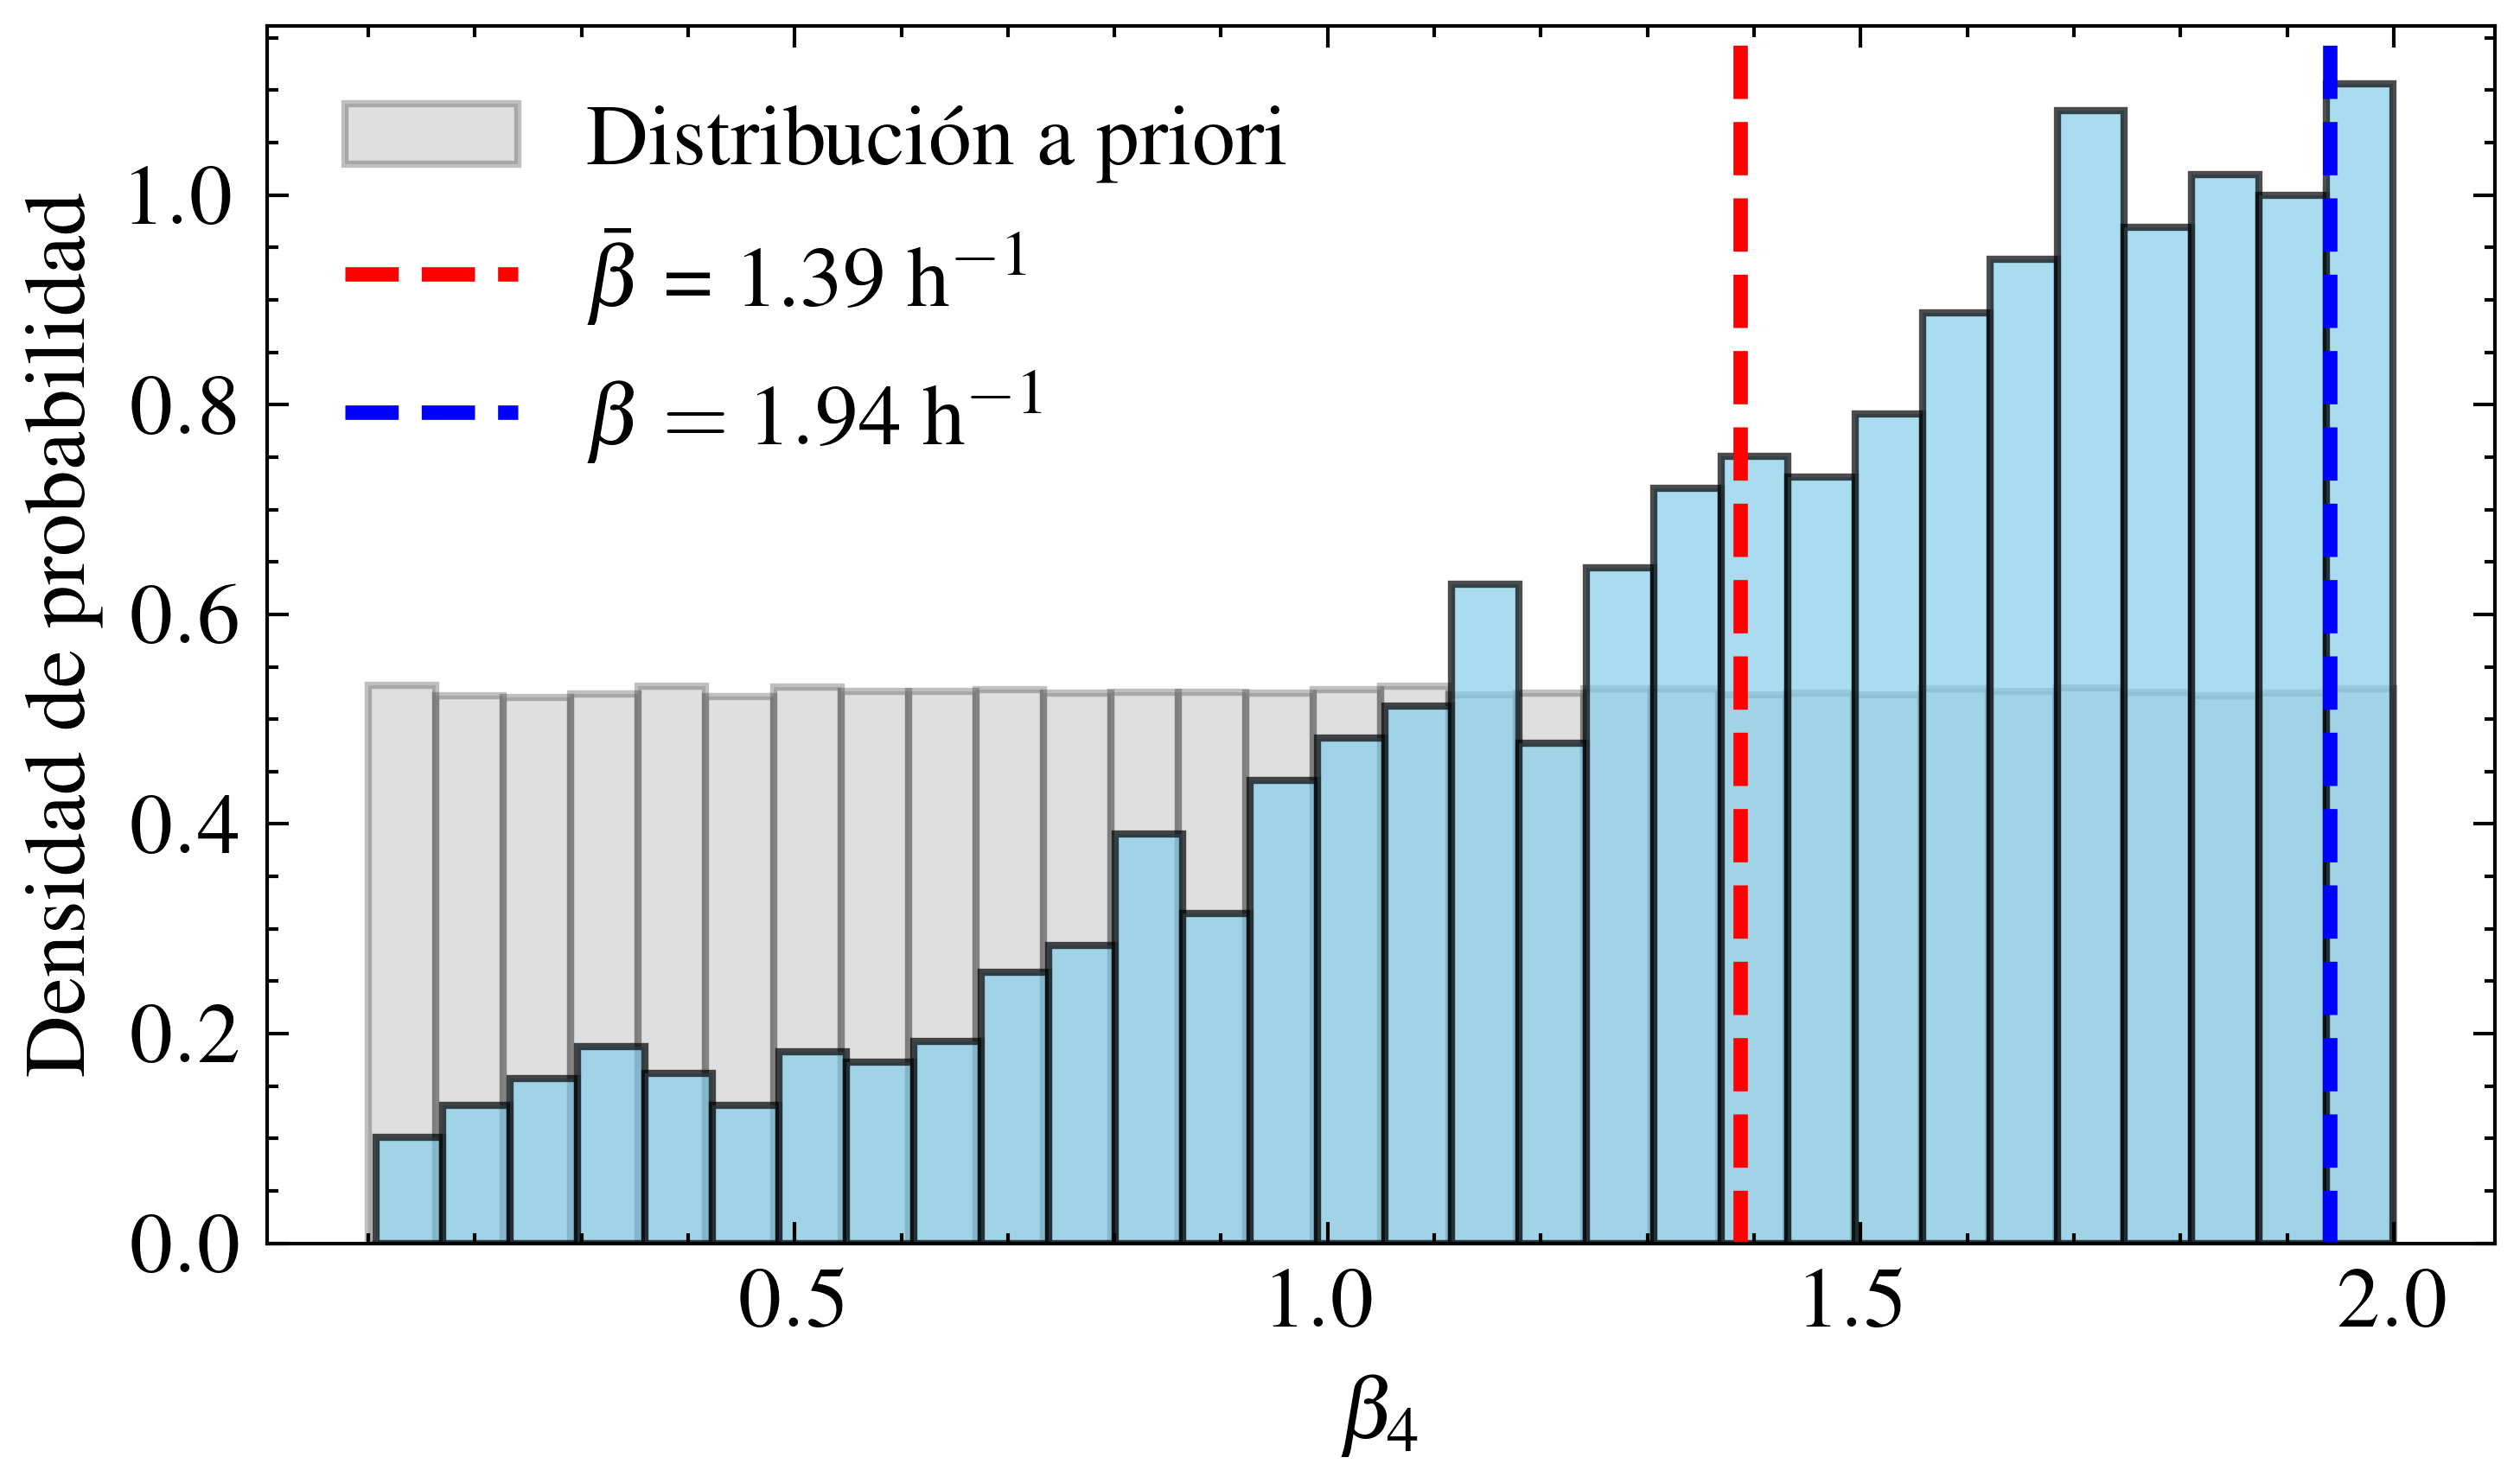

In [35]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['beta_4'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['beta_4'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['beta_4'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["beta_4"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(1.94, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 1.94~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\beta_4$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_beta_4_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

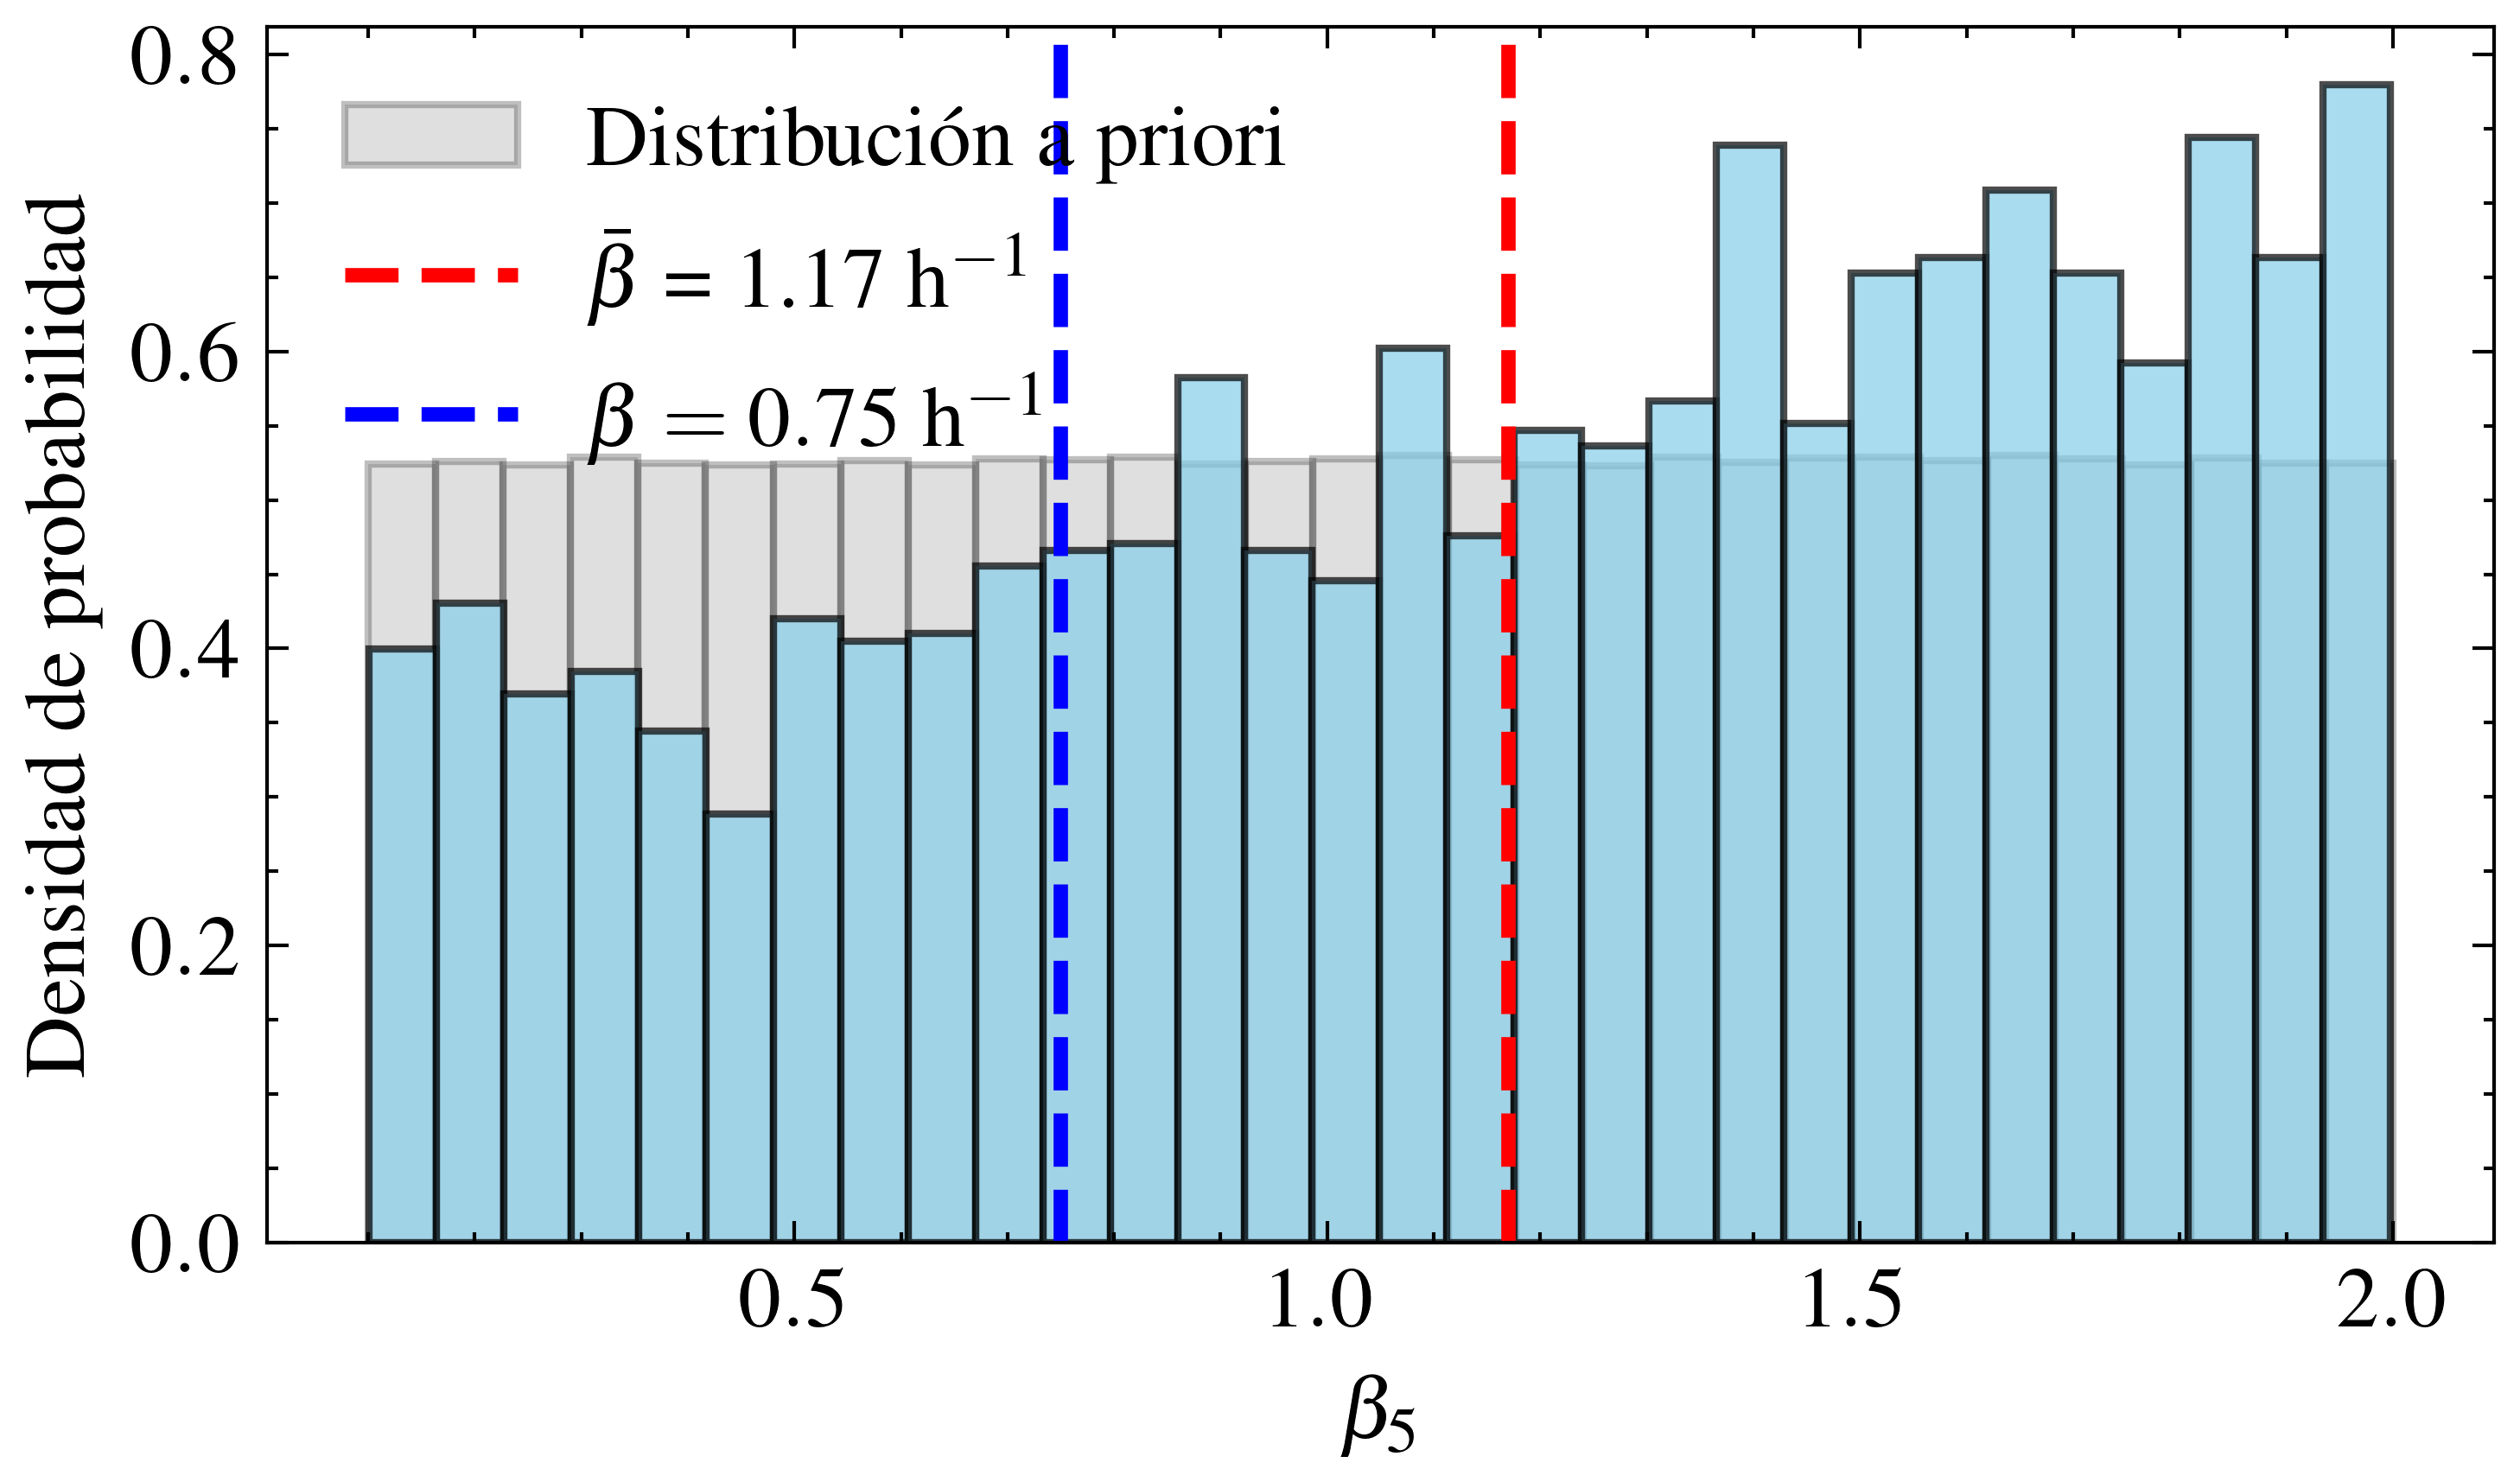

In [36]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['beta_5'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['beta_5'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['beta_5'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["beta_5"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.75, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 0.75~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\beta_5$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_beta_5_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

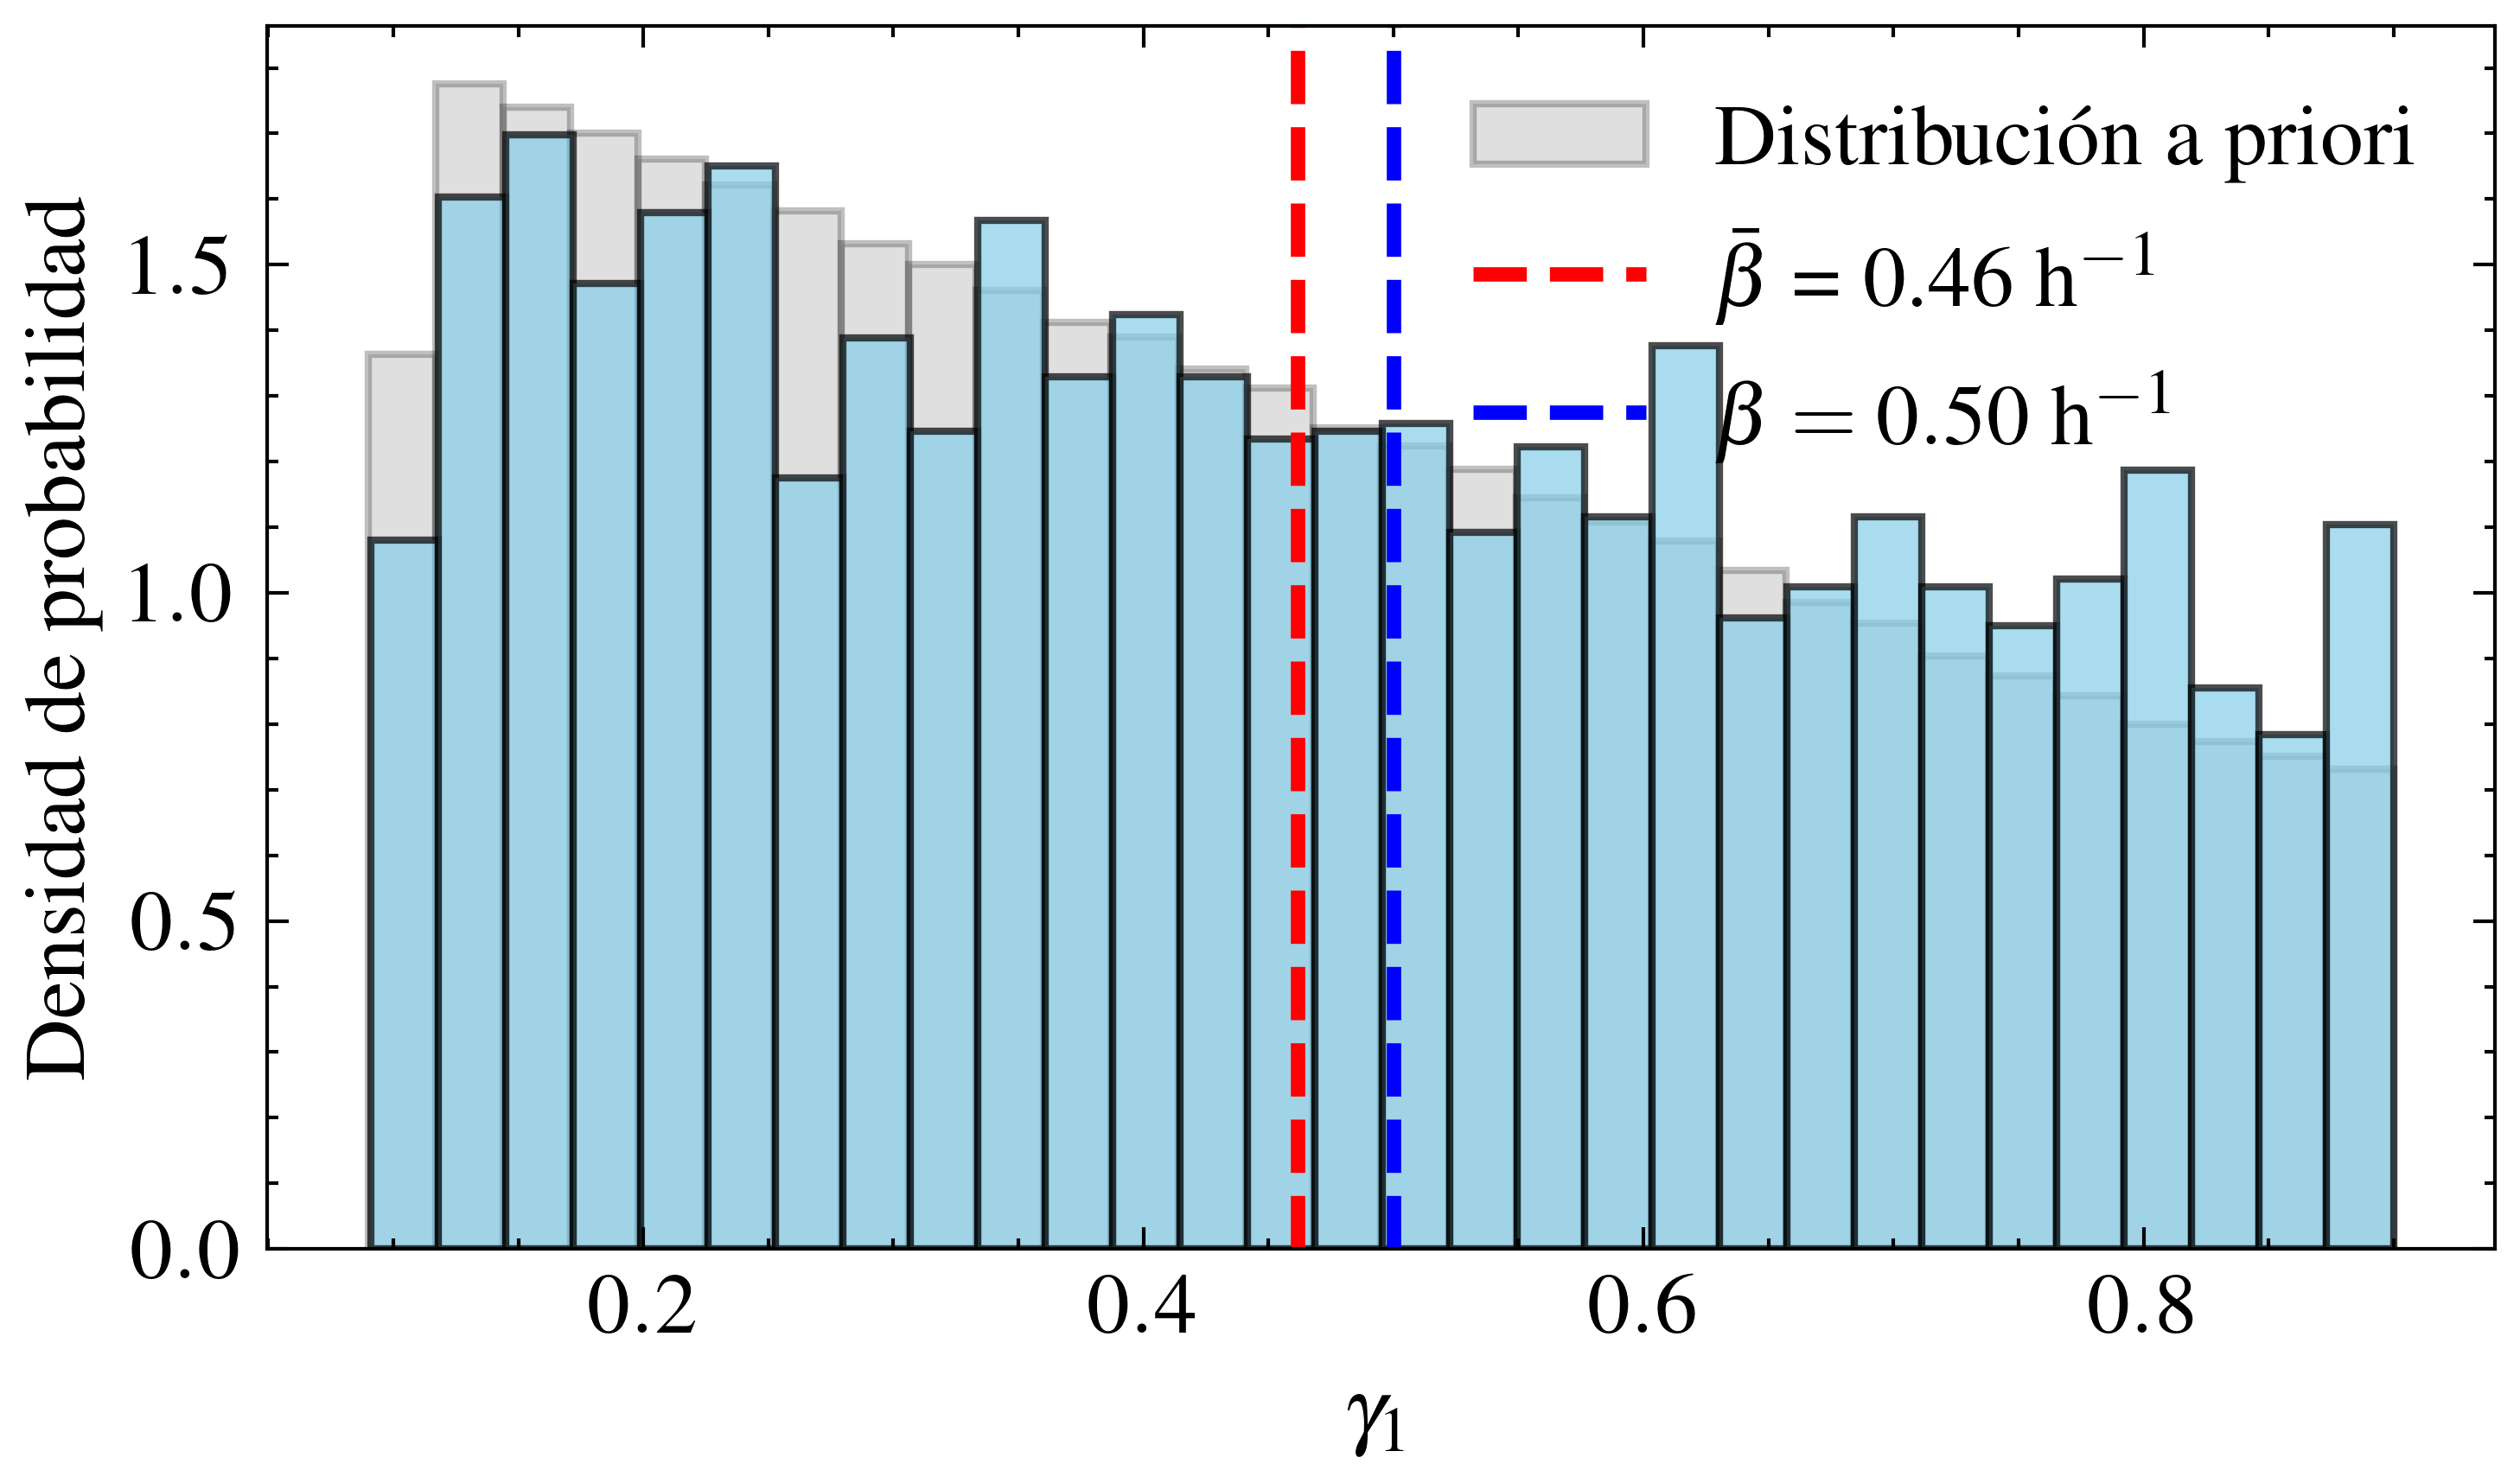

In [37]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['gamma_1'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['gamma_1'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['gamma_1'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["gamma_1"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.50, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 0.50~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\gamma_1$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_gamma_1_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

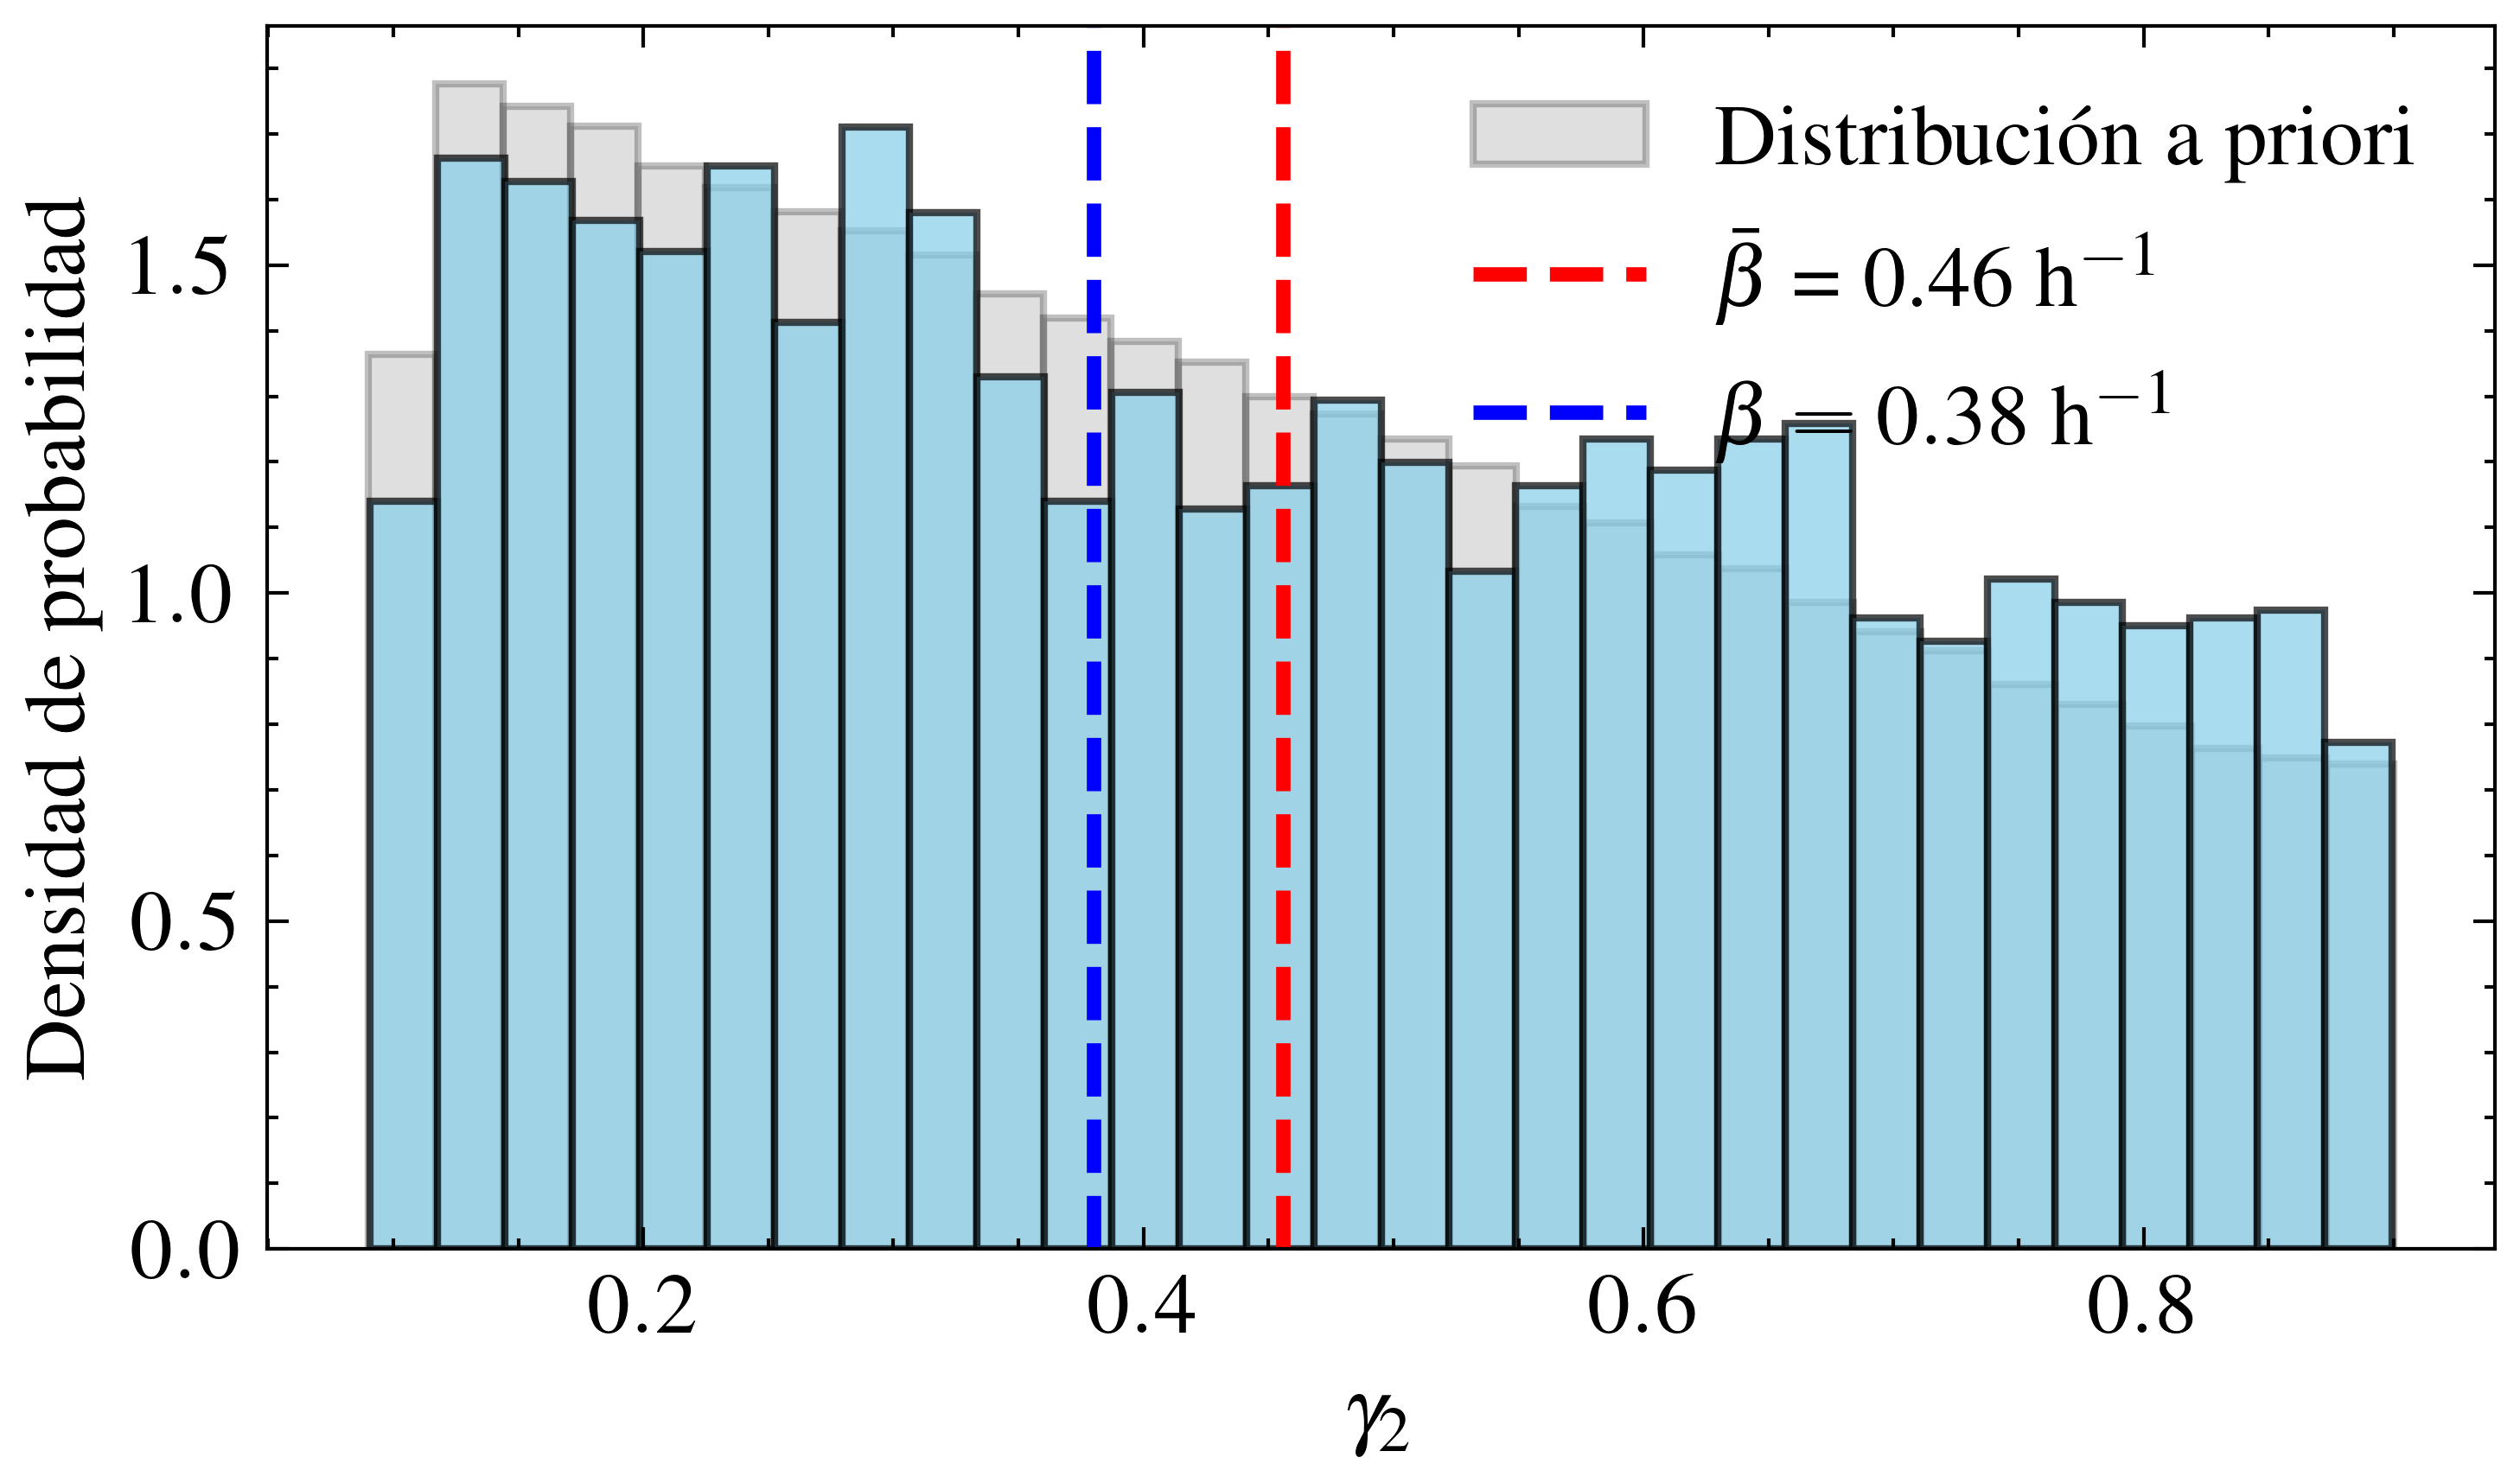

In [38]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['gamma_2'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['gamma_2'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['gamma_2'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["gamma_2"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.38, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 0.38~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\gamma_2$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_gamma_2_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

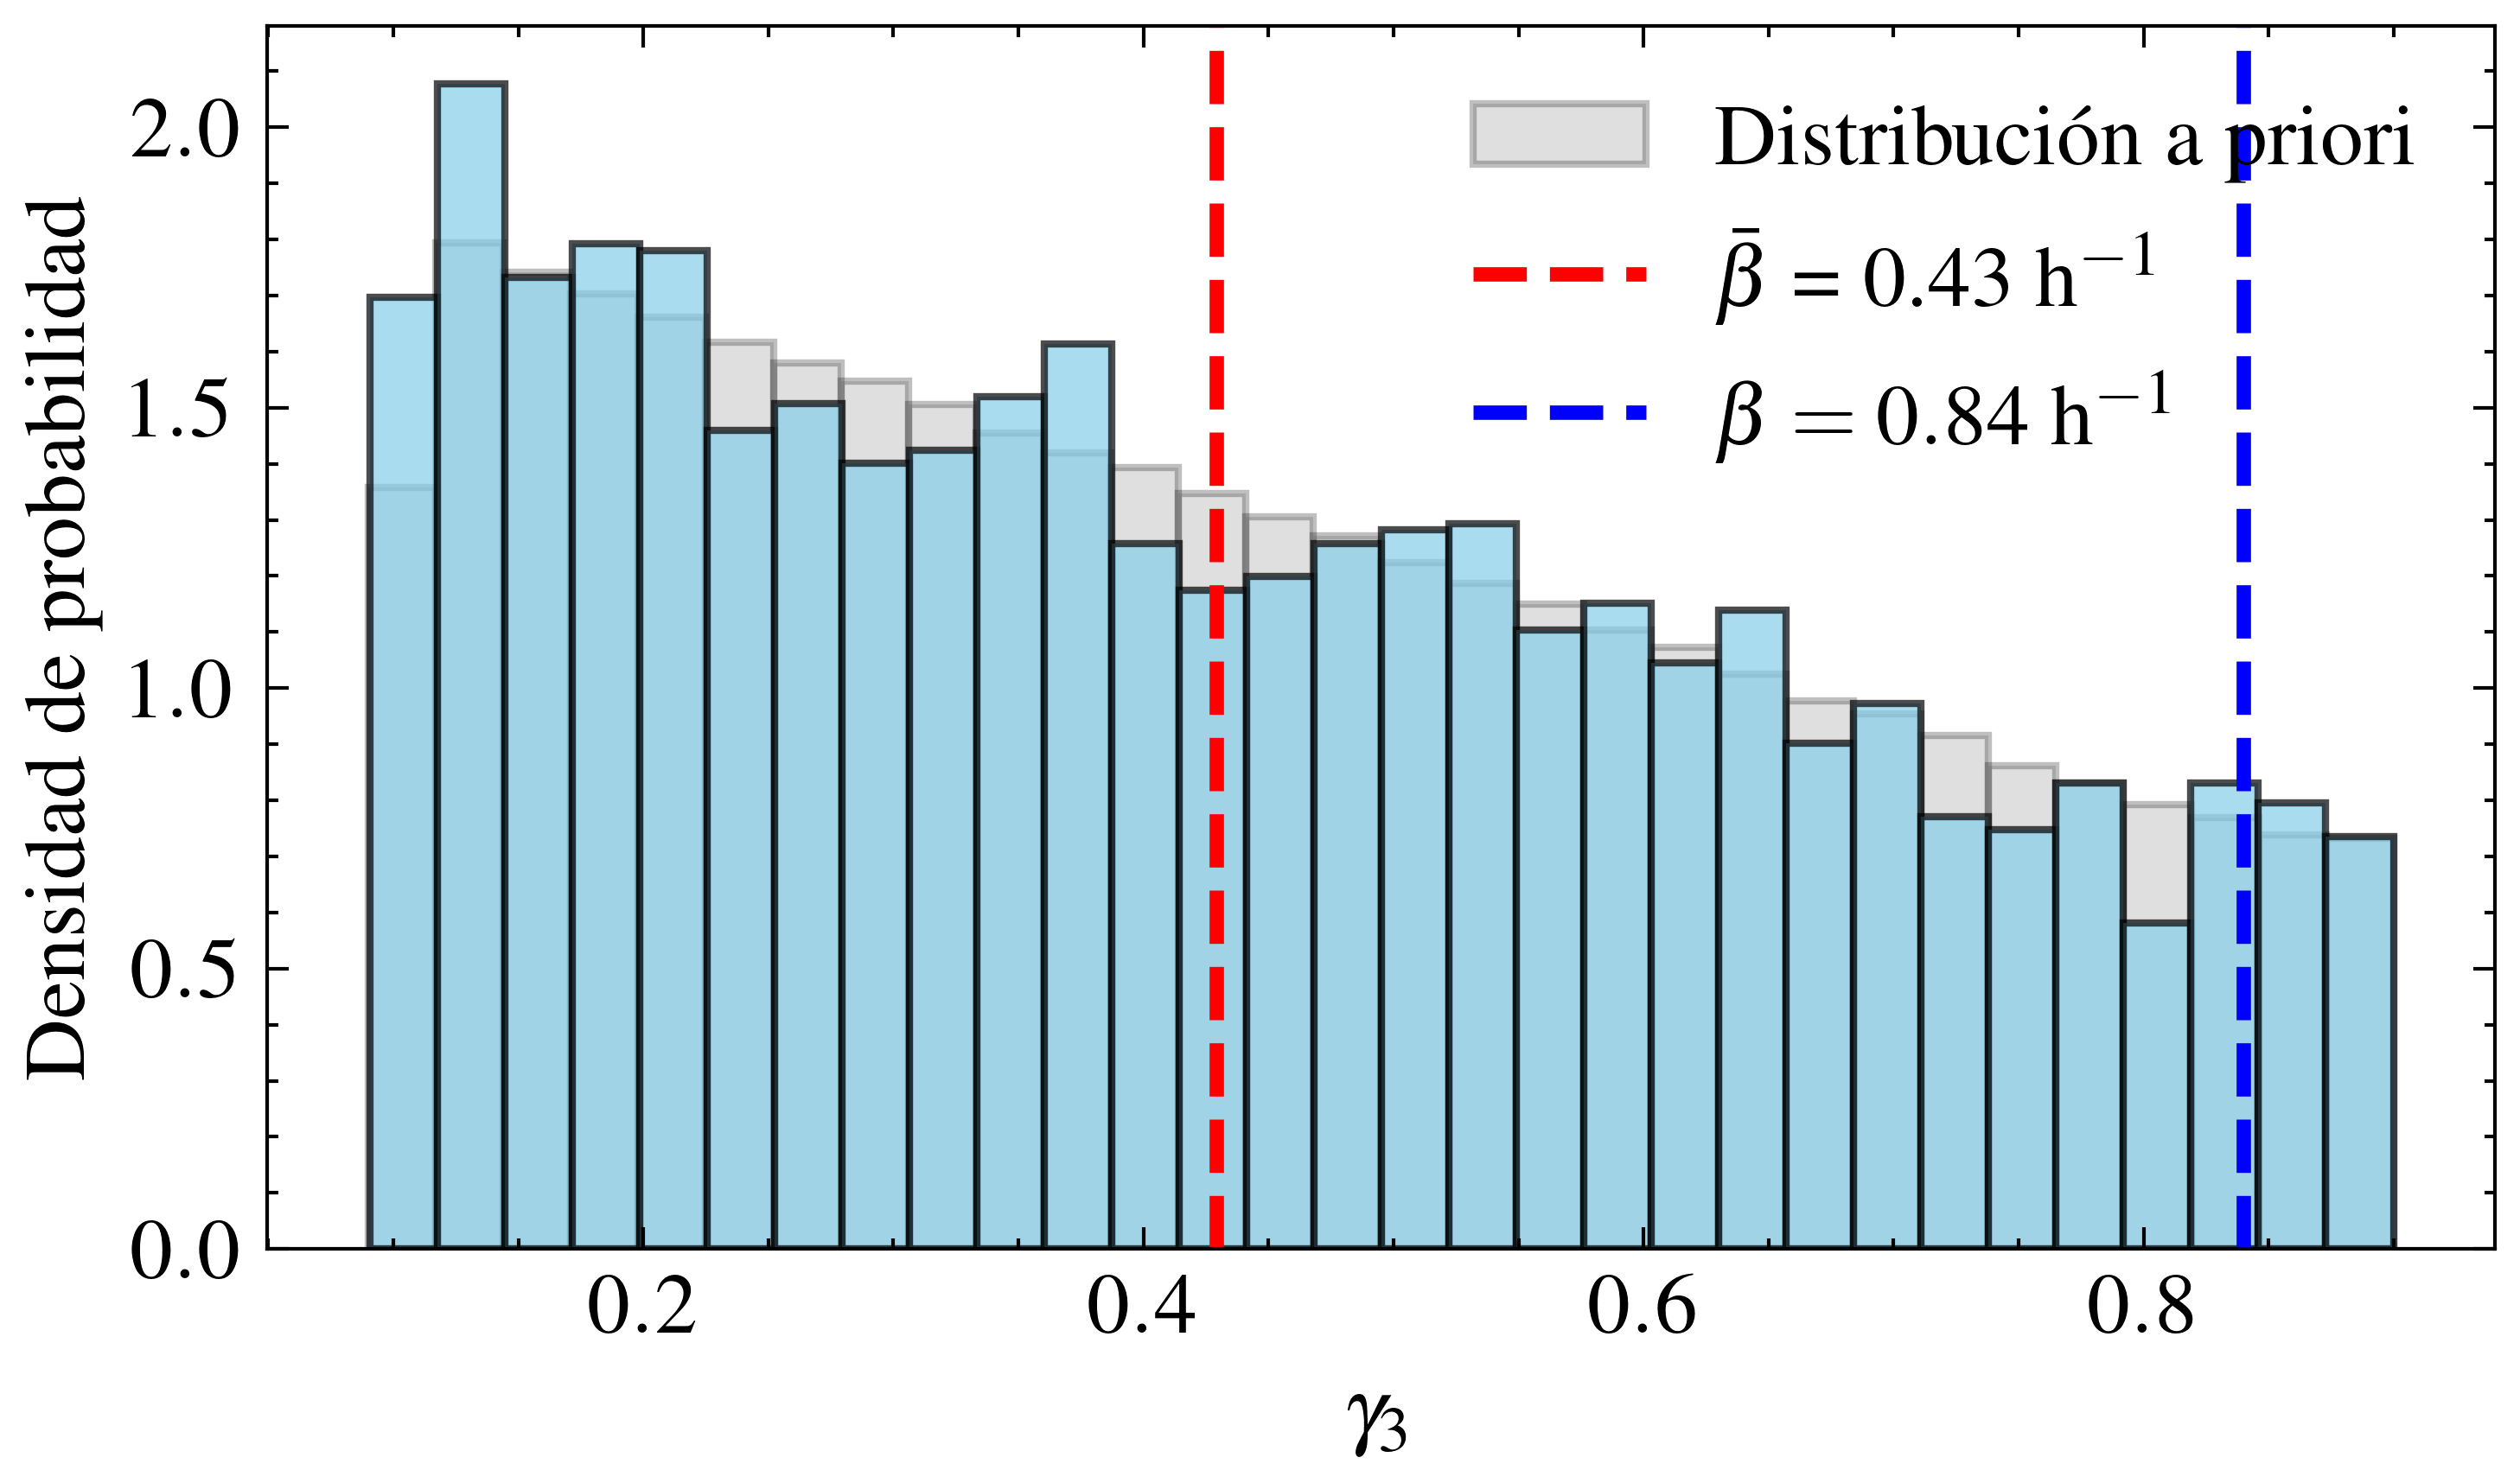

In [39]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['gamma_3'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['gamma_3'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['gamma_3'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["gamma_3"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.84, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 0.84~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\gamma_3$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_gamma_3_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

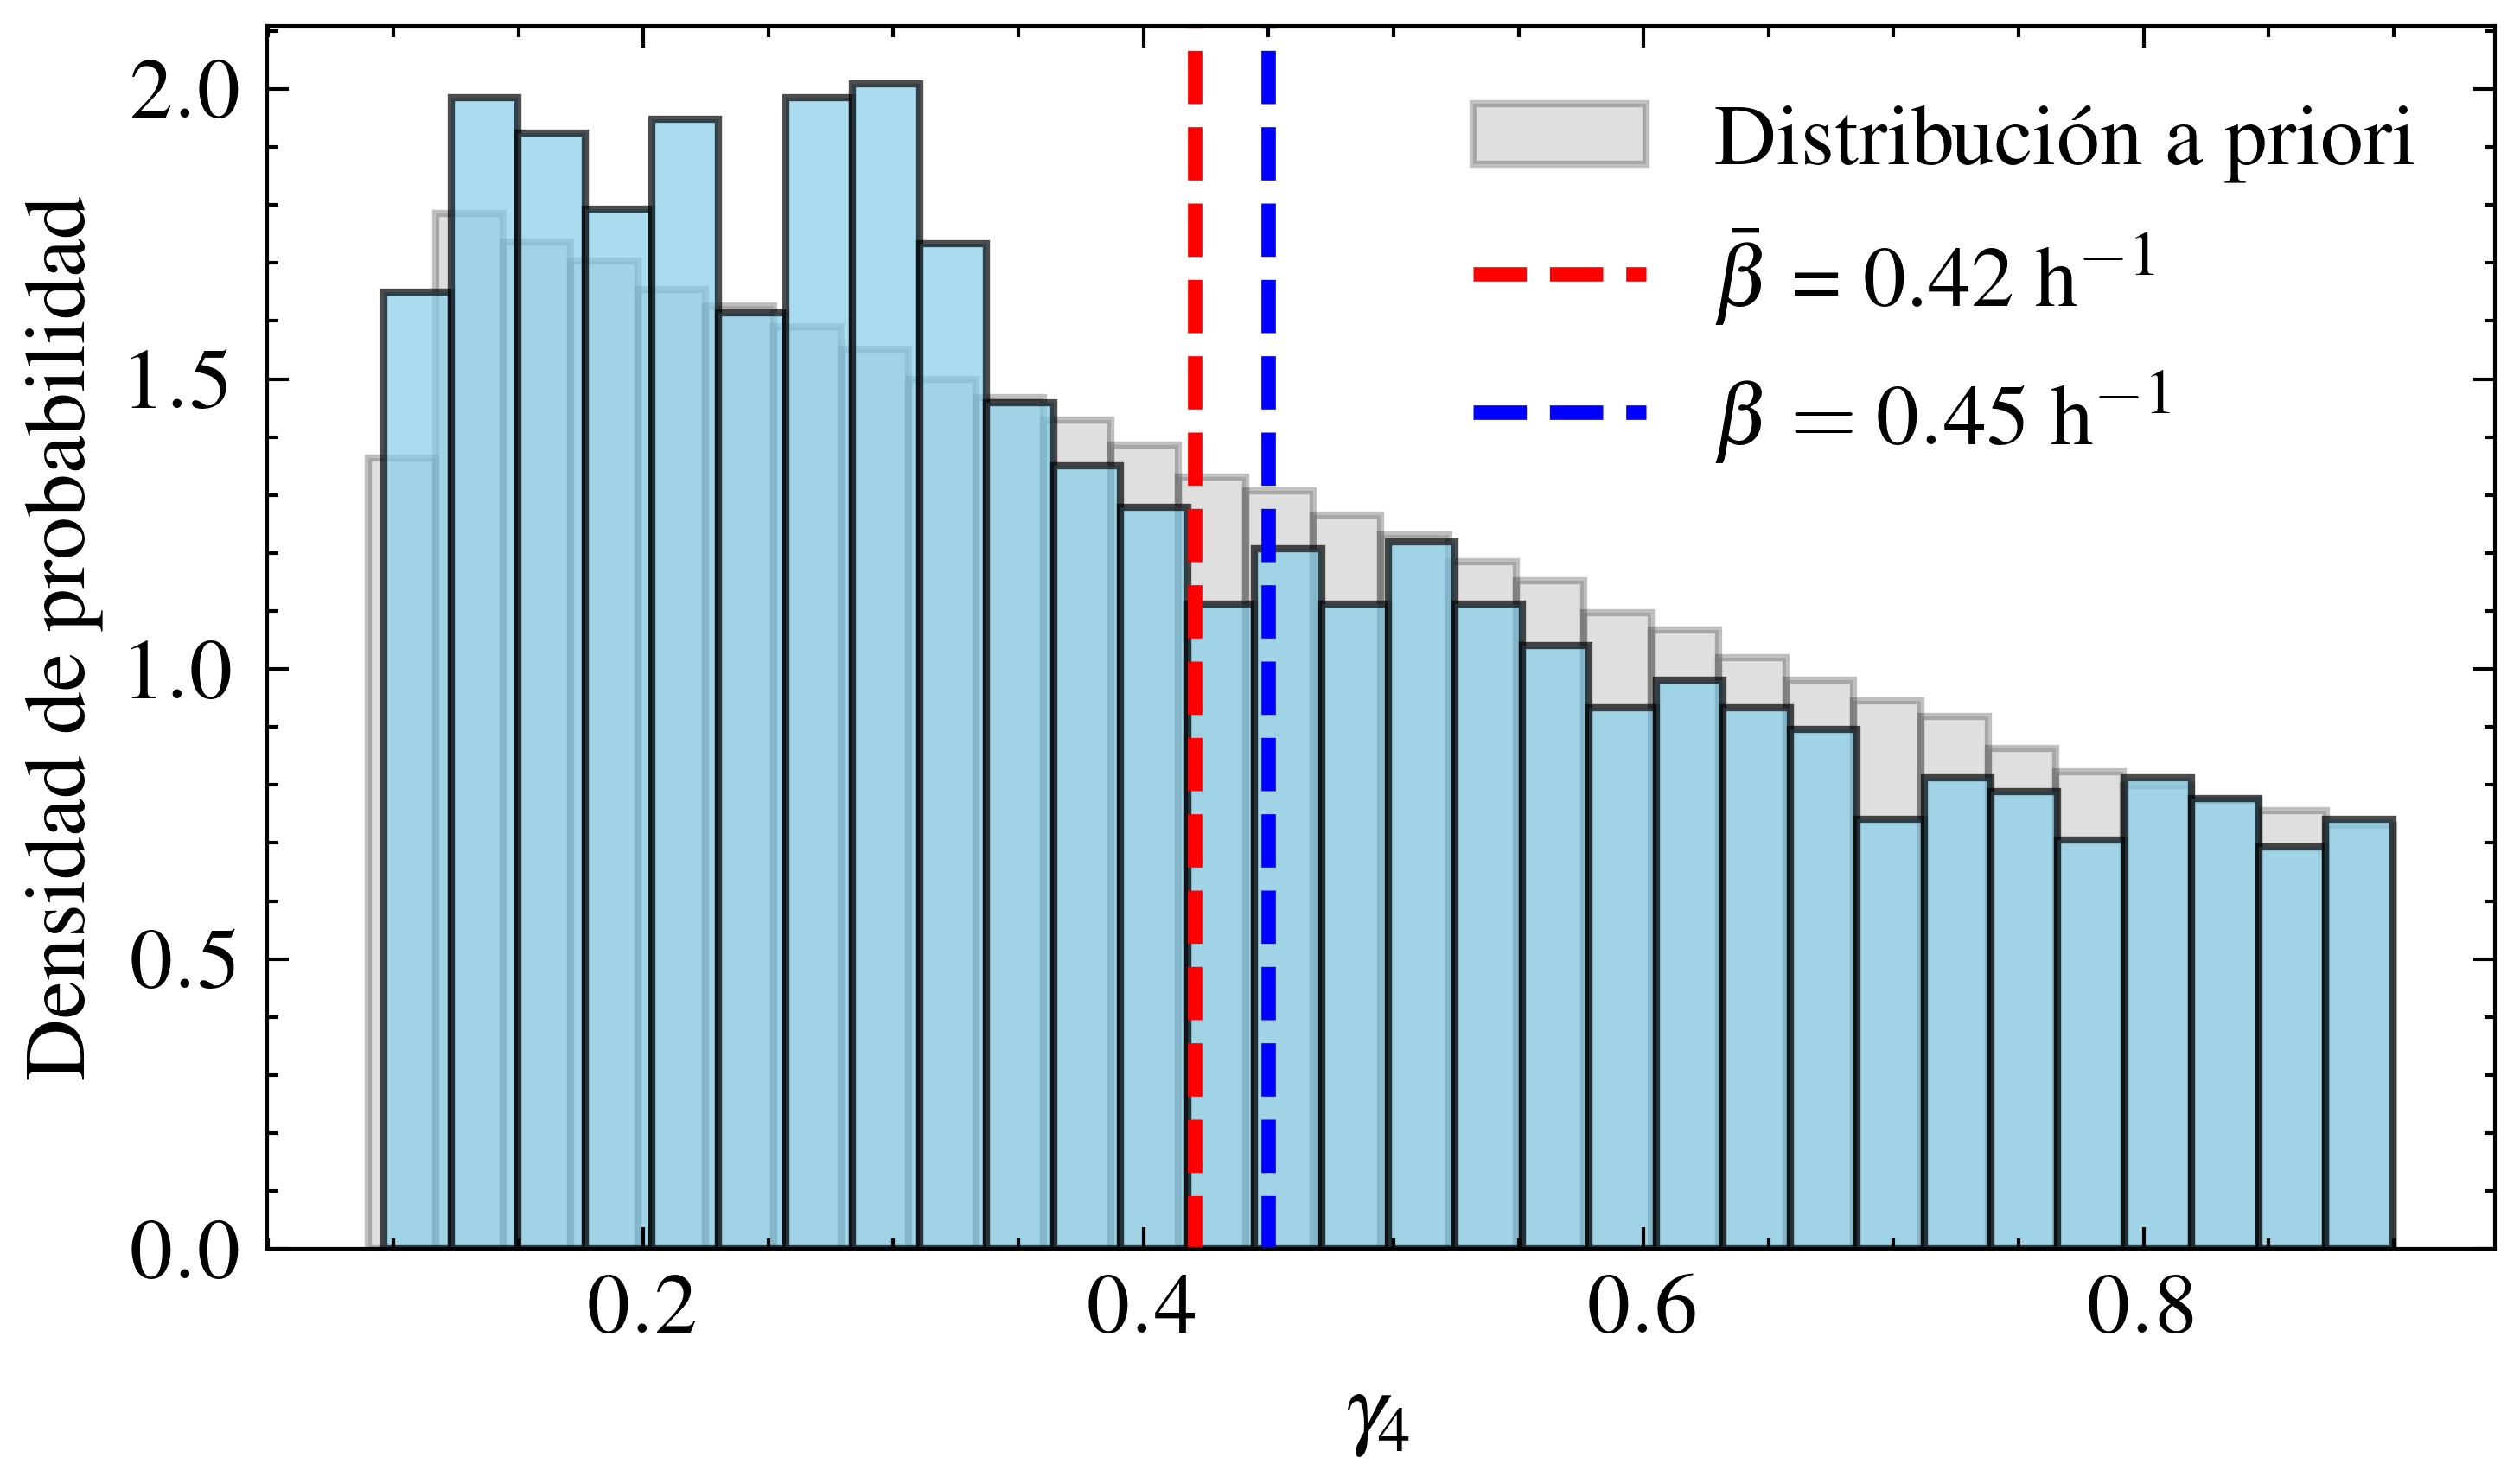

In [40]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['gamma_4'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['gamma_4'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['gamma_4'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["gamma_4"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.45, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 0.45~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\gamma_4$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_gamma_4_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

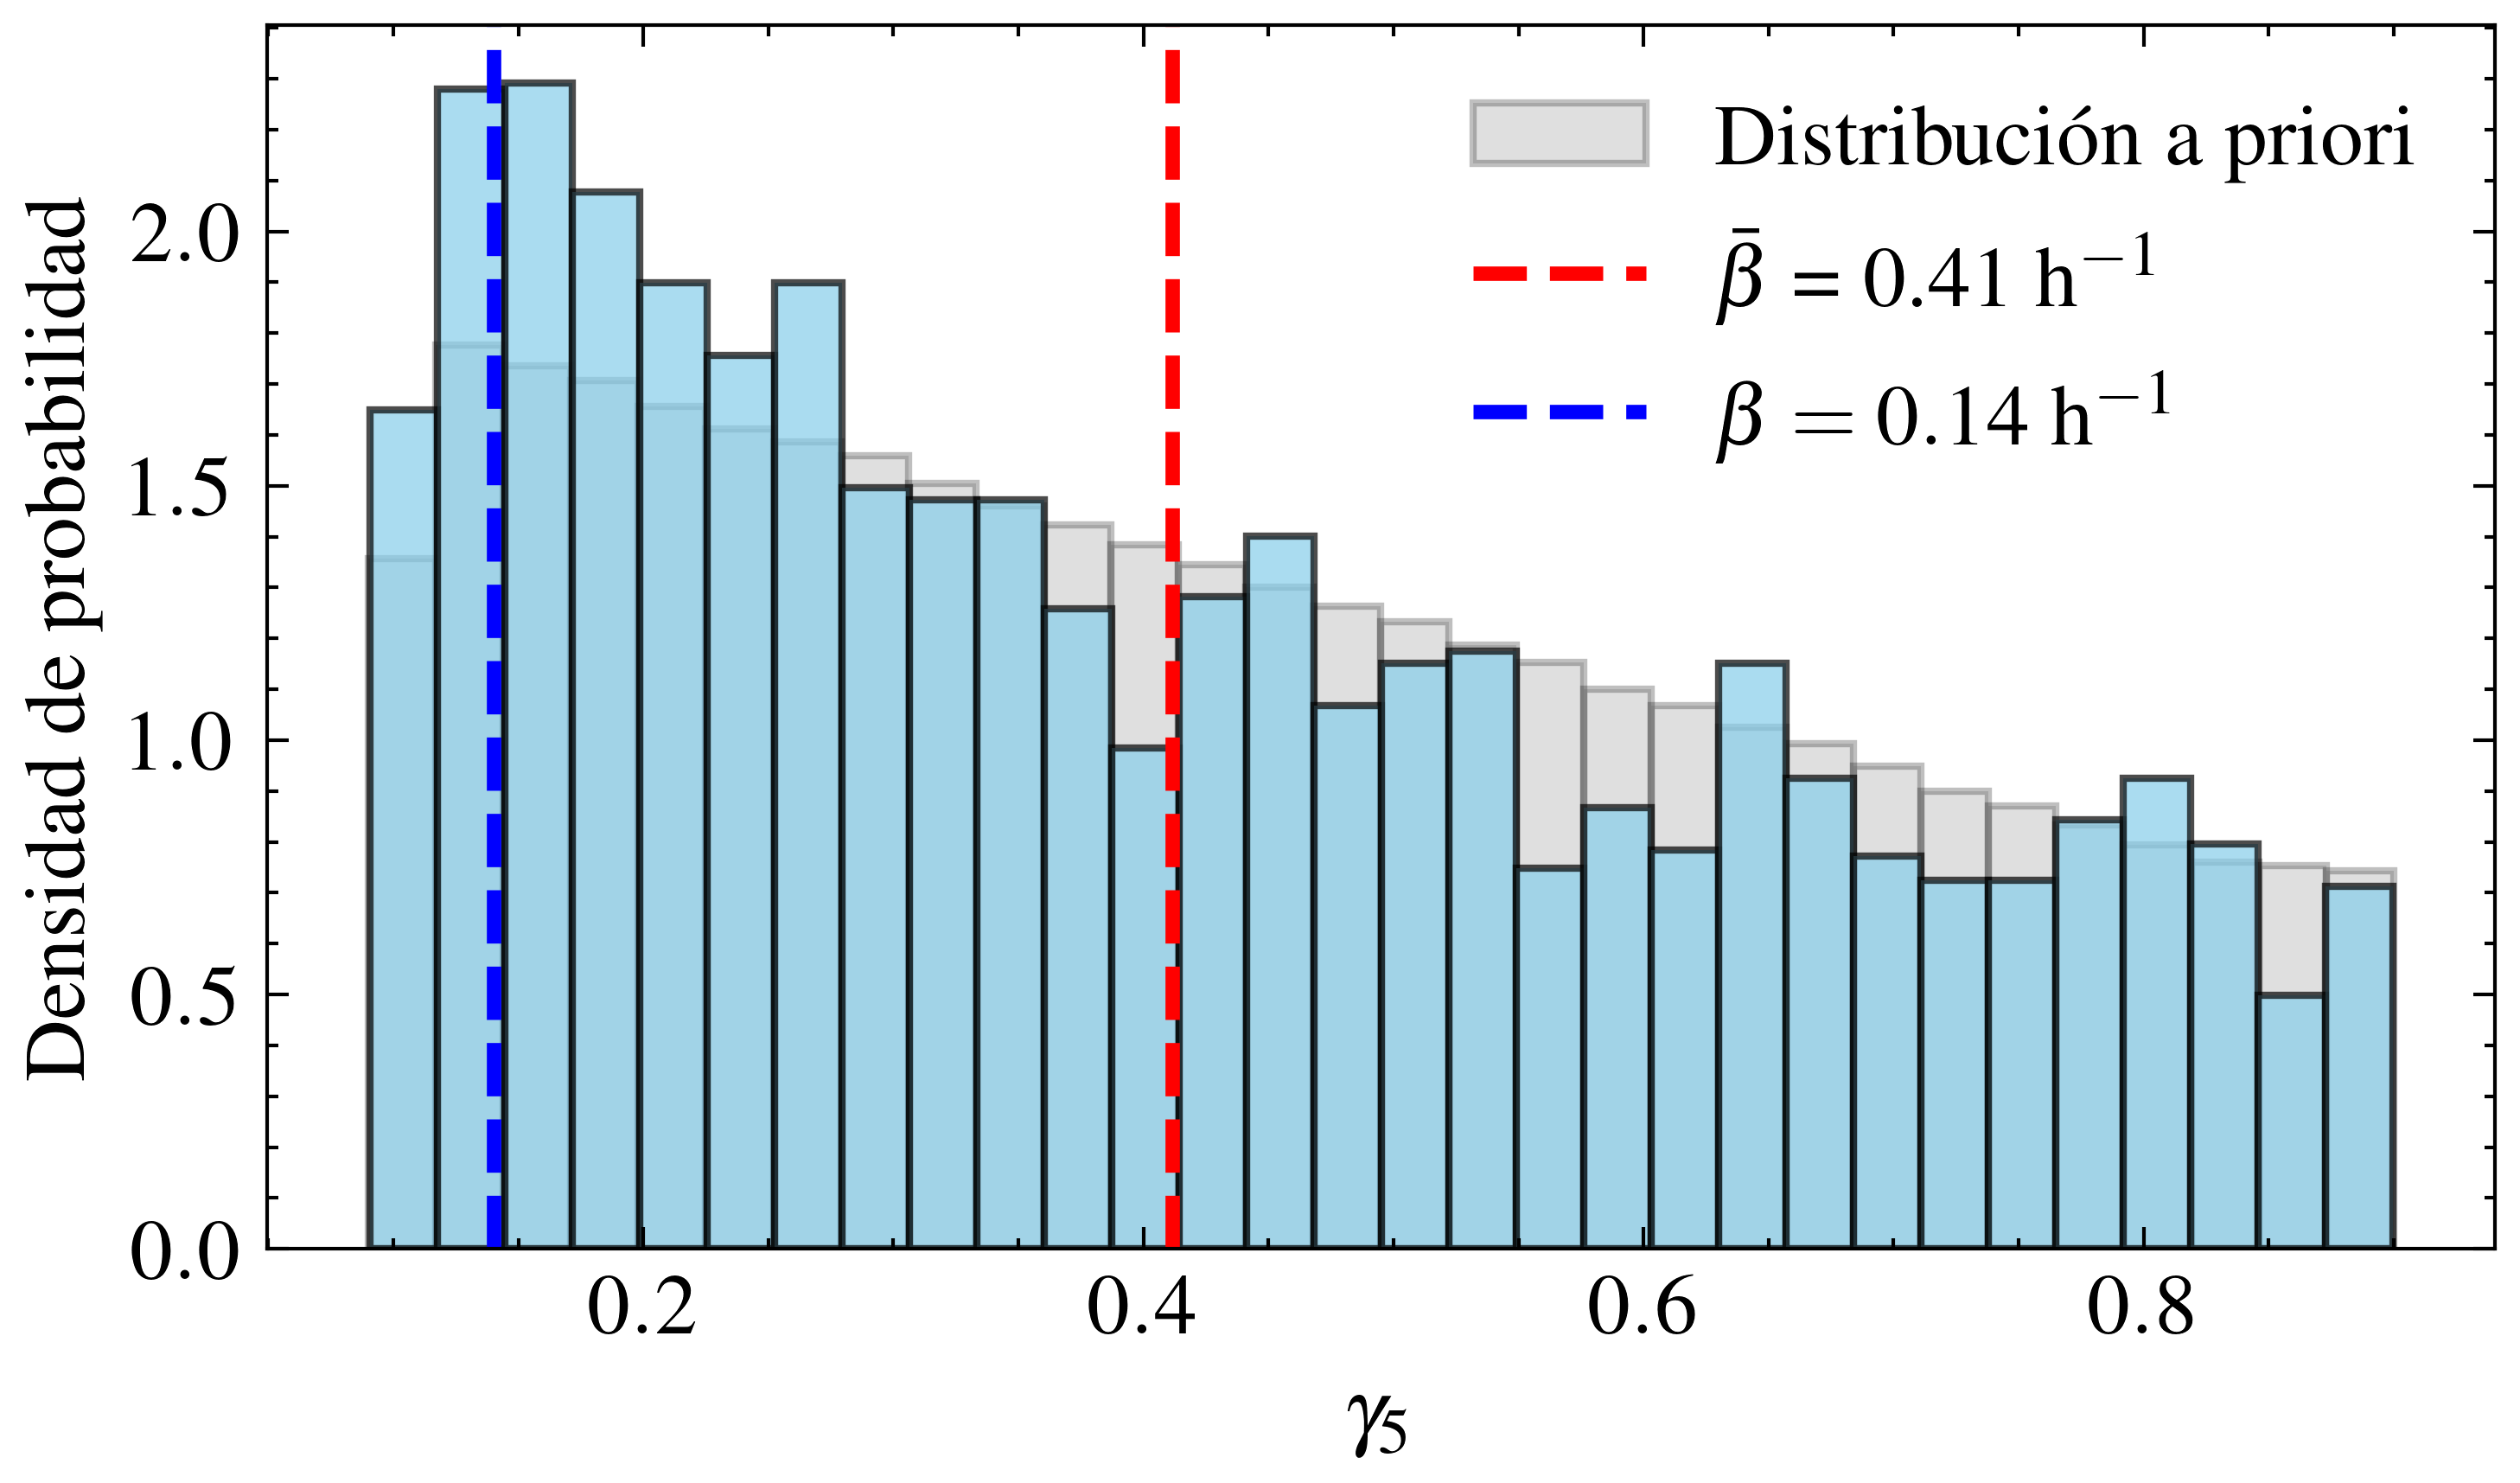

In [41]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(df_completo_3['gamma_5'], bins=30, alpha=0.25, color='gray', edgecolor='black',
        density=True, label='Distribución a priori')

ax.hist(mejores_10000_3['gamma_5'], bins=30, alpha=0.7, edgecolor='black', density=True, color='skyblue')
ax.axvline(mejores_10000_3['gamma_5'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'$\\bar{{\\beta}}$ = {mejores_10000_3["gamma_5"].mean():.2f} $\\mathrm{{h^{{-1}}}}$')
ax.axvline(0.14, color='blue', linestyle='dashed', linewidth=2, label='$\\beta = 0.14~\\mathrm{h^{-1}}$')
ax.set_xlabel('$\\gamma_5$', fontsize=12)
ax.set_ylabel('Densidad de probabilidad', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('hist_gamma_5_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')  # Guardar la figura como PNG
plt.show()

In [42]:
# Mejor individuo
mejor_individuo_3 = mejores_10000_3.iloc[0]
print("Mejor individuo encontrado:")
print(mejor_individuo_3)

Mejor individuo encontrado:
D           9.9001455307
A           0.0001118979
B          21.1600170135
beta_1      1.3841999769
beta_2      1.0604500771
beta_3      1.3349727392
beta_4      1.8470317125
beta_5      0.9399352074
gamma_1     0.7863917947
gamma_2     0.8408838511
gamma_3     0.6970797777
gamma_4     0.3175109625
gamma_5     0.5800818205
fitness     0.1213979544
Name: 67450, dtype: float64


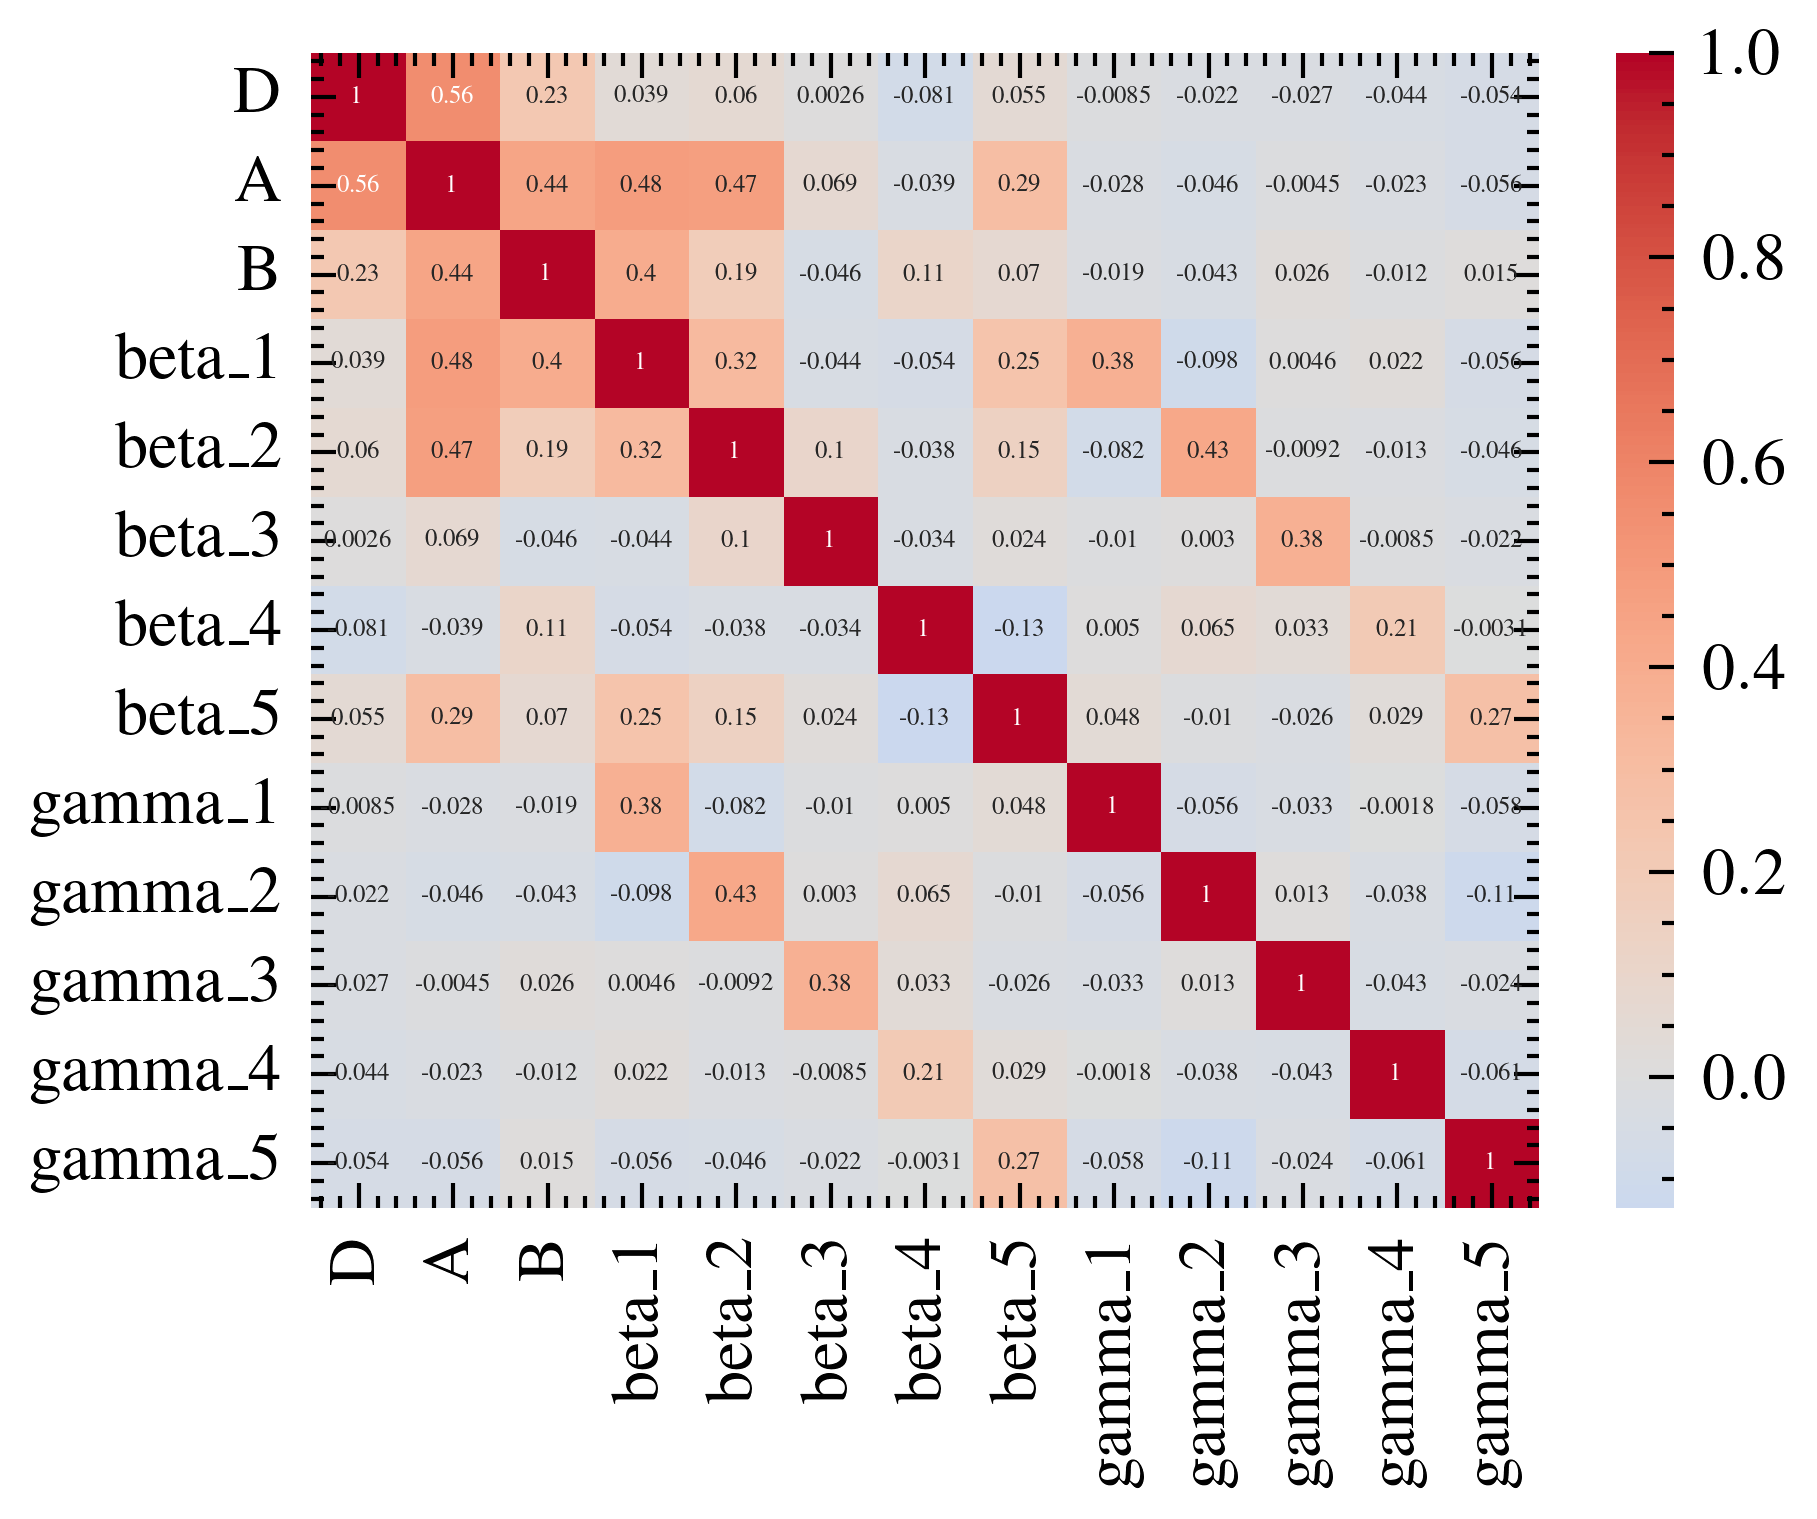

In [48]:
# # --- Opción 1: Matriz de correlación completa ---
mejores_10000_3_para_corr = mejores_10000_3.drop(columns=['fitness'])

# xticks = ['$D$', '$A$', '$B$', '$x$', '$y$', '$\\beta$', '$\\gamma$']

plt.figure()
sns.heatmap(
    mejores_10000_3_para_corr.corr(), 
    annot=True, 
    annot_kws={"size": 3},
    cmap="coolwarm", 
    center=0,
    # xticklabels=xticks,
    # yticklabels=xticks
)

# plt.savefig('correlation_matrix_exp3_fuerza_bruta.pdf', dpi=600, bbox_inches='tight')
plt.show()